# Your first neural network

In this project, you'll build your first neural network and use it to predict daily bike rental ridership. We've provided some of the code, but left the implementation of the neural network up to you (for the most part). After you've submitted this project, feel free to explore the data and the model more.



In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/Users/bnekkalapudi/anaconda/envs/dlnd/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [3]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [4]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

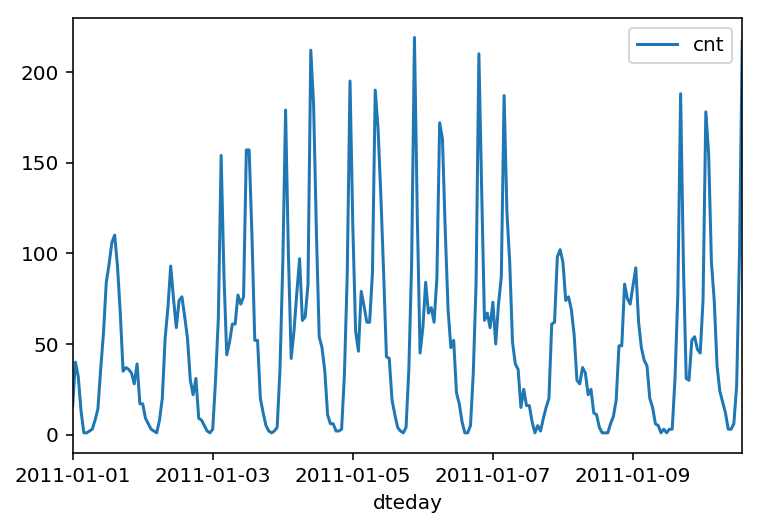

In [46]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [6]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [7]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [8]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [9]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Time to build the network

Below you'll build your network. We've built out the structure and the backwards pass. You'll implement the forward pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

<img src="assets/neural_network.png" width=300px>

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [10]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        #### TODO: Set self.activation_function to your implemented sigmoid function ####
        #
        # Note: in Python, you can define a function with a lambda expression,
        # as shown below.
        # self.activation_function = lambda x : 0  # Replace 0 with your sigmoid calculation.
        
        ### If the lambda code above is not something you're familiar with,
        # You can uncomment out the following three lines and put your 
        # implementation there instead.
        #
        #def sigmoid(x):
        #    return 0  # Replace 0 with your sigmoid calculation here
        #self.activation_function = sigmoid
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))  # Replace 0 with your sigmoid calculation here
        self.activation_function = sigmoid
                    
    
    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        print(targets)
        for X, y in zip(features, targets):
            #### Implement the forward pass here ####
            ### Forward pass ###
            # TODO: Hidden layer - Replace these values with your calculations.
            hidden_inputs = np.dot(X, self.weights_input_to_hidden) # signals into hidden layer
            hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer

            # TODO: Output layer - Replace these values with your calculations.
            final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
            final_outputs = final_inputs
            
            #self.activation_function(final_inputs) # signals from final output layer
            
            #### Implement the backward pass here ####
            ### Backward pass ###

            # TODO: Output error - Replace this value with your calculations.
            error = y - final_outputs # Output layer error is the difference between desired target and actual output.
            
            # TODO: Calculate the hidden layer's contribution to the error
            # hidden_error = np.dot(output_error_term, self.weights_hidden_to_output)
            
            # TODO: Backpropagated error terms - Replace these values with your calculations.
            output_error_term = error * 1.0 #error * final_outputs * (targets - final_outputs)
            # hidden_error_term = None
            
            #hidden_error = error - hidden_outputs
            hidden_error = np.dot(self.weights_hidden_to_output, error)
            hidden_error_term = hidden_error * hidden_outputs * (1- hidden_outputs)
        
            #np.dot(output_error_term, self.weights_hidden_to_output) * hidden_outputs * (1 - hidden_outputs)

            # Weight step (input to hidden)
            delta_weights_i_h += hidden_error_term * X[:, None]
            # Weight step (hidden to output)
            delta_weights_h_o += output_error_term * hidden_outputs[:, None]

        # TODO: Update the weights - Replace these values with your calculations.
        self.weights_hidden_to_output += self.lr * delta_weights_h_o #/ n_records # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr * delta_weights_i_h #/ n_records # update input-to-hidden weights with gradient descent step
 
    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        #### Implement the forward pass here ####
        # TODO: Hidden layer - replace these values with the appropriate calculations.
        # hidden_inputs = np.dot(self.input_nodes, self.weights_input_to_hidden) # signals into hidden layer
        hidden_inputs =  np.dot(features, self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # TODO: Output layer - Replace these values with the appropriate calculations.
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer 
        
        return final_outputs

In [11]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Unit tests

Run these unit tests to check the correctness of your network implementation. This will help you be sure your network was implemented correctly befor you starting trying to train it. These tests must all be successful to pass the project.

In [12]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....

[[ 0.4]]



----------------------------------------------------------------------
Ran 5 tests in 0.007s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Training the network

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

### Choose the number of iterations
This is the number of batches of samples from the training data we'll use to train the network. The more iterations you use, the better the model will fit the data. However, if you use too many iterations, then the model with not generalize well to other data, this is called overfitting. You want to find a number here where the network has a low training loss, and the validation loss is at a minimum. As you start overfitting, you'll see the training loss continue to decrease while the validation loss starts to increase.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. A good choice to start at is 0.1. If the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
The more hidden nodes you have, the more accurate predictions the model will make. Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.

In [34]:
import sys

### Set the hyperparameters here ###
iterations = 2000
learning_rate = 0.01
hidden_nodes = 9
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

5590     0.195917
763     -0.890155
14593    0.113221
8929    -0.311284
14323   -0.300258
9939    -1.033495
10942   -0.983877
375     -1.033495
7560    -0.680659
2276     0.372335
10129   -0.928746
6546     1.530077
4953    -0.812972
14914   -0.846051
4762     0.730683
13453    3.239124
3743    -0.101788
6366     0.267587
12528   -0.840538
13651    0.008473
5741     0.653501
6189    -0.735789
10218   -0.013579
4222     0.791327
6885    -0.327823
15003    0.157326
2801     0.421952
13962   -0.184484
5434     1.149676
11784   -0.901181
           ...   
11608    0.603883
13469    0.240021
621     -1.000416
13059    2.516914
4169     0.069117
15035    2.765001
14638   -0.994903
12100    0.614909
11471   -1.033495
7742    -0.983877
13032   -0.823998
11506    2.279852
13409    0.300665
8825     0.846458
10361    0.532213
1715    -1.033495
214     -1.027981
12230    1.855347
4978    -0.261667
3243    -0.906694
11037   -0.994903
2419     0.780301
14373   -1.000416
11091    2.395626
8124    -1

Progress: 0.3% ... Training loss: 8.412 ... Validation loss: 5.8436971    -0.768868
1761    -0.906694
5981     0.824405
11148    2.042791
6535    -0.129353
4096     0.217969
15025   -0.956312
13843   -0.201023
8705    -0.642068
7176    -0.118327
775     -0.189997
361     -0.393980
2946     0.840945
13054   -1.033495
9219    -0.972851
9235     1.546616
5413    -0.267180
7805    -0.267180
3480    -0.101788
11009   -0.327823
3238     0.510161
6660    -0.939773
6950    -1.000416
268     -0.774381
6316     1.182754
8209     1.149676
11727    0.620422
6980     0.791327
10407    3.084758
10543   -0.145892
           ...   
578     -0.724763
15282    0.168352
5445    -0.134866
9780    -0.261667
12930   -0.167945
5253     1.000823
15320    1.293015
9847    -0.801946
7825     0.736196
11892    2.693331
1039    -0.961825
11176    0.217969
4204    -0.956312
11384    0.190404
9504     0.008473
2463     0.846458
2445    -0.653094
6632    -0.223075
10858    0.432978
6148     0.548753
11518   -1.02246

Name: cnt, Length: 128, dtype: float64
Progress: 0.7% ... Training loss: 0.733 ... Validation loss: 1.32114436    3.751838
2315    -0.134866
7382    -0.890155
209     -1.016955
8818    -1.033495
679     -0.801946
11473   -0.890155
3712    -0.189997
11576    0.212456
14144    0.923640
8485    -1.039008
801     -0.664120
8568    -0.212049
10090    0.168352
12266    1.750599
10585   -1.011442
15288   -0.829511
14963    1.474946
7838    -0.471163
13304    1.017362
243     -0.730276
9936    -0.945286
385     -0.531806
9863    -0.901181
4199     0.030525
3791     0.168352
6871     0.091169
9063    -0.327823
1651    -0.272693
1873    -0.631041
           ...   
9422    -0.228588
9462    -1.011442
10646   -0.410519
1179    -0.983877
11771    1.276476
5471     0.195917
4501    -0.338849
12696   -0.917720
8994     0.091169
5601     0.421952
1143    -0.471163
14493   -0.664120
9274     0.168352
15272    0.493622
13092    1.237885
5933     1.215832
2609     1.144163
2216    -1.011442
15421    3.27

Progress: 1.0% ... Training loss: 0.649 ... Validation loss: 1.17411198    1.833295
10178   -1.039008
9179     0.118734
3778    -0.256154
12207    0.703118
14882    1.667903
11755   -0.862590
5883    -0.724763
4700     1.877399
3933     0.763762
484     -1.033495
3882     0.675553
15381   -0.961825
9412    -0.994903
797     -0.653094
7167    -0.570398
5286    -0.989390
13510   -0.807459
6121     0.907101
2489    -0.074223
6272    -0.178971
13546    0.504648
14568   -0.835024
8321    -0.597963
5007    -0.217562
4010    -0.862590
5883    -0.724763
11938    0.697605
12268    0.670040
8471    -0.509754
           ...   
10579    0.041551
11481    1.381224
9933    -0.289232
9331     0.245534
8915     1.756112
4413     0.967745
4290     1.149676
13783    0.532213
2760    -0.239614
13599    2.081382
8131     0.256561
10676   -0.686172
9269    -1.000416
13281    0.107708
5952     0.995310
5084     1.838808
1697    -0.195510
6626     1.441868
7914    -0.531806
7917    -0.195510
2220    -0.10730

Progress: 1.4% ... Training loss: 0.618 ... Validation loss: 1.1873389    -1.022468
2464     0.945693
12751   -0.052171
4567    -0.890155
5665     0.096682
6787     0.096682
8441    -0.184484
3601    -0.101788
2941     0.868510
9502    -0.768868
6678     0.195917
984     -0.305771
2760    -0.239614
7030     0.047064
8074    -1.022468
14592   -0.823998
7577     0.912614
1096    -0.520780
2542     0.195917
6455    -0.355389
320     -0.669633
9702    -0.923233
14570    1.673416
2773     0.725170
10751   -1.011442
13532   -0.895668
2480    -0.746816
11791    0.874023
15181    2.230235
12456   -0.884642
           ...   
3749    -1.011442
8461    -1.022468
1251    -0.851564
9199    -0.901181
1042    -1.039008
9226     1.783677
9044     1.508024
4548    -0.421545
11583    0.818892
12096   -0.879129
12225    0.267587
6275    -0.608989
6402     1.331607
15129    0.377848
5389    -0.338849
13113    0.284126
7733    -0.669633
7830    -0.559372
8478    -0.934260
316     -0.548346
6611    -0.68617

Progress: 1.7% ... Training loss: 0.586 ... Validation loss: 1.09440      -0.686172
9938    -1.016955
2629     0.703118
12896    0.642475
6231    -0.879129
8578    -0.989390
5547    -0.912207
7999    -0.796433
12146   -0.746816
8074    -1.022468
4822     0.030525
11301   -0.597963
5415    -0.013579
4788     0.047064
494     -0.586937
14046    0.306178
13474    0.146299
4729    -0.498728
2685     0.763762
2469     0.113221
13733    0.206943
9988    -1.016955
6865     0.085656
248     -0.294745
6644     0.967745
3935     0.102195
6611    -0.686172
10565    1.904964
2589    -0.741303
13635    2.682305
           ...   
1670    -0.983877
7188    -1.011442
9291    -0.724763
13686    1.761625
4929     0.355796
2774     1.248911
1108    -0.454624
3857    -0.063197
6824    -0.327823
13150   -0.873616
3405     1.039415
13077   -0.531806
14697    2.522427
7607    -0.195510
13080   -0.939773
11666   -0.846051
6611    -0.686172
9591    -0.250641
3914    -0.912207
6906     0.184891
14840    2.83667

Progress: 2.0% ... Training loss: 0.550 ... Validation loss: 1.0145931     0.526700
707     -0.636554
4803    -0.515267
8244    -1.011442
14044    0.636961
370     -0.928746
6850    -0.873616
8179    -0.410519
6528    -0.035631
10589    2.533453
15130    0.587344
13838    1.144163
13222   -1.027981
10101   -0.575911
14736   -0.801946
12151    1.871886
1749    -0.085249
1175    -0.680659
12409   -0.096275
15111    1.348146
7249     0.427465
8009     0.002960
1177    -0.884642
9255    -0.090762
12341    1.182754
14401   -0.234101
9508    -1.027981
10844   -0.697198
10039    2.037278
7389    -0.052171
           ...   
50      -1.027981
13920   -0.807459
11851   -0.851564
4770    -0.041144
12372    3.553368
3283     1.403276
10387   -0.107301
4467    -0.421545
10851    0.642475
1801    -0.184484
7583    -0.438084
492     -0.631041
309     -0.399493
4687    -0.939773
3467    -0.206536
13804    1.138650
14418   -0.443598
82      -0.697198
1281    -0.085249
10496    0.984284
13802    1.27647

Progress: 2.4% ... Training loss: 0.512 ... Validation loss: 0.89210493   -0.515267
1422    -0.564885
11028    1.111084
13659   -0.145892
10124   -0.631041
5561     0.080143
14453    0.245534
1343    -0.790920
14097    0.361309
11932    0.862997
3360    -0.267180
12321    2.522427
14072    0.532213
13119    0.725170
13198   -1.016955
13502    0.267587
149     -0.719250
1843    -0.460137
9467    -0.178971
8788    -0.608989
186     -0.978364
10063   -0.835024
6206    -1.005929
2814    -0.950799
14937    0.532213
14163   -0.002553
6381    -0.212049
3374     0.113221
14546   -0.807459
2593    -0.950799
           ...   
480     -0.978364
2994     0.631448
10672    1.022875
11508    1.833295
5545    -0.603476
15154    1.116597
8756     0.041551
8825     0.846458
5337     0.377848
2257    -0.763355
4678     0.736196
13060    0.455031
4443    -0.752329
12353    0.201430
9669    -0.730276
10154   -0.967338
11198    1.833295
1406    -0.763355
6643    -0.024605
3167    -0.068710
7935     0.08565

Progress: 2.8% ... Training loss: 0.479 ... Validation loss: 0.8415480    -0.967338
7130    -0.873616
4786    -0.443598
10264    2.208182
8962    -0.912207
14428    0.874023
1570    -0.890155
10182    1.315067
1351    -0.608989
1211    -0.564885
6883    -0.366415
8213    -0.278206
6167    -0.068710
5434     1.149676
13487   -0.956312
9797    -1.005929
8816    -1.011442
13232    0.499135
11256   -0.879129
4057    -0.465650
1180    -1.033495
8224     1.530077
12222    0.041551
4989     0.466057
14111   -1.016955
6379    -0.189997
127     -0.675146
13578    0.013986
9683    -0.653094
7409     1.359172
           ...   
6533     0.857484
10215    1.414302
6471    -1.005929
6270    -0.057684
11198    1.833295
15052    0.763762
14923   -0.901181
7956    -1.000416
2921     0.388874
13671    0.240021
14483    1.866373
6709    -1.033495
13262    2.445244
4685    -1.027981
14883    2.720897
183     -0.857077
12610    0.741710
6989    -0.250641
12562   -0.405006
10127   -0.801946
10716    0.05809

Progress: 3.1% ... Training loss: 0.439 ... Validation loss: 0.7336585    -0.498728
9036    -0.702711
13417   -0.151406
5528    -0.416032
5084     1.838808
13433    0.543240
10863    1.678929
5879    -0.989390
3086     0.184891
5910    -0.757842
8102    -0.697198
7306    -0.410519
12646   -0.895668
13732    0.791327
6445    -0.906694
3603    -0.526293
11814    1.833295
2221    -0.520780
731     -0.631041
3938    -0.471163
8205    -0.344363
322     -0.846051
10060   -0.471163
750     -0.614502
3929     0.295152
4885    -0.294745
12974    0.956719
12004    0.681066
12277    3.283228
3029    -1.027981
           ...   
12174    1.816755
10352   -0.217562
10121   -0.085249
10013   -0.548346
149     -0.719250
3552    -0.333336
10826   -0.945286
11300   -0.559372
9772    -1.039008
5652    -0.691685
13763    1.596233
10687   -0.201023
5362     1.386737
12715   -0.851564
7048     0.603883
181     -0.890155
13788    3.724273
3075    -0.934260
439      0.328230
7479    -0.917720
12971    0.89056

Progress: 3.5% ... Training loss: 0.406 ... Validation loss: 0.6946492    -1.022468
4187     0.311691
6737    -0.597963
2542     0.195917
8784    -0.068710
1854    -0.983877
7822     0.681066
6144     0.670040
8256    -0.322310
7468    -0.101788
7585     0.030525
5105     0.113221
3895    -0.906694
12522   -0.438084
11278   -0.989390
9503    -0.680659
13053   -0.989390
14670    2.142026
428     -0.719250
6598     0.251048
8315    -0.945286
5841    -0.592450
9358    -0.046657
12106    0.559779
6564    -0.989390
3755     0.129760
2222    -0.371928
5872    -1.022468
12283   -0.570398
14615   -1.000416
           ...   
10405    0.918127
5336    -0.548346
4679     0.069117
5871    -1.033495
5384    -0.465650
915     -0.603476
8861    -1.016955
11358   -0.487702
11920    1.122110
667     -1.033495
6177    -0.669633
4212    -0.349876
5427    -0.934260
2032    -0.504241
3690     0.653501
6421    -1.027981
10823   -0.597963
15202    2.533453
1106    -0.360902
15421    3.277715
13423    0.06911

Progress: 3.8% ... Training loss: 0.374 ... Validation loss: 0.6331814    -0.504241
7079    -0.537319
1007    -0.548346
10383    3.002063
5776    -0.851564
13964   -0.818485
3277     1.259937
7510     0.074630
9159     0.052578
11594    1.072493
4524    -0.366415
10215    1.414302
6201    -0.597963
6842     0.620422
9158    -0.024605
11665   -0.950799
14741    0.036038
11741   -0.201023
1915    -0.311284
5874    -0.631041
15264   -0.857077
13012    0.162839
14527    1.960095
7969     0.234508
1389    -1.039008
8198    -0.537319
7048     0.603883
10564    1.006336
6336    -0.195510
9666    -0.564885
           ...   
9399    -0.019092
5656    -1.011442
3497     0.670040
1314    -0.719250
6265    -0.708224
11641   -0.812972
6913     0.245534
9526    -0.195510
6265    -0.708224
351     -0.961825
4861    -0.212049
7428    -1.011442
10228   -0.449111
6575     0.008473
3921     0.333743
12911   -0.983877
1473    -0.906694
4786    -0.443598
12764   -0.945286
11680    0.074630
15202    2.53345

Progress: 4.2% ... Training loss: 0.351 ... Validation loss: 0.6047758    -0.901181
13310    1.645851
3831     0.206943
2032    -0.504241
956     -0.416032
4549    -0.134866
10405    0.918127
12425    0.322717
15266    1.794703
9336    -0.691685
8708    -0.294745
9871     1.513537
1127    -0.344363
666     -1.039008
15356   -0.443598
11543   -1.000416
5499    -0.928746
1898    -0.614502
4672    -0.283719
566     -0.239614
7000     0.526700
12612    3.735299
6557     1.017362
7422    -0.294745
15212   -0.945286
10200   -1.022468
11751   -0.763355
11829   -0.592450
3775    -0.956312
15411    2.886288
           ...   
1145    -0.041144
13955    1.254424
2015    -0.316797
10190    0.113221
10549    1.331607
12665    0.499135
9731    -0.382954
10652   -0.465650
1632     0.173865
3329    -0.074223
13781   -0.046657
7286    -1.033495
1071    -0.057684
2199    -0.305771
3592     0.278613
10194   -0.057684
8600    -1.011442
977     -0.785407
15387    1.144163
4482     1.006336
2300     0.25656

Progress: 4.5% ... Training loss: 0.333 ... Validation loss: 0.55811024    0.499135
1482    -1.039008
4146     1.463920
10863    1.678929
6489    -0.906694
13566    0.063604
13437   -1.005929
7098     0.217969
6490    -0.956312
4314     1.237885
5779    -0.917720
3197    -0.994903
4383    -0.272693
14105    0.201430
5723    -0.178971
14445   -0.950799
3065     0.151813
8131     0.256561
183     -0.857077
5762     0.493622
8828     0.686579
1007    -0.548346
1       -0.823998
6280    -0.945286
7870    -0.846051
1514    -0.614502
10002   -0.256154
2370    -0.261667
903     -1.039008
3317    -1.022468
           ...   
4486     0.432978
10348    0.432978
11049    0.515674
11260    0.614909
1243    -0.741303
12597   -0.994903
5478    -1.011442
8679    -0.079736
13362   -0.542833
6348    -0.983877
2693    -1.005929
1444    -0.167945
15398    1.000823
8054    -0.945286
12833    0.493622
13745    0.372335
12663    0.896075
13483   -0.476676
8830    -0.046657
8647    -0.631041
10115    0.17937

Name: cnt, Length: 128, dtype: float64
Progress: 4.8% ... Training loss: 0.318 ... Validation loss: 0.5464624     1.342633
12742   -1.000416
11194    0.471570
9761    -0.393980
13382    2.235748
15027   -0.079736
10392   -1.022468
12444    3.746325
2638    -0.465650
14208   -0.840538
1306     0.394387
1612     0.300665
10789    0.978771
1874    -0.923233
2619    -0.746816
9550     0.002960
6293     0.653501
9142    -0.675146
8049    -0.972851
10557   -0.862590
3512    -0.443598
1588    -0.421545
8755    -0.388467
1271    -1.000416
10600    2.186130
13860    1.061467
1232    -0.608989
13573    3.790430
3637     0.802353
2337    -0.002553
           ...   
4409    -0.129353
3929     0.295152
13095    1.993173
14390    2.114460
12806    0.951206
3163     0.466057
9142    -0.675146
7814    -1.016955
4233     0.719657
1081    -0.079736
6250    -0.757842
8037    -0.653094
2073    -0.890155
12287   -1.011442
7595    -0.989390
8667    -0.680659
10239    2.329470
8465    -0.735789
6516    -1.02

Name: cnt, Length: 128, dtype: float64
Progress: 5.2% ... Training loss: 0.319 ... Validation loss: 0.55410419   -0.399493
4299    -0.614502
6348    -0.983877
874     -0.746816
9502    -0.768868
5547    -0.912207
10863    1.678929
10934    2.803592
15194   -0.730276
4350    -1.016955
560     -0.531806
4931    -0.057684
2894     0.036038
13390   -1.027981
5594    -0.763355
3879    -0.002553
2427    -0.862590
817     -0.085249
13107    1.987660
9021    -0.046657
1300    -0.719250
4468    -0.515267
3646     0.493622
9799    -0.994903
5125     0.879536
4711    -0.917720
8347    -0.344363
12971    0.890562
2974    -0.085249
13882    0.466057
           ...   
13121    0.195917
8967     0.162839
5783     0.377848
9884    -0.195510
4120     1.066980
11169    2.417679
7319     0.719657
9329     0.664527
6932    -0.085249
13994   -0.702711
2874     0.030525
3451     0.835431
3244    -1.000416
375     -1.033495
2911    -0.956312
13545    0.449518
4443    -0.752329
5131    -0.223075
4697    -0.17

Progress: 5.5% ... Training loss: 0.299 ... Validation loss: 0.5203906     0.576318
11283    2.814619
2415    -0.052171
6216    -0.057684
10035   -1.033495
5549    -1.039008
2532    -0.322310
3589     0.013986
3075    -0.934260
3594     0.879536
8794    -1.005929
7865     0.069117
7300     0.080143
15416    0.267587
131     -0.096275
12385   -0.030118
10415   -0.939773
9284     1.066980
2113    -0.741303
1093    -0.405006
11037   -0.994903
6009    -0.664120
15021   -0.520780
2643    -0.989390
539     -0.730276
1891    -0.586937
1557    -0.801946
3917    -1.011442
3703    -0.928746
8367     0.432978
           ...   
6750    -0.046657
9991    -0.719250
5167    -0.961825
3487    -1.005929
7809    -0.790920
9299    -0.173458
7409     1.359172
3573     1.044928
9147    -0.768868
156     -0.520780
12585    0.719657
4835    -0.300258
13371    2.632688
10450    0.388874
2811    -0.416032
7894    -0.427058
2331    -0.972851
9013    -0.349876
2081    -0.564885
12462    0.410926
658     -0.68617

Progress: 5.9% ... Training loss: 0.293 ... Validation loss: 0.51711367    0.074630
1000     0.366822
864     -0.768868
2250    -0.906694
13073   -0.068710
6687    -0.934260
5497    -0.669633
3329    -0.074223
6574     0.201430
6957     0.846458
11013   -0.956312
11750   -0.504241
3334     0.664527
6456    -0.052171
12200    2.020739
5309    -0.895668
10690    0.614909
4126     0.438491
11488   -0.581424
5459     0.002960
11498   -0.895668
1555    -0.978364
10842   -0.305771
10342   -0.989390
5075    -0.013579
4728    -0.112814
9647    -0.790920
1598    -0.967338
4965     0.366822
6812     0.868510
           ...   
8628    -0.939773
7901    -0.300258
4695    -0.096275
13798   -1.011442
11852   -0.983877
9609     1.425328
15010    3.090271
4533     0.813379
14160   -0.994903
10230    2.075869
7110    -0.636554
5119    -1.011442
1108    -0.454624
3248    -0.399493
5893    -1.022468
5517     1.248911
5484     0.466057
12925    3.387976
7929    -0.961825
719     -0.189997
15391    0.83543

Progress: 6.2% ... Training loss: 0.290 ... Validation loss: 0.4885876     0.763762
110     -0.316797
11889   -0.030118
12110    1.667903
13181    0.714144
90      -0.851564
1159    -1.022468
8168    -0.934260
4732    -1.011442
12509    1.232372
3585     0.482596
15171    0.118734
5243     0.041551
11807   -0.994903
5519     0.102195
12805    1.739573
8034    -0.768868
11418   -0.471163
15395    1.033902
2102     0.047064
6629     0.322717
11687   -1.033495
7218     0.212456
8633     0.460544
758     -0.972851
8305    -0.134866
5285    -0.895668
11559    0.802353
6777    -0.520780
2220    -0.107301
           ...   
6431     0.421952
953     -0.879129
12929    0.592857
12116   -0.812972
324     -0.890155
11230   -1.011442
3351     0.002960
5859    -0.553859
3327     0.080143
9408    -0.272693
13043    0.967745
1383    -0.779894
10566    0.570805
4997    -1.022468
12872    0.388874
6703    -0.079736
11930    1.568668
2112    -0.620015
7324    -0.212049
15421    3.277715
6035    -1.00041

Progress: 6.6% ... Training loss: 0.282 ... Validation loss: 0.4711484    -1.039008
13595    1.623799
13713    0.355796
2637     0.025012
1345     0.135273
9941    -0.592450
13792    0.840945
1844    -0.487702
12530    1.728547
9976    -0.167945
7556    -0.713737
10855    0.107708
2728    -0.261667
10608   -0.989390
1137    -0.945286
1512    -0.212049
898     -0.790920
7868    -0.945286
1085    -0.801946
12576   -0.823998
9191    -0.382954
9032    -0.730276
5788     1.094545
6233     0.670040
2176    -0.735789
2978    -0.752329
12444    3.746325
10608   -0.989390
1000     0.366822
7527    -0.449111
           ...   
374     -1.000416
14873   -0.344363
11461    2.561018
10822   -0.702711
12168   -1.005929
627     -0.741303
5574    -1.005929
9463    -1.022468
15328    0.427465
15414    0.019499
6992    -0.774381
11168    2.709871
6495    -0.928746
12383   -1.016955
3660    -0.520780
276     -0.934260
14368   -0.129353
7738    -0.912207
8881    -0.416032
14622   -0.702711
14506    2.05933

Progress: 7.0% ... Training loss: 0.283 ... Validation loss: 0.4831737    -0.956312
1030    -0.575911
14085   -1.000416
8302     0.262074
14772    4.055056
6039    -0.873616
8525    -0.884642
4399    -0.868103
2101    -0.195510
8090     0.708631
9152    -1.022468
10921   -0.884642
14549    0.934666
7279    -0.410519
7058     1.458407
14875   -0.796433
9390    -1.039008
8927     0.278613
6600     0.366822
9943     1.541103
7943     0.052578
1308    -0.013579
8532    -0.851564
14583    1.078006
7101     0.129760
4892     1.938043
10966   -0.846051
2240    -0.994903
9527    -0.564885
4396    -1.000416
           ...   
10702   -1.016955
3576    -0.189997
1101    -0.096275
2007    -0.460137
5106     0.774788
7467     0.074630
8959    -1.027981
9902     0.030525
8083    -0.460137
13122   -0.322310
8423     0.135273
11594    1.072493
8659     0.427465
815     -0.553859
11277   -0.928746
4029     1.298528
11948   -0.774381
7638    -0.449111
9578    -0.978364
1008    -0.393980
14406    0.15732

Name: cnt, Length: 128, dtype: float64
Progress: 7.3% ... Training loss: 0.412 ... Validation loss: 0.47410454    0.377848
4754    -0.713737
10512   -1.033495
3184    -0.030118
1730     0.664527
1601    -1.033495
717     -0.945286
11018   -0.432571
15351    0.317204
14183   -0.901181
2817     0.107708
4451     0.317204
1987    -0.316797
2162    -0.779894
2193    -0.735789
13964   -0.818485
5044    -0.983877
9720    -0.730276
2684     1.866373
13830    1.546616
13626   -0.245127
9933    -0.289232
6728    -0.807459
2391    -0.167945
11731   -0.851564
2067    -1.011442
11755   -0.862590
8434    -0.972851
12486    2.092408
907     -0.063197
           ...   
5361     0.862997
14584    0.432978
4019     0.471570
12703   -0.118327
8553    -1.022468
5523    -0.939773
11246    0.984284
5385     0.653501
5246     0.135273
468     -0.642068
11979    0.030525
7096     0.085656
8257     0.741710
12243    2.654740
5634    -0.912207
470     -0.686172
8538    -0.912207
1663    -0.697198
3900    -0.37

Progress: 7.7% ... Training loss: 0.328 ... Validation loss: 0.45214034   -0.438084
4242     0.736196
7224    -0.013579
8338    -1.027981
9697    -0.967338
14017   -0.956312
717     -0.945286
556     -0.250641
8633     0.460544
3718     0.499135
4969    -0.068710
6543    -0.868103
4583     0.394387
6360    -0.206536
2343    -0.460137
6604     1.519050
11399   -1.011442
6926    -0.873616
13929    0.256561
429     -0.719250
13701   -1.000416
9523     1.364685
3056    -0.427058
4264     0.625935
7066    -0.983877
12356   -0.967338
10692    0.184891
11641   -0.812972
7539     1.386737
7150     0.857484
           ...   
3835     2.268826
15213   -0.978364
6890    -0.046657
8094    -0.537319
7837    -0.857077
5570    -0.757842
9744    -0.724763
8262    -0.360902
2928    -0.212049
12745   -0.134866
4236    -0.316797
11750   -0.504241
9059     0.069117
4979    -0.035631
675     -0.779894
12891    2.572044
7993     0.306178
9691     1.188267
14232   -0.857077
5543     0.118734
7351    -0.44911

Progress: 8.0% ... Training loss: 0.279 ... Validation loss: 0.4893996    -0.542833
5759    -0.272693
1257    -0.586937
6902    -0.901181
11838    1.315067
7586     1.155189
2308    -1.022468
11012   -0.840538
905     -0.901181
5762     0.493622
719     -0.189997
7286    -1.033495
9902     0.030525
2795    -0.267180
14402    0.438491
5191    -0.879129
777     -0.653094
13028   -0.950799
4613    -0.901181
4671    -0.206536
13475    1.359172
9766    -0.245127
14156   -0.537319
14329   -0.879129
10962   -0.173458
7378    -0.989390
2757     0.444005
15058    0.609396
14331   -0.151406
1781    -0.647581
           ...   
8312    -0.653094
10335    1.100058
4001     0.085656
8053    -1.027981
14708   -0.945286
1869    -0.294745
7408     0.455031
8951    -0.294745
13723   -0.835024
1418    -0.217562
1675    -0.614502
13593    0.317204
10860    1.133137
14701    2.042791
8295    -0.934260
71      -1.039008
14488    0.625935
4156    -1.011442
1154    -0.735789
420     -0.614502
11907    2.53896

Progress: 8.3% ... Training loss: 0.276 ... Validation loss: 0.469880     -1.033495
15162    0.002960
10250   -1.033495
1943    -0.201023
14894    1.634825
9625    -0.752329
13782    0.201430
9297    -0.873616
10561   -1.022468
5643     1.419815
6861    -0.234101
10973    0.477083
1082    -0.278206
12560   -0.719250
12453   -0.939773
4149     0.703118
10237    0.107708
826     -0.895668
9793    -0.570398
10651   -0.586937
2386     0.813379
13311    1.100058
5963    -0.449111
7361     1.524563
7695    -0.691685
841     -0.680659
3106    -0.559372
12471    1.204806
9246    -1.027981
6638    -0.967338
           ...   
5447    -0.454624
3806     1.270963
8414    -0.691685
14752    0.664527
11498   -0.895668
7281    -0.757842
14456    0.554266
9741     0.118734
11350   -1.039008
12030   -0.460137
5260    -0.961825
13826   -0.675146
13626   -0.245127
8358    -0.454624
15040    0.036038
1297    -1.027981
3692     1.993173
4087    -0.934260
1216     0.107708
13576    1.039415
9276    -0.34987

Progress: 8.7% ... Training loss: 0.271 ... Validation loss: 0.4515901    -0.686172
1535     0.328230
9776     0.201430
9078    -1.039008
11042   -0.476676
480     -0.978364
7396     0.631448
6084    -0.989390
9334    -0.432571
1851    -0.564885
6559     0.063604
9134    -0.675146
11599    0.614909
4116     0.620422
3580    -0.978364
4124     0.647988
5430    -1.000416
2265    -0.972851
592     -0.835024
12993    1.210319
8774    -0.405006
538     -0.796433
5295    -0.201023
6098     0.929153
13229    0.002960
8006    -0.548346
1714    -1.000416
3130    -0.658607
7061     0.096682
2964     0.300665
           ...   
11863   -0.024605
3930     0.912614
6015    -0.934260
7168     0.206943
15389    0.598370
7674     0.262074
8233     1.138650
6618    -0.476676
14818    0.978771
4210     1.932530
3668     2.020739
12499   -0.173458
11231   -1.005929
8697    -0.978364
8435    -1.022468
12279    1.596233
444     -0.504241
7545    -0.873616
4631     0.344770
638     -0.846051
6704    -0.23410

Progress: 9.1% ... Training loss: 0.354 ... Validation loss: 0.4498269    -0.901181
13339   -0.013579
15417    0.300665
1808    -1.005929
11582    1.734060
14426    2.009712
3040    -0.068710
7278    -0.366415
11879   -1.016955
11610   -0.377441
4207    -0.923233
10403    0.190404
6362     0.377848
14503    1.552129
6370    -0.846051
12147   -0.267180
5203     1.888425
1191    -0.570398
8923     0.504648
6771     1.607259
7899     0.493622
11994    0.273100
14372   -1.005929
13557   -0.956312
95      -1.033495
8418    -0.267180
3117     0.322717
9322    -0.658607
6845     0.791327
7327    -0.796433
           ...   
5677    -0.895668
9166    -0.636554
4324    -0.697198
3202     1.452894
14918    0.741710
2655     0.074630
13248   -0.818485
3748    -0.972851
13518    1.739573
5420     0.466057
14029    1.662390
3871    -0.928746
15341    1.927017
345     -0.730276
6420    -0.961825
11358   -0.487702
10934    2.803592
15347    2.588583
8783     0.455031
1759    -0.625528
11718    0.15181

Progress: 9.4% ... Training loss: 0.372 ... Validation loss: 0.5075531     0.195917
8804     1.166215
6489    -0.906694
3797    -0.890155
15352    0.140786
6428    -0.118327
9925     0.013986
4682    -0.763355
15078    0.157326
8852    -0.774381
8253    -0.140379
15266    1.794703
10024    1.871886
14246    1.579694
1108    -0.454624
14907    2.660253
7529     1.601746
12511    1.723034
292     -0.713737
12037    1.877399
5029    -0.338849
11273    0.322717
14630    2.031765
14801    0.339256
9537     1.871886
3840    -0.305771
3231    -0.035631
11710   -1.011442
2284    -0.840538
14508    1.508024
           ...   
4266     1.309554
14821    3.410029
11934    0.493622
13607   -1.022468
6716    -0.421545
7666    -0.978364
15343    3.051680
7218     0.212456
4179    -0.972851
6713     0.383361
2341    -0.774381
14849    0.493622
6817     1.226858
10917   -0.972851
12211   -0.796433
11011   -0.763355
8955    -0.801946
1108    -0.454624
12280    0.934666
2321    -0.267180
8839    -1.02798

Progress: 9.8% ... Training loss: 0.286 ... Validation loss: 0.46013563    3.051680
5418     0.306178
9318    -1.016955
8964    -0.597963
13379    1.083519
15279    1.695468
11913    0.405413
13931    1.386737
11059   -0.702711
7443     0.102195
2603    -0.669633
9910    -0.702711
15145   -0.283719
7820     0.278613
12406   -1.000416
2858    -0.895668
11518   -1.022468
6727    -0.586937
13934    2.737436
8392     1.188267
3763     1.805729
12277    3.283228
12892    0.763762
13670    0.818892
1305     0.510161
6653     0.620422
4944    -0.085249
7548    -1.016955
6001     0.124247
4124     0.647988
           ...   
717     -0.945286
12266    1.750599
8315    -0.945286
2486    -0.030118
12727    0.565292
8603    -0.868103
14457    0.460544
6340     2.004199
3337    -0.647581
4509     1.011849
13881    0.537726
3545    -0.206536
14456    0.554266
4590    -0.989390
5787     1.050441
15354   -0.057684
10119   -0.338849
7563    -0.002553
12217   -0.195510
6899    -1.022468
4314     1.23788

Progress: 10.1% ... Training loss: 0.269 ... Validation loss: 0.4529104    -0.669633
11456    0.642475
3641     1.254424
14920    0.096682
8140    -0.360902
7733    -0.669633
9600    -0.581424
8874    -0.294745
352     -1.039008
4071    -0.019092
5766     1.463920
6582     0.388874
1688    -0.945286
5671     1.971121
13696    0.449518
11125    2.654740
3078    -1.016955
5140    -0.680659
8052    -1.039008
9788     0.510161
14715    2.980010
352     -1.039008
5129     0.951206
6530     0.659014
1233    -0.520780
5792     0.581831
9436    -1.011442
2074    -0.520780
13786    0.444005
15132    3.944795
           ...   
5304    -0.195510
9678    -0.950799
13088    1.706494
14736   -0.801946
11151    0.725170
10019   -0.068710
9429     0.758249
8168    -0.934260
10677   -0.862590
12448    0.681066
5712    -0.101788
13329    2.439731
641     -0.862590
13708    0.570805
5971    -0.526293
10023    0.532213
2490     0.085656
133     -0.427058
1983    -0.608989
5178     0.510161
11842    1.7064

Name: cnt, Length: 128, dtype: float64
Progress: 10.4% ... Training loss: 0.271 ... Validation loss: 0.4469872     0.151813
7863     0.840945
13124   -0.884642
8796    -0.691685
384     -0.603476
6131    -0.608989
5262    -1.016955
2887    -0.879129
1086    -0.868103
4930     1.072493
7856    -0.923233
14171    2.489348
3336    -0.322310
9351    -0.316797
3304     0.697605
4102     0.543240
9128    -1.039008
4134    -0.983877
11706   -0.421545
13605   -0.928746
297     -0.691685
4143     1.392250
6139    -0.272693
7905    -0.989390
8833    -0.542833
4548    -0.421545
9053    -1.022468
10344   -1.033495
1123    -0.189997
2231     0.074630
           ...   
8386    -1.022468
9271    -0.912207
7366     0.036038
11860   -0.438084
9088    -0.388467
2929    -0.382954
5116    -0.752329
4885    -0.294745
9451     1.645851
5954     1.601746
4453     0.554266
7725    -0.162432
9629    -1.022468
8694    -1.027981
6244     1.993173
13919   -1.005929
7717    -1.016955
14873   -0.344363
13313    0.4

Progress: 10.8% ... Training loss: 0.269 ... Validation loss: 0.44312899    1.248911
14882    1.667903
9473     0.636961
11247    0.388874
12624   -0.862590
4928    -0.548346
9570    -0.189997
3906     0.576318
1748    -0.079736
4310     1.182754
7195    -0.300258
138     -0.950799
1844    -0.487702
9303     1.011849
14522   -0.812972
4491    -0.989390
10498    1.954582
7030     0.047064
6396    -1.033495
13336    0.438491
8494    -0.542833
5265     0.410926
1240    -0.410519
670     -0.840538
11771    1.276476
9184    -0.708224
14854   -0.779894
282     -1.027981
6350    -1.000416
4094     0.063604
           ...   
8435    -1.022468
14609    0.162839
12764   -0.945286
13782    0.201430
1694    -0.873616
3110     0.493622
5238    -1.016955
14308    1.100058
12505   -0.879129
8682    -0.212049
9725    -1.039008
9084    -0.449111
8393     0.245534
9958    -0.570398
7231    -0.460137
7149     0.686579
2539     1.337120
15252    2.897314
4333     0.879536
9090     0.019499
11045    0.7141

Name: cnt, Length: 128, dtype: float64
Progress: 11.2% ... Training loss: 0.292 ... Validation loss: 0.45411307    0.063604
4065     0.758249
14551    1.949069
11147    2.164078
9294    -1.000416
8386    -1.022468
5843    -0.691685
10631   -0.664120
6348    -0.983877
11925   -0.956312
12249    0.344770
8731    -0.548346
2269    -0.311284
2524    -1.033495
3756    -0.432571
7972    -0.344363
8401     0.217969
4130    -0.410519
7890    -0.438084
6404    -0.344363
6740    -0.664120
13475    1.359172
14647    0.736196
6599     0.636961
5613     0.554266
14886    0.344770
15177    3.090271
3647    -0.134866
14444   -0.917720
9658    -0.697198
           ...   
5557    -0.024605
10721    0.576318
11331   -0.763355
8058    -0.862590
10063   -0.835024
257     -1.039008
4784    -0.906694
8246    -0.537319
8898    -0.608989
8574    -0.961825
4137    -0.763355
12707    0.785814
8583    -0.438084
10181    0.388874
6776    -0.256154
2852     1.954582
15434    1.750599
5940    -0.586937
2000    -1.0

Name: cnt, Length: 128, dtype: float64
Progress: 11.5% ... Training loss: 0.257 ... Validation loss: 0.43512266    1.750599
8868     0.030525
13797   -0.967338
1776     0.488109
3101    -0.851564
10843   -0.669633
14567   -1.000416
14311    1.000823
7434     0.063604
11586   -0.504241
1567    -0.592450
427     -0.625528
15086    1.927017
6777    -0.520780
2194    -0.311284
12542    2.241261
12048   -0.950799
12727    0.565292
696     -0.405006
1068    -0.785407
5892    -0.967338
14309    0.399900
1792    -0.614502
14584    0.432978
6841     0.102195
11647    1.987660
9161    -0.074223
12754   -0.057684
5746    -0.068710
9931     0.438491
           ...   
9715     1.193780
14237   -0.063197
9210     0.488109
13117    2.301904
3459    -0.680659
10147   -0.195510
9145    -0.757842
4926    -1.011442
1430    -0.658607
13590    0.504648
14228   -0.862590
499     -0.829511
3954     1.535590
1027    -0.653094
9653    -1.039008
1340    -1.033495
1418    -0.217562
2599    -1.005929
10185   -0.4

Progress: 11.8% ... Training loss: 0.259 ... Validation loss: 0.4347270     0.025012
410     -1.027981
4606     0.846458
13083   -0.201023
9459    -0.807459
5751    -0.934260
9150    -1.033495
2285    -0.846051
13535   -1.000416
2331    -0.972851
13107    1.987660
14907    2.660253
13504   -0.145892
791     -0.857077
10113    0.025012
7652     0.532213
1904    -1.033495
6821     0.240021
12952    1.149676
4922    -0.730276
12758    1.927017
5107     1.987660
2011    -0.294745
4648     1.326093
6904     0.708631
7956    -1.000416
1452    -0.553859
14598    0.151813
13194   -0.366415
9623    -0.421545
           ...   
11071   -0.041144
8580    -0.460137
3235     1.971121
13588    0.840945
12588    3.680168
3710    -0.223075
475     -0.752329
13041    0.223482
11201    0.135273
3978     1.039415
8680     0.069117
7249     0.427465
2098    -0.945286
2202    -0.399493
10693    0.636961
4890     0.432978
12292    0.598370
2480    -0.746816
10725   -0.879129
10169   -0.316797
1900    -0.8625

Progress: 12.2% ... Training loss: 0.301 ... Validation loss: 0.45712546   -0.603476
3515    -0.079736
6889     0.063604
660     -0.862590
15233    0.096682
9372    -0.250641
7776     0.664527
3327     0.080143
7002     0.030525
10390   -0.895668
7897     1.050441
1079     0.466057
13916   -0.917720
2079    -0.520780
230     -0.835024
3688    -0.239614
942     -0.785407
6805    -0.812972
4459     1.166215
4085    -1.016955
5842    -0.713737
9994     0.206943
3111     0.322717
10993   -0.978364
11264    0.267587
14908    0.570805
2877     0.587344
5946    -0.757842
4787    -0.316797
436     -1.011442
           ...   
5211    -0.950799
2363    -0.686172
7293     1.006336
5464     1.022875
6371    -0.967338
11472   -1.016955
10960    0.344770
13964   -0.818485
9349    -0.498728
7404    -0.983877
4050     0.377848
8144    -0.636554
8826     0.763762
12588    3.680168
12391    0.317204
14691   -0.107301
2032    -0.504241
6894    -0.575911
8568    -0.212049
8163    -0.465650
14605    3.5809

Name: cnt, Length: 128, dtype: float64
Progress: 12.6% ... Training loss: 0.393 ... Validation loss: 0.5017226     2.004199
3658     1.370198
5062    -0.564885
3993    -0.790920
11697    0.273100
8364    -1.022468
8683    -0.118327
14866    2.026252
14647    0.736196
8523    -0.774381
4471    -0.950799
316     -0.548346
15371    0.791327
14403    2.776027
192     -1.011442
1143    -0.471163
1509    -0.796433
2708     1.226858
13306    0.901588
13051   -0.752329
12080    0.444005
2770    -0.542833
8174    -0.691685
11059   -0.702711
415      0.041551
4454     0.973258
14425   -0.046657
14700    2.654740
762     -1.005929
9127    -1.033495
           ...   
4426     1.474946
11400   -0.912207
904     -1.011442
10958    1.623799
11223    1.171728
12357   -0.983877
14497   -0.846051
11889   -0.030118
12862   -1.016955
13402    0.300665
728      0.002960
9357     0.642475
1393     0.168352
13064    0.515674
848     -0.338849
4036    -1.005929
2070    -1.022468
12881   -0.013579
4744    -0.2

Progress: 12.9% ... Training loss: 0.253 ... Validation loss: 0.4281780    -0.531806
2740    -0.989390
4430     0.129760
7055    -0.680659
11663   -0.956312
7107     0.984284
14161   -0.895668
5183    -0.019092
6873    -0.658607
13316   -0.393980
380     -0.862590
1338    -1.027981
10972   -0.366415
2270    -0.261667
6576     0.030525
5798    -0.631041
15025   -0.956312
11238   -0.388467
4818     0.328230
4702     0.482596
5192    -0.487702
5458    -0.311284
8259     0.537726
4103     0.240021
15026   -0.730276
502     -0.923233
4791     0.306178
3759    -0.002553
11667   -0.416032
13305    0.989797
           ...   
764     -0.564885
1840    -0.360902
13080   -0.939773
13993   -0.917720
2968     0.973258
14224    0.306178
9898    -0.101788
8188    -0.134866
4916     1.618285
6254    -0.972851
1487     0.118734
12002   -0.548346
911     -0.664120
2773     0.725170
14221    3.448620
7282    -0.702711
7285    -1.000416
11631    0.681066
997     -1.027981
8909    -1.033495
7821     0.3668

Progress: 13.2% ... Training loss: 0.266 ... Validation loss: 0.42812266    1.750599
5588     1.204806
1807    -0.972851
43      -0.923233
5579    -0.151406
6140     0.388874
4492    -0.978364
10480    1.254424
12960   -0.796433
1084    -0.625528
13980    2.980010
9218    -0.873616
8508    -1.022468
1703    -0.487702
7433     0.377848
7410     0.118734
927     -0.912207
14723    1.645851
5537     2.268826
8654    -0.823998
13037   -0.085249
10137    0.135273
10416   -1.005929
2349    -0.327823
7359    -0.498728
8707    -0.620015
2833    -0.691685
8378     1.221345
9113    -0.184484
1266    -0.768868
           ...   
12555    2.334983
8945    -0.333336
7106     1.414302
6677     0.807866
8124    -1.027981
13919   -1.005929
7724    -0.405006
7097     1.017362
13930    0.488109
12684    2.224722
1560    -0.983877
14897   -0.333336
6284     0.570805
8180    -0.245127
1145    -0.041144
6517    -1.011442
5662    -0.008066
11087   -1.039008
8160     0.091169
2885    -1.022468
8126    -0.9838

Progress: 13.6% ... Training loss: 0.250 ... Validation loss: 0.41514189    1.298528
11380    0.653501
7422    -0.294745
1058    -0.393980
13151   -0.956312
9119    -0.471163
8183    -0.316797
7357    -1.022468
12174    1.816755
9393     0.102195
13352    1.601746
14786    2.103434
5044    -0.983877
12395    1.563155
13046    2.158565
957     -0.382954
9262     0.190404
7367    -0.156919
11458    0.741710
5252     2.103434
4629     1.193780
14778   -0.344363
10071    0.350283
13913    0.190404
8838    -1.016955
187     -0.983877
4601     0.262074
9640    -0.360902
3470     1.171728
5469     0.559779
           ...   
3781     0.747223
5881    -0.983877
1803    -0.675146
11973   -0.664120
1575    -1.016955
240     -0.327823
7058     1.458407
6853    -1.039008
5956     1.491485
4055     0.317204
10923    0.907101
14778   -0.344363
1233    -0.520780
6859     0.206943
8951    -0.294745
5789     1.017362
15210   -0.730276
13944   -0.818485
10856    0.504648
13045    2.980010
9516    -0.4050

Progress: 13.9% ... Training loss: 0.283 ... Validation loss: 0.42711942    1.915990
13033   -0.294745
10565    1.904964
6124     0.769275
11387    0.951206
14513   -0.614502
1874    -0.923233
13461   -0.939773
341     -0.586937
4592    -0.382954
12930   -0.167945
14578    0.565292
5959     0.306178
11274   -0.250641
13768    0.719657
3129    -0.812972
3647    -0.134866
14565   -1.016955
3138     1.381224
12547   -0.890155
10333    1.761625
13577    0.438491
8158     0.289639
11807   -0.994903
1835    -0.978364
2559    -0.068710
10764    0.647988
11792    0.956719
6864    -0.112814
8979    -0.719250
           ...   
6044    -0.261667
7529     1.601746
12226    0.366822
5994     1.204806
1678    -0.509754
3116     0.631448
499     -0.829511
7677    -0.151406
14247    0.929153
10428    0.537726
1472    -0.983877
5372     2.097921
3723    -0.956312
13487   -0.956312
7036     0.818892
4819     0.328230
9724    -1.027981
3298    -0.526293
10286    0.846458
856     -1.039008
4256    -0.4491

Progress: 14.3% ... Training loss: 0.252 ... Validation loss: 0.4131364    -1.022468
8889    -0.636554
9128    -1.039008
12403   -0.774381
11040   -1.033495
6806    -0.978364
13263    1.618285
4276    -0.757842
13098   -0.035631
9139    -0.460137
12789   -0.978364
15181    2.230235
13447    0.466057
13041    0.223482
5207     0.223482
3258     0.774788
1752     0.785814
2083    -0.123840
14275   -0.713737
2178    -0.669633
728      0.002960
12991    1.552129
8107    -0.294745
10343   -0.994903
7898     1.028388
8708    -0.294745
10423   -0.140379
1674    -0.178971
2819    -0.096275
7077    -0.752329
           ...   
4592    -0.382954
1896    -0.283719
2910    -1.039008
10500    2.009712
375     -1.033495
9577    -0.901181
6266    -0.735789
15058    0.609396
2157     1.083519
2320    -0.245127
10977    2.500374
1414    -1.005929
8648    -0.757842
7852     0.157326
8521    -0.686172
15288   -0.829511
11959    0.940180
10417   -0.967338
14472   -0.884642
7847    -0.217562
12719   -0.9893

Progress: 14.7% ... Training loss: 0.247 ... Validation loss: 0.42610846   -1.016955
12136    0.361309
14201   -0.735789
7881    -1.000416
1682     0.151813
7797     0.659014
14035   -0.785407
9345     0.195917
7221    -0.002553
5588     1.204806
4986     0.642475
3807     1.011849
167     -1.033495
12928    0.978771
12389   -0.074223
13166    0.537726
4600     0.416439
925     -1.027981
9424    -0.267180
14088   -0.829511
2631     1.386737
2617    -0.399493
3666     0.427465
11093   -0.267180
14043    2.665766
10423   -0.140379
8994     0.091169
12042   -0.509754
12343    2.726410
13058    1.618285
           ...   
11580    2.974497
811     -1.039008
11768    0.708631
2556    -0.504241
12610    0.741710
10377    0.300665
12438    0.262074
14331   -0.151406
4151    -0.035631
11097    0.190404
9918     0.752736
7566    -0.631041
5223     0.008473
4942     0.091169
2881    -0.730276
12713   -0.140379
518     -0.741303
3924    -0.107301
12196    0.405413
2518    -0.118327
9965    -0.9728

Progress: 15.0% ... Training loss: 0.291 ... Validation loss: 0.4678636     0.350283
9397    -0.256154
10423   -0.140379
12508    0.421952
468     -0.642068
12146   -0.746816
14521   -0.961825
1781    -0.647581
13473    0.217969
935     -0.581424
9945    -0.267180
498     -0.796433
2752     0.322717
13812    3.040654
85       0.124247
10341   -0.912207
10562   -0.829511
4943    -0.145892
7972    -0.344363
10269   -0.526293
12867    2.307417
7173    -0.107301
18      -0.851564
7006     0.047064
1021    -0.879129
9241    -0.680659
5365    -0.217562
11861   -0.719250
15312   -0.818485
2346    -0.498728
           ...   
1845    -0.305771
10681   -1.022468
15399    0.206943
2726    -0.454624
14299   -0.432571
619     -0.934260
12616    0.813379
4045    -0.245127
10170   -0.559372
14435    1.673416
14941    3.873125
5151     0.741710
11081   -0.305771
4796     0.036038
11788    0.730683
13168    0.063604
5979     1.618285
5932     1.739573
9512     0.245534
9190    -0.112814
12999    0.5652

Progress: 15.3% ... Training loss: 0.245 ... Validation loss: 0.41714960    0.807866
3571     2.108947
9203     0.361309
5951     1.182754
12729    0.206943
5561     0.080143
6608    -0.239614
72      -1.033495
9331     0.245534
10284   -0.063197
12899    1.248911
7744    -0.823998
6543    -0.868103
4766    -0.410519
9088    -0.388467
7908    -1.039008
11464    0.102195
2719    -0.972851
11888    0.273100
13722   -0.217562
4240    -0.145892
9682     0.085656
987     -0.708224
2263    -1.027981
2299     0.543240
7107     0.984284
309     -0.399493
7058     1.458407
6749     0.085656
3690     0.653501
           ...   
13939   -0.675146
6138    -0.664120
14706   -0.537319
1379     0.063604
9292    -0.818485
12501   -0.642068
2478    -1.011442
11246    0.984284
6463    -0.735789
8304     0.179378
771     -0.542833
11082   -0.708224
12952    1.149676
1575    -1.016955
8527    -1.011442
1837    -0.294745
13462   -0.846051
14082   -0.123840
11478    0.929153
8271     0.228995
395     -1.0224

Progress: 15.7% ... Training loss: 0.303 ... Validation loss: 0.4466341     1.066980
8542    -0.790920
6879    -0.873616
10937    0.245534
15198    2.213696
5913    -0.658607
8071    -0.956312
953     -0.879129
7520    -0.708224
4836    -0.581424
6919    -0.338849
12162   -0.217562
8455    -0.906694
918     -0.427058
12756    2.765001
7673     1.111084
12415    0.692092
3249     0.714144
7186    -0.983877
12952    1.149676
536     -0.697198
5494    -0.046657
1112    -0.950799
3908     0.747223
13453    3.239124
4381    -0.344363
6489    -0.906694
10134   -0.779894
12300    0.206943
10043   -0.035631
           ...   
11940    3.652603
13228    0.780301
3130    -0.658607
13530   -0.366415
11907    2.538966
7951    -0.520780
11116    0.774788
8251    -0.300258
9370     1.778164
7824     0.703118
5754    -0.934260
7652     0.532213
10688   -0.063197
8439    -0.537319
880     -1.033495
1092    -0.768868
12252    3.580933
2516     1.276476
10046   -0.129353
3534    -1.022468
11245    1.7395

Progress: 16.1% ... Training loss: 0.247 ... Validation loss: 0.4079552    -0.763355
8645    -0.779894
5503    -0.912207
2780     1.000823
10008   -1.011442
10612    0.862997
14013   -0.570398
12247    0.350283
5993     0.675553
7826     0.080143
14368   -0.129353
10694    2.616149
8048    -0.862590
8688    -0.559372
4000    -0.079736
9870     0.493622
9655    -1.033495
13077   -0.531806
1124     0.036038
11616   -0.912207
1200    -1.022468
3638     0.802353
15369    0.686579
13168    0.063604
8531    -1.000416
6094     0.339256
15395    1.033902
5433     0.405413
1056     0.179378
3944    -0.895668
           ...   
7244    -0.382954
14081   -0.002553
15016    0.394387
6239     0.019499
14302   -1.000416
10354    0.333743
5906    -0.278206
5037     1.458407
8677    -0.669633
2923     2.004199
8273     0.295152
3445     0.879536
342     -0.581424
1331    -0.322310
5817     0.217969
5597    -0.983877
3138     1.381224
4449    -0.653094
6621     1.144163
10522    0.405413
6444    -0.6751

Progress: 16.4% ... Training loss: 0.243 ... Validation loss: 0.4016710    -1.005929
15146    1.127623
1553    -1.039008
14161   -0.895668
8496    -0.801946
9726    -0.906694
4648     1.326093
4945    -0.405006
7649    -0.686172
7435     0.058091
8049    -0.972851
2486    -0.030118
6919    -0.338849
7010     2.340496
2145    -0.790920
13690    1.717520
3797    -0.890155
7660    -0.178971
9098    -0.895668
6403     0.195917
9239    -0.024605
715     -1.039008
8756     0.041551
11566   -1.011442
12767   -0.978364
6517    -1.011442
5082     0.554266
978     -0.465650
10033   -1.027981
3347    -0.283719
           ...   
9534    -0.961825
15198    2.213696
7014    -0.349876
7399    -0.416032
14467   -0.592450
5816     0.763762
4728    -0.112814
9583    -0.625528
5009    -0.333336
6638    -0.967338
15174    2.610636
13779    3.029628
3966    -0.950799
3160     0.019499
12471    1.204806
4163    -0.013579
14834   -0.642068
13017    1.403276
8004    -1.005929
2547    -0.901181
12587    1.1165

Progress: 16.8% ... Training loss: 0.257 ... Validation loss: 0.4176723     0.339256
4470    -1.016955
10698   -0.019092
3613     0.989797
2953    -0.388467
14419   -0.785407
4745    -0.311284
11645    1.337120
12677    1.359172
2573    -1.033495
3346     1.348146
13524    2.020739
15017    0.273100
8524    -0.895668
4753    -0.421545
13377    0.124247
2787    -0.719250
8294    -0.950799
10838    2.015225
14016   -0.989390
12997    0.824405
3210     0.576318
6778    -0.460137
3478     0.162839
3593     0.124247
4702     0.482596
13266   -0.206536
8795    -0.934260
3047     0.245534
3604    -0.719250
           ...   
6509     0.692092
10540   -0.107301
6630     0.069117
286     -0.278206
13085    1.419815
9071    -0.360902
12080    0.444005
3764     1.508024
12660    2.224722
5856    -0.675146
13810    1.050441
3563     0.195917
4965     0.366822
2690    -0.895668
13627   -0.509754
1912    -0.631041
1580     0.383361
13020    1.232372
12937    0.019499
9047    -0.052171
12293    0.0801

Progress: 17.1% ... Training loss: 0.247 ... Validation loss: 0.4082439    -0.724763
5182     0.532213
14052    3.465159
357     -0.868103
6148     0.548753
15236   -0.983877
8952    -0.482189
4654     0.399900
5259    -0.917720
12415    0.692092
9250     1.877399
13339   -0.013579
12980   -0.724763
10351   -0.289232
5339     0.179378
4514    -0.923233
14740    0.929153
13863    0.019499
3039     0.019499
4803    -0.515267
13900    0.758249
13658   -0.625528
12249    0.344770
7555    -0.846051
3439    -1.005929
9658    -0.697198
2335    -0.956312
8782     1.265450
12439    0.807866
9153    -0.972851
           ...   
9149    -0.928746
3119    -0.719250
5148     0.421952
2344    -0.801946
14700    2.654740
2471    -0.586937
14443   -0.686172
10607   -0.868103
919     -0.509754
14214    0.284126
7067    -1.000416
4764    -0.410519
2452    -0.884642
12179    1.717520
11491   -0.846051
8359    -0.713737
4165    -0.217562
13012    0.162839
7863     0.840945
13525    1.794703
14297    0.0470

Progress: 17.4% ... Training loss: 0.239 ... Validation loss: 0.3995928    -0.371928
12296    0.697605
1918     0.195917
12885   -0.994903
10456    0.587344
1743     0.499135
373     -0.956312
9899     0.096682
8328     0.245534
3957     0.752736
6181    -1.027981
9475    -0.675146
1963    -0.096275
8977    -0.680659
6575     0.008473
11194    0.471570
4424    -0.482189
58      -0.708224
6830    -1.016955
12209   -0.178971
8078    -0.653094
15079    0.620422
14695    3.128863
12499   -0.173458
10521    0.510161
6287     1.491485
236     -1.011442
4609    -0.123840
15204    2.125487
8187     0.284126
           ...   
5142    -1.011442
526     -1.039008
1333    -0.796433
12563    0.273100
476     -0.818485
14338    0.240021
12694   -1.022468
1891    -0.586937
14755   -0.774381
614     -0.702711
1310    -0.482189
2701    -0.184484
12430   -1.016955
13422   -0.035631
12153    2.064843
3043     0.383361
13836    1.667903
8289    -0.807459
9385    -0.697198
8624    -0.945286
14049    0.3227

Progress: 17.8% ... Training loss: 0.243 ... Validation loss: 0.414136     -0.757842
7772     0.201430
1327    -0.906694
1726    -0.388467
515     -0.438084
12194   -0.675146
5994     1.204806
5836     0.350283
14467   -0.592450
7450    -0.746816
10941   -0.835024
1956    -0.967338
13556   -0.950799
2441    -0.614502
12678    1.965608
8190    -0.653094
3422     0.295152
6419    -0.917720
9892    -0.879129
1305     0.510161
14720    0.736196
12611    1.370198
2203    -0.112814
7410     0.118734
5220    -0.421545
10132   -1.005929
9012    -0.515267
6504    -0.382954
11534    1.552129
11973   -0.664120
           ...   
14350   -0.752329
2983    -0.917720
5926    -0.647581
13389   -1.005929
2186    -0.901181
10159   -0.393980
3981     0.670040
987     -0.708224
1021    -0.879129
12802    0.521187
13401    0.135273
14459    1.612772
7525    -1.005929
4849    -0.564885
13359    0.576318
3188     1.601746
8372    -0.079736
3918    -1.011442
6258     0.703118
931     -0.801946
14981    0.1959

Progress: 18.1% ... Training loss: 0.235 ... Validation loss: 0.4105822    -0.746816
10003   -0.559372
6166    -0.002553
10860    1.133137
1292    -0.857077
7061     0.096682
7153     0.719657
6585    -0.498728
7737    -0.917720
7816    -0.917720
14776    0.642475
337     -0.487702
7466     0.526700
5640     0.262074
12839   -0.972851
14243    1.530077
4632     0.063604
11675    1.954582
2630     1.094545
6811     0.002960
5603     0.223482
5385     0.653501
13553    0.107708
3596     2.064843
11283    2.814619
8304     0.179378
4428    -0.283719
5786     0.901588
12744   -0.829511
9893    -0.548346
           ...   
3487    -1.005929
381     -0.785407
2246    -0.504241
79      -0.730276
11600    0.416439
1088    -1.005929
5367     0.013986
10013   -0.548346
10049    1.430842
10685    2.577557
8710     0.190404
2950     0.162839
9983    -0.658607
11839    1.882912
13335    0.918127
10603    0.168352
11184   -0.835024
1626    -0.989390
10011   -1.039008
11128   -0.002553
15348    2.3184

Progress: 18.5% ... Training loss: 0.235 ... Validation loss: 0.4079746    -1.016955
5868    -0.972851
9496     0.295152
15179    2.935906
2806    -0.377441
13098   -0.035631
2588    -0.763355
8855     0.002960
11640   -0.923233
6261    -0.928746
10036   -0.928746
4373    -1.011442
14919    0.554266
571     -0.950799
8387    -1.033495
9287    -0.300258
537     -0.713737
1724    -0.465650
7327    -0.796433
11076    2.147539
11963    2.086895
10676   -0.686172
11861   -0.719250
5658    -0.950799
5051     0.030525
4108    -0.719250
10408    1.557642
4176    -0.245127
8939     1.265450
4358     0.063604
           ...   
8540    -0.967338
8224     1.530077
9398    -0.057684
2690    -0.895668
4079     0.245534
4168    -0.173458
11058   -0.344363
386     -0.570398
228     -0.520780
9874    -0.570398
1851    -0.564885
13518    1.739573
4702     0.482596
12131    2.175104
1998    -1.027981
6344    -0.294745
10206    1.717520
349     -0.917720
11475   -0.173458
10880    0.780301
5816     0.7637

Progress: 18.9% ... Training loss: 0.235 ... Validation loss: 0.4002767    -1.005929
1999    -1.033495
14490   -0.085249
6054     0.394387
11560    0.510161
2483    -0.112814
15394    0.995310
13345   -0.961825
1618    -0.697198
3410    -0.664120
1623    -0.972851
12613    3.492725
7819    -0.002553
10803   -0.917720
6265    -0.708224
3014     0.151813
1242    -0.586937
1318    -1.016955
14266    0.697605
10061    0.350283
8334    -0.774381
1603    -0.917720
13927    0.499135
6456    -0.052171
3582    -1.011442
2972     0.432978
11448   -0.939773
1999    -1.033495
12982   -0.917720
540     -0.658607
           ...   
6936     0.251048
9883     0.206943
6813     1.033902
780     -0.873616
1735    -0.768868
13229    0.002960
7910    -0.509754
15299    1.695468
2698     1.403276
7018    -0.983877
13780    0.846458
8625    -0.989390
11051    0.074630
11918    2.208182
7044    -1.027981
1988     0.344770
1240    -0.410519
5697     0.598370
4086    -0.994903
4929     0.355796
3211     2.0703

Progress: 19.2% ... Training loss: 0.235 ... Validation loss: 0.394520     -0.768868
13350    1.441868
116     -1.022468
925     -1.027981
4145     1.177241
3459    -0.680659
100     -0.410519
4070    -0.162432
4444    -0.741303
13793    0.399900
5546    -0.835024
209     -1.016955
13786    0.444005
3458    -0.586937
7407    -0.416032
5160    -0.476676
13980    2.980010
2149    -0.548346
7719    -0.664120
14618    1.612772
12042   -0.509754
9461    -0.945286
10681   -1.022468
9534    -0.961825
9913    -0.994903
4530     0.069117
868     -0.763355
8635     0.609396
10167    0.405413
8461    -1.022468
           ...   
3950     1.270963
6750    -0.046657
11214    0.273100
7325    -0.405006
1617    -0.592450
5444     1.298528
10443   -0.498728
3559    -0.873616
643     -0.983877
7788    -0.950799
6764    -0.355389
6814     1.403276
7774     0.515674
14553    1.778164
6326    -1.011442
1692    -1.039008
2690    -0.895668
10547    0.322717
4155    -0.961825
2913     0.179378
14369   -0.4160

Progress: 19.6% ... Training loss: 0.230 ... Validation loss: 0.3967807    -0.686172
2873    -0.333336
8179    -0.410519
7819    -0.002553
6427     0.262074
14188    0.444005
12482   -0.564885
3050    -0.801946
7350    -0.278206
9013    -0.349876
1184    -0.460137
935     -0.581424
6240    -0.035631
495     -0.675146
4029     1.298528
4333     0.879536
3890    -0.785407
10542    0.747223
10921   -0.884642
3482    -0.476676
10609   -1.027981
10583   -1.011442
4765    -0.443598
6609    -0.294745
12298    0.377848
11826   -0.074223
2808    -0.493215
9227     0.256561
14842    2.561018
12958   -1.000416
           ...   
5237    -0.994903
4161     0.394387
15270    0.223482
13438   -1.016955
5494    -0.046657
635     -0.669633
6877    -1.027981
14139    2.638201
6471    -1.005929
11216    0.273100
9813    -0.228588
11496   -1.011442
12726    0.223482
13553    0.107708
6685    -1.027981
13486   -0.906694
14983    1.100058
3399     0.041551
6393    -0.653094
2193    -0.735789
11774    2.0041

Progress: 19.9% ... Training loss: 0.261 ... Validation loss: 0.4072824    -0.046657
11186    1.089032
6534     0.394387
4       -1.039008
14314    0.885049
5202     0.526700
9551    -0.393980
15043   -0.691685
11100    2.572044
1815    -0.344363
7725    -0.162432
5548    -1.011442
2254    -0.752329
10355    0.173865
4141     0.862997
11240   -0.691685
4948    -0.812972
11168    2.709871
13186    0.598370
10979    2.406652
1280    -0.162432
14822    2.147539
7382    -0.890155
1404    -0.460137
6825    -0.702711
12137    0.124247
11825    0.466057
10196   -0.614502
7166    -0.945286
6280    -0.945286
           ...   
3987    -0.978364
5229     1.232372
14352   -0.956312
8691    -0.857077
4234     2.015225
5610     0.846458
3147    -0.967338
3484    -0.796433
3857    -0.063197
1811    -1.033495
5937    -0.162432
2209    -0.581424
4543    -0.901181
7153     0.719657
5188    -0.978364
12206    1.133137
12236   -1.022468
14387    1.403276
8423     0.135273
6068    -0.377441
6409     0.2069

Progress: 20.2% ... Training loss: 0.230 ... Validation loss: 0.3968698    -0.575911
7759    -0.923233
2350    -0.476676
11549   -0.085249
10352   -0.217562
2023    -1.039008
2915    -0.008066
2105     0.002960
4536     0.025012
1412    -1.039008
7261    -1.005929
9168    -0.724763
6939     1.144163
5886     0.262074
13623    1.414302
6808    -0.989390
11786    0.890562
2171    -0.178971
1614    -0.245127
9791    -0.454624
6068    -0.377441
3147    -0.967338
13188    0.444005
11369   -0.553859
4228    -1.000416
11351   -1.027981
5135    -0.416032
4486     0.432978
13960    0.807866
14975   -0.989390
           ...   
5642     1.331607
13887    1.474946
14131   -0.559372
3609    -0.564885
8296    -0.719250
14513   -0.614502
2645    -0.989390
11197    2.682305
2392    -0.289232
8779     0.179378
8811    -0.388467
1524    -0.631041
3925    -0.046657
2827     1.915990
10779   -0.570398
8821    -0.355389
12635    2.031765
9577    -0.901181
13600    1.144163
14763    3.200533
13504   -0.1458

Name: cnt, Length: 128, dtype: float64
Progress: 20.6% ... Training loss: 0.315 ... Validation loss: 0.423361     -0.393980
9321    -0.978364
13147   -0.217562
9542    -0.030118
8156     0.543240
7459     0.234508
1084    -0.625528
2110    -0.228588
8573    -0.890155
2073    -0.890155
9724    -1.027981
5018    -0.884642
8376     0.267587
394     -0.972851
13771   -0.697198
9226     1.783677
3934     0.234508
6412     2.175104
11149    1.607259
3990    -1.027981
3406     0.730683
7166    -0.945286
8753    -0.393980
5143    -1.016955
2981    -1.005929
2315    -0.134866
4697    -0.173458
6644     0.967745
9336    -0.691685
12486    2.092408
           ...   
3523     1.684442
7923     0.212456
3145    -0.664120
9996     0.747223
6146     0.989797
1506    -1.005929
5905    -0.382954
8607    -0.393980
10939   -0.294745
9258     0.190404
13868   -0.983877
4501    -0.338849
9818    -0.647581
7007     0.091169
5272    -0.019092
8021    -0.074223
14321    0.339256
8875     0.278613
11489   -0.5

Progress: 20.9% ... Training loss: 0.228 ... Validation loss: 0.3956516    -1.027981
721     -0.708224
4196     1.734060
1710    -0.719250
7556    -0.713737
15307   -0.482189
8725    -0.052171
5024    -0.399493
6186     0.107708
15176    2.737436
1788    -0.994903
10865    0.267587
1855    -1.005929
10212   -0.294745
333     -0.862590
3659    -0.008066
12427   -0.719250
7038     0.063604
10796   -0.366415
5427    -0.934260
5822    -0.746816
6813     1.033902
3758     0.096682
8906    -0.994903
8287    -0.631041
12925    3.387976
66      -0.757842
3645     0.923640
1246    -0.989390
6044    -0.261667
           ...   
11443   -0.642068
10227   -0.945286
415      0.041551
1705     0.350283
7808    -0.664120
7022    -0.912207
7892    -0.162432
4235     0.388874
4296     0.063604
3632    -0.928746
160     -0.961825
86      -0.041144
7304    -0.575911
2799     0.785814
7583    -0.438084
8677    -0.669633
7634     0.234508
5507    -0.013579
9563    -0.449111
6458     0.184891
14974   -0.9783

Progress: 21.3% ... Training loss: 0.236 ... Validation loss: 0.40711509    1.640338
15043   -0.691685
6599     0.636961
13020    1.232372
14306    1.298528
1161    -1.039008
1185    -0.801946
15039    0.344770
12252    3.580933
14562   -0.658607
10490   -1.011442
1785    -0.879129
10943   -1.000416
10089   -0.118327
12196    0.405413
4196     1.734060
14840    2.836671
1264    -0.702711
4753    -0.421545
10482    0.184891
1143    -0.471163
3725    -1.033495
4284     0.449518
13393    0.129760
11852   -0.983877
1780    -0.531806
14893    3.222585
14184   -0.983877
12313   -0.846051
14113   -0.134866
           ...   
5941    -0.691685
6570     1.474946
5960     0.223482
1705     0.350283
6487    -0.559372
1949    -0.873616
2621    -0.912207
5241     0.647988
8585    -0.327823
299     -0.879129
13584   -0.719250
10667    1.237885
13042    0.245534
11964    3.432081
9430     0.129760
8808    -0.107301
6881     0.113221
1777     0.151813
5294     1.276476
11166    1.866373
9391    -0.9452

Progress: 21.6% ... Training loss: 0.258 ... Validation loss: 0.4312223    -0.201023
6251    -0.873616
8117    -0.272693
12549   -1.011442
2371     0.659014
6376    -0.416032
6907    -0.327823
1212    -0.614502
14424   -0.823998
6994    -0.961825
10172   -0.702711
4043     0.162839
4142     1.397763
5993     0.675553
2705    -0.283719
8154     0.025012
11487   -0.482189
3167    -0.068710
2269    -0.311284
11291    2.153052
5381    -1.016955
14803   -0.564885
12127    0.725170
3715     1.745086
3928     0.140786
7571    -1.016955
6108    -0.608989
9094     0.008473
15017    0.273100
3874     1.700981
           ...   
9922    -0.041144
3738     0.058091
6354     1.309554
8591     0.096682
7389    -0.052171
6635    -0.614502
712     -1.027981
5649     0.135273
8555    -0.807459
269     -0.669633
12010    1.723034
97      -0.862590
6783    -1.005929
11858   -0.631041
2820    -0.449111
2251    -0.713737
10193    0.201430
728      0.002960
8473    -0.669633
3489    -0.873616
12134    1.1827

Progress: 22.0% ... Training loss: 0.234 ... Validation loss: 0.3901692    -1.039008
8323    -0.008066
7084     0.162839
8137    -0.024605
2824    -0.046657
196     -0.774381
7682     0.113221
2663     0.002960
8319    -0.978364
11387    0.951206
7249     0.427465
10143    1.078006
13677   -0.427058
14884    0.603883
12065   -0.085249
14488    0.625935
11383    0.190404
10047    0.537726
1442    -0.697198
14751    1.496998
3960    -0.156919
14571    2.439731
13569    0.300665
3333     0.929153
5434     1.149676
9723    -1.022468
4365     0.984284
15190   -0.724763
2387    -0.107301
8570    -0.658607
           ...   
5866    -0.581424
6167    -0.068710
8840    -1.022468
5914    -0.901181
11122    0.896075
8124    -1.027981
5595    -0.917720
6823    -0.482189
10992   -1.005929
11091    2.395626
7930    -0.989390
3423     0.107708
2181     0.427465
9565    -0.283719
2043    -1.027981
307     -0.658607
13674    0.102195
10915   -0.322310
6734    -1.005929
15173    1.557642
11793    0.7968

Progress: 22.4% ... Training loss: 0.224 ... Validation loss: 0.3893694     0.862997
2420     0.405413
7358    -0.945286
8532    -0.851564
8336    -0.950799
3133     0.730683
8979    -0.719250
12432   -0.857077
4518    -1.011442
14784   -0.730276
3943    -1.005929
15112    0.940180
710     -0.956312
12641    0.725170
6379    -0.189997
14131   -0.559372
11308    0.780301
3886     0.774788
5522    -0.851564
2648    -0.680659
4319    -0.123840
1454    -0.647581
2851     1.805729
15094   -0.989390
6421    -1.027981
14053    3.432081
4186     1.469433
7023    -0.504241
366     -0.675146
9092     0.945693
           ...   
6681    -0.631041
1390    -1.000416
10834    1.513537
7600     0.146299
11893    2.996549
13645    2.384600
1048    -0.664120
9242    -0.906694
8506    -1.033495
6357    -0.366415
12126    0.515674
12383   -1.016955
5218     1.155189
6985     1.188267
10581   -0.818485
1990    -0.090762
2680    -0.189997
5210    -0.840538
12701   -0.542833
10917   -0.972851
245     -0.6971

Name: cnt, Length: 128, dtype: float64
Progress: 22.7% ... Training loss: 0.223 ... Validation loss: 0.3798893    -0.509754
7264     0.306178
9669    -0.730276
1852    -0.658607
5263    -0.901181
3025    -0.597963
15165   -0.537319
1495    -0.371928
6562    -0.823998
4085    -1.016955
2991    -0.085249
13036    0.581831
10595    0.372335
15096   -0.846051
11949   -0.928746
15413   -0.140379
7028    -0.129353
13446    0.146299
3533    -1.011442
4104    -0.123840
8708    -0.294745
7986     0.146299
3852    -0.327823
7976    -0.586937
13016    1.270963
10026    0.796840
5341    -0.201023
3973     1.033902
8928    -0.085249
1903    -1.016955
           ...   
12621   -0.961825
13656   -0.967338
2533    -0.393980
3439    -1.005929
6726    -0.548346
3090     0.609396
11979    0.030525
187     -0.983877
9783    -0.107301
8750    -0.570398
6910    -0.140379
10450    0.388874
621     -1.000416
4503    -0.267180
3683     0.151813
5501    -1.016955
11147    2.164078
14719    0.785814
15164   -0.4

Progress: 23.1% ... Training loss: 0.225 ... Validation loss: 0.3891088    -1.005929
14638   -0.994903
6306    -0.570398
7698    -0.223075
3595     2.031765
5677    -0.895668
5877     0.002960
9756    -0.653094
1285    -0.035631
12543    1.127623
10883    0.697605
8832    -0.349876
3761     0.124247
7211    -1.033495
13708    0.570805
15128    0.752736
1704    -0.212049
1913    -0.245127
13396    0.719657
4820     0.295152
10639    0.857484
3530    -0.857077
5429    -1.027981
111     -0.553859
957     -0.382954
7998    -0.691685
15328    0.427465
1079     0.466057
13470    0.124247
15267    3.415542
           ...   
12045   -0.983877
10031   -0.989390
10396    0.984284
4166    -0.107301
239      0.151813
9022    -0.250641
1205    -0.515267
13075   -0.167945
1662    -0.333336
5177    -0.349876
13413   -1.000416
13058    1.618285
5270     0.179378
15155    1.723034
2363    -0.686172
14401   -0.234101
11848   -0.112814
2696    -0.581424
14569   -0.096275
10486   -0.421545
8206    -0.3057

Progress: 23.4% ... Training loss: 0.224 ... Validation loss: 0.3894617    -0.757842
5806    -0.002553
6355     0.019499
5983     0.201430
6663    -0.928746
6110    -1.016955
10304    0.184891
4827    -0.978364
752     -0.234101
15262   -1.005929
5382    -1.016955
7156    -0.201023
9296    -0.961825
11426    0.195917
9325     0.361309
3520    -0.272693
8820    -0.730276
2429    -0.967338
8245    -0.912207
2150    -0.360902
10931    0.438491
3483    -0.608989
7611     0.763762
180     -0.879129
9273    -0.305771
10384    1.596233
15076    1.210319
12135    0.885049
3268    -0.823998
7505     1.447381
           ...   
2224    -0.300258
3656    -0.427058
6418    -0.713737
4675     1.960095
248     -0.294745
5833     0.901588
8036    -0.741303
2093    -0.928746
7959    -0.901181
1532    -1.000416
9589    -0.173458
11421   -0.972851
6955     0.256561
3509    -1.022468
9854     0.405413
3077    -1.022468
1949    -0.873616
8034    -0.768868
3726    -1.011442
10710    0.427465
9794    -0.7964

Progress: 23.8% ... Training loss: 0.229 ... Validation loss: 0.3952336    -0.724763
11940    3.652603
1145    -0.041144
9197    -1.027981
6414     0.460544
5830    -0.206536
3395     0.146299
1972    -0.978364
9726    -0.906694
10011   -1.039008
13415   -1.011442
14953   -0.107301
6969    -0.559372
6719    -0.487702
3462    -0.917720
12246    0.102195
10581   -0.818485
3589     0.013986
7972    -0.344363
3078    -1.016955
1232    -0.608989
11028    1.111084
7296     0.846458
13363   -0.807459
5690     0.217969
3024    -0.217562
4778    -0.487702
12783    1.359172
7555    -0.846051
14984    1.276476
           ...   
6091     0.113221
2104    -0.289232
1841    -0.570398
10048    1.877399
3680    -0.349876
5561     0.080143
13484   -0.647581
3020     1.987660
4710    -1.022468
7101     0.129760
7446    -0.586937
14608    0.587344
5681    -1.011442
3646     0.493622
8682    -0.212049
12846    1.745086
8137    -0.024605
8180    -0.245127
10153   -0.901181
5591    -0.013579
412     -1.0059

Progress: 24.1% ... Training loss: 0.225 ... Validation loss: 0.3924398    -1.022468
4364     1.689955
7407    -0.416032
8771     0.085656
9502    -0.768868
5417    -0.085249
13180    0.289639
10527    3.371437
2195     0.747223
4527    -0.294745
10909    3.057193
14540   -0.741303
11015   -1.027981
8719    -1.039008
12336   -0.978364
13013    0.973258
3677    -1.033495
3752    -0.471163
4777    -0.476676
1592    -0.625528
8691    -0.857077
12173    1.293015
10459   -0.228588
12788   -0.873616
472     -0.156919
3134     0.978771
5387     0.107708
2805    -0.063197
3215    -0.575911
4077     1.160702
           ...   
9817    -0.636554
14236    0.763762
9553    -0.917720
6620     0.813379
12080    0.444005
10734    0.686579
15287   -0.989390
6992    -0.774381
6904     0.708631
9835    -0.123840
13330    2.042791
10366   -0.956312
2754     0.603883
3982     0.234508
10503    1.485972
1303     0.019499
7657     0.642475
11687   -1.033495
10633   -1.005929
8678    -0.443598
4984     0.7527

Progress: 24.4% ... Training loss: 0.219 ... Validation loss: 0.372622     -1.027981
12904    0.763762
2420     0.405413
2330    -0.912207
9362    -0.961825
37      -0.719250
5613     0.554266
3560    -0.421545
8241    -0.934260
10652   -0.465650
11516   -0.912207
6881     0.113221
14285    0.240021
5243     0.041551
4084    -0.967338
3326     0.080143
2236    -0.994903
13160    0.940180
6740    -0.664120
2005    -0.719250
2848    -0.173458
6455    -0.355389
5088    -0.085249
8816    -1.011442
2806    -0.377441
5349     1.144163
2210    -0.823998
7290    -0.267180
13904    0.350283
15047   -1.000416
           ...   
2815    -0.934260
3016    -0.074223
5918    -1.033495
10075   -0.829511
4690     1.226858
5210    -0.840538
13884    3.685681
11669    0.791327
6460    -0.272693
1623    -0.972851
12839   -0.972851
5085     0.973258
12482   -0.564885
7665    -0.950799
8667    -0.680659
8773     0.284126
708     -0.691685
167     -1.033495
11519   -1.033495
4524    -0.366415
2341    -0.7743

Progress: 24.8% ... Training loss: 0.249 ... Validation loss: 0.428552     -0.994903
15366    0.807866
124     -0.796433
2312    -0.708224
2313    -0.074223
9545     0.477083
5264    -0.625528
7161    -0.917720
7826     0.080143
5624    -0.945286
1445    -0.123840
7424    -0.592450
9987    -1.011442
4566    -1.011442
14589   -0.994903
15137   -0.785407
920     -0.647581
6823    -0.482189
8369     0.383361
2315    -0.134866
3465    -0.879129
4462     0.686579
7745    -0.790920
3317    -1.022468
10663    0.333743
3342    -1.022468
3287     0.206943
869     -0.586937
15177    3.090271
6014    -1.000416
           ...   
3788     0.532213
4428    -0.283719
2527    -0.961825
12413    0.074630
5042    -0.807459
557     -0.741303
5489    -0.669633
10995   -0.840538
3630    -0.978364
15140   -0.972851
11351   -1.027981
375     -1.033495
3768    -0.024605
9918     0.752736
8718    -1.039008
3290    -0.322310
11360   -0.454624
1247    -1.027981
8054    -0.945286
526     -1.039008
12415    0.6920

Progress: 25.1% ... Training loss: 0.237 ... Validation loss: 0.3783349    -0.079736
2333    -1.039008
11352   -0.967338
5755    -0.625528
7581    -0.377441
277     -1.005929
4719    -0.382954
8617    -0.542833
2452    -0.884642
15047   -1.000416
3877    -0.140379
909     -0.851564
6518    -1.005929
3732    -0.526293
1953    -1.011442
2938    -0.410519
8383    -0.752329
11250   -0.658607
6164    -0.465650
2510    -0.476676
3152    -0.471163
599     -1.022468
6874    -0.857077
5341    -0.201023
12982   -0.917720
2848    -0.173458
7392    -0.212049
3215    -0.575911
7744    -0.823998
4084    -0.967338
           ...   
5748    -0.349876
9096    -0.548346
13467    2.765001
9114    -0.085249
12701   -0.542833
9838    -0.846051
14102    2.533453
15389    0.598370
6875    -0.956312
10648   -0.311284
1422    -0.564885
2197    -0.664120
7934    -0.564885
4259     0.388874
13283    1.375711
3644     0.956719
4067     0.206943
972     -0.978364
13073   -0.068710
12241   -0.250641
203     -0.7798

Progress: 25.5% ... Training loss: 0.223 ... Validation loss: 0.3839826    -0.531806
1861     0.394387
9106     1.298528
10161    0.366822
5622    -1.022468
10353    0.173865
4381    -0.344363
3375     0.069117
7308    -0.994903
5116    -0.752329
9093     0.245534
1324    -0.564885
11998   -0.680659
15382   -0.989390
1422    -0.564885
9427     1.436355
3182    -0.201023
8172    -1.027981
10277    0.432978
10529    0.774788
9556    -1.039008
12186   -0.515267
11739    2.384600
3113     0.576318
7784    -0.862590
12295    0.664527
599     -1.022468
11993    0.818892
5026     1.353659
8280     0.190404
           ...   
1971    -0.939773
13886    2.483835
8213    -0.278206
10196   -0.614502
7826     0.080143
9313    -0.575911
9491    -0.537319
13563    3.051680
3326     0.080143
2792    -0.972851
11905   -0.173458
11433   -0.112814
15044   -0.945286
5847    -1.039008
7449    -0.691685
6790     1.469433
14491   -0.118327
6470    -1.005929
12871    0.444005
568     -0.796433
6739    -0.4435

Progress: 25.9% ... Training loss: 0.216 ... Validation loss: 0.37913968   -0.862590
1904    -1.033495
4846     0.620422
5934     0.879536
5595    -0.917720
14420   -0.967338
4778    -0.487702
4554    -0.267180
11605    2.847697
3513     0.251048
4923    -0.857077
11719    0.405413
5246     0.135273
9621    -0.212049
7428    -1.011442
6654     0.019499
1855    -1.005929
2007    -0.460137
6699     2.285365
9948    -0.035631
205     -0.835024
1574    -1.000416
4679     0.069117
10366   -0.956312
13088    1.706494
15001   -0.818485
4071    -0.019092
14835    0.124247
11610   -0.377441
618     -0.890155
           ...   
4030     0.752736
3130    -0.658607
7356    -1.027981
14051    1.513537
11765   -0.195510
4143     1.392250
3823    -0.884642
1808    -1.005929
7311    -0.956312
3673    -0.713737
9952     0.366822
4791     0.306178
13832    1.860860
2944     1.039415
3891    -0.950799
8197    -0.934260
7014    -0.349876
3303     1.463920
13374   -0.041144
5922    -0.449111
1254    -0.7743

Progress: 26.2% ... Training loss: 0.213 ... Validation loss: 0.3725313    -0.912207
13239   -0.581424
465     -0.697198
125     -0.719250
1205    -0.515267
5046    -1.005929
6024     0.002960
11448   -0.939773
7006     0.047064
15180    2.880775
4300    -0.664120
126     -0.581424
13023    0.785814
7144    -0.923233
2454    -1.005929
15216   -0.846051
10993   -0.978364
14591   -1.016955
3940    -0.752329
32      -0.934260
14708   -0.945286
5054    -0.156919
14906    0.918127
7194     0.179378
12281    0.410926
14409    0.339256
11239   -0.438084
1433    -0.939773
8747     0.140786
11804   -0.531806
           ...   
4885    -0.294745
8672    -1.022468
12930   -0.167945
13691    1.827782
13382    2.235748
12232   -0.653094
11946   -0.129353
12381   -1.000416
14738    2.241261
5001     0.510161
2072    -0.978364
12277    3.283228
13979    1.530077
12357   -0.983877
10785    0.444005
1894     0.240021
8566     0.333743
4702     0.482596
3493     0.725170
7797     0.659014
8635     0.6093

Progress: 26.6% ... Training loss: 0.217 ... Validation loss: 0.39815243   -0.305771
12755    0.802353
1046     0.223482
9719    -0.620015
3764     1.508024
13433    0.543240
5854    -0.460137
4253    -0.983877
3776    -0.823998
12058    0.306178
1458    -0.829511
5181     1.248911
2646    -1.016955
8474    -0.851564
7741    -1.033495
15366    0.807866
13218   -0.322310
2194    -0.311284
708     -0.691685
11414    1.949069
1631     0.025012
9351    -0.316797
7431    -0.790920
11348   -1.033495
1556    -0.840538
13275    2.825645
15287   -0.989390
6656    -0.206536
5255     0.091169
487     -0.823998
           ...   
4227    -0.868103
1560    -0.983877
1199    -1.011442
9006    -1.027981
8826     0.763762
4284     0.449518
7392    -0.212049
10996   -0.581424
9633    -0.614502
1119    -0.741303
5285    -0.895668
3044     0.466057
11949   -0.928746
11898   -0.653094
14919    0.554266
6061    -1.000416
10783   -0.013579
9494     0.322717
7579    -0.597963
7908    -1.039008
10935    1.6403

Progress: 26.9% ... Training loss: 0.212 ... Validation loss: 0.36413208    0.361309
5059     1.298528
1044    -0.862590
10017   -0.471163
11905   -0.173458
4021    -0.101788
11482    1.204806
13860    1.061467
7216     0.339256
4509     1.011849
7964     0.929153
3101    -0.851564
1278    -0.575911
741     -0.564885
99       0.030525
12875    1.237885
10648   -0.311284
11565   -0.956312
6327    -0.906694
4703     0.284126
7578     0.047064
3130    -0.658607
2370    -0.261667
13859    1.276476
9916    -0.868103
3136     1.364685
13413   -1.000416
14261    0.195917
6965    -0.167945
13631   -1.000416
           ...   
4473    -0.686172
4769    -0.311284
9606    -0.950799
448      0.140786
2478    -1.011442
1735    -0.768868
2093    -0.928746
7225     0.421952
11119    0.730683
5392     0.013986
2341    -0.774381
5718     2.307417
6924    -1.005929
5805    -0.658607
13184    0.813379
1619    -0.774381
7081     0.096682
7275     1.017362
5989    -1.033495
13813    2.654740
5916    -1.0004

Progress: 27.2% ... Training loss: 0.210 ... Validation loss: 0.39210766    2.831158
2874     0.030525
13473    0.217969
4315     0.929153
11604    2.836671
4351    -0.934260
14791    0.592857
10496    0.984284
12976    0.256561
7408     0.455031
1062    -0.950799
7355    -1.039008
14010   -0.145892
10573    1.039415
1975    -1.033495
7478    -1.016955
369     -0.890155
14896    0.240021
1191    -0.570398
6678     0.195917
9017    -0.046657
1310    -0.482189
2293    -0.217562
6037    -1.000416
12233   -0.741303
15100    0.796840
1658    -0.454624
8815    -0.868103
6260    -0.851564
3028    -0.989390
           ...   
11338   -0.835024
4010    -0.862590
503     -0.972851
12593    0.267587
1662    -0.333336
4313     1.028388
12883   -0.840538
9004    -0.934260
14972   -0.774381
2169    -0.835024
14988    3.619525
9731    -0.382954
7726    -0.085249
3894    -1.011442
10836    2.114460
3484    -0.796433
3133     0.730683
8640    -0.537319
6278    -1.000416
11537   -0.305771
10534   -0.9618

Progress: 27.6% ... Training loss: 0.212 ... Validation loss: 0.3962085     0.284126
1521     0.251048
8403     0.107708
3959    -0.035631
2432    -0.989390
738     -1.039008
5020    -1.000416
14625    0.146299
5726    -0.928746
3497     0.670040
1125    -0.101788
648     -0.978364
5633    -0.879129
234     -1.027981
15209   -0.542833
14151    0.934666
2396     0.813379
6865     0.085656
1384    -0.923233
11324   -0.642068
13797   -0.967338
347     -0.801946
11593   -0.294745
10590    0.708631
10008   -1.011442
9822    -1.033495
6236    -0.382954
13364   -0.983877
319     -0.537319
13130    0.901588
           ...   
1748    -0.079736
3245    -1.016955
8316    -1.039008
423     -0.471163
8109    -0.118327
2890     1.381224
7420     0.118734
10617    1.552129
11142    2.064843
7516     0.620422
252     -0.934260
5752    -1.000416
4542    -1.016955
10585   -1.011442
10452   -0.454624
14310    0.504648
11645    1.337120
5896    -0.967338
4194     0.394387
4098     0.758249
10175   -1.0114

Progress: 27.9% ... Training loss: 0.205 ... Validation loss: 0.3711707    -0.118327
15039    0.344770
3438    -1.022468
7385     1.469433
2171    -0.178971
7216     0.339256
7919    -0.195510
4796     0.036038
15339    0.091169
365     -0.465650
10910    3.139889
4357    -0.096275
6087    -0.868103
4649     0.741710
11150    1.485972
5270     0.179378
1680    -0.548346
308     -0.173458
2631     1.386737
8566     0.333743
7213    -1.022468
5533    -0.019092
1308    -0.013579
1185    -0.801946
1266    -0.768868
1373    -0.592450
8672    -1.022468
14824    0.675553
2289    -1.022468
11797    2.241261
           ...   
3634    -0.504241
13691    1.827782
5576    -0.482189
3224    -0.476676
8764    -0.906694
767     -0.763355
10122   -0.493215
2108    -0.030118
3354     0.482596
2417    -0.151406
7480    -0.807459
12245   -0.068710
3235     1.971121
4753    -0.421545
6812     0.868510
9074    -0.956312
1233    -0.520780
6522     1.160702
13188    0.444005
3710    -0.223075
8215    -0.7192

Progress: 28.3% ... Training loss: 0.208 ... Validation loss: 0.376826     -0.895668
13968   -0.862590
416     -0.443598
10282    0.063604
1560    -0.983877
14307    3.057193
13031   -0.978364
188     -1.022468
4442    -0.377441
5678    -0.972851
3228    -0.327823
11538   -0.713737
14705   -0.002553
6449    -0.846051
12595   -0.779894
2919     0.350283
3725    -1.033495
11687   -1.033495
9244    -1.005929
8568    -0.212049
6481    -0.090762
14044    0.636961
4821     0.278613
844     -0.768868
288     -0.840538
13281    0.107708
15088    0.592857
13448    0.355796
1127    -0.344363
3025    -0.597963
           ...   
14631    1.193780
4512    -0.548346
794     -0.647581
249     -0.520780
2636     0.444005
2183    -0.542833
14899   -0.972851
2211    -0.934260
945     -0.879129
12580    0.896075
5817     0.217969
10794    0.168352
975     -1.027981
5352    -0.504241
8056    -0.570398
4866     0.355796
5833     0.901588
15112    0.940180
7743    -1.011442
7070    -0.961825
14231   -1.0224

Progress: 28.6% ... Training loss: 0.209 ... Validation loss: 0.3806884    -0.223075
112     -0.807459
5902    -0.504241
772     -0.548346
10339   -0.526293
12745   -0.134866
11740    0.747223
8846    -0.449111
5661     1.182754
8809    -0.272693
12828    1.877399
7978    -0.702711
7419     0.460544
5273     0.328230
2115    -0.829511
14132   -0.746816
14706   -0.537319
13061    0.107708
9132    -0.796433
1594    -0.691685
1717    -0.972851
12417    0.620422
4616    -0.840538
12558   -0.686172
9194    -0.906694
14265    0.421952
6853    -1.039008
12892    0.763762
7940     0.080143
4552    -0.405006
           ...   
4265     1.055954
9995     0.636961
14537   -0.129353
2501    -1.027981
14241    0.620422
9798    -1.039008
319     -0.537319
6727    -0.586937
8700     0.907101
1476    -0.983877
14797    3.652603
10066   -0.658607
8404    -0.123840
10003   -0.559372
8648    -0.757842
7762    -0.967338
10270   -0.746816
6193     0.013986
7785    -0.785407
3060    -0.234101
9394     1.8222

Progress: 29.0% ... Training loss: 0.213 ... Validation loss: 0.3653498     0.659014
542     -0.201023
5515     2.213696
13315    0.008473
4492    -0.978364
10153   -0.901181
7138    -0.807459
14419   -0.785407
3188     1.601746
6701     0.708631
3566     0.234508
11648    1.844321
2605     0.234508
3484    -0.796433
11248   -0.002553
14724    3.757351
14789    0.124247
10481    0.449518
1448     0.085656
2849    -0.195510
10166    0.603883
856     -1.039008
11981    1.447381
4230    -1.011442
13436   -0.906694
4999    -0.901181
8496    -0.801946
912     -0.702711
2350    -0.476676
11581    3.437594
           ...   
4152    -0.416032
4675     1.960095
9312    -0.476676
9219    -0.972851
4055     0.317204
787     -1.022468
2691    -0.950799
3400    -0.002553
10961    0.002960
12876    3.547855
1900    -0.862590
10022   -0.085249
13565    0.157326
8982    -0.906694
8480    -1.011442
2760    -0.239614
301     -0.967338
1975    -1.033495
9581    -1.039008
2546    -0.801946
1339    -1.0224

Progress: 29.4% ... Training loss: 0.202 ... Validation loss: 0.3672614    -0.035631
9627    -0.901181
5946    -0.757842
2373    -0.079736
8780     0.576318
10537   -1.011442
11210    1.496998
1344    -0.454624
13891   -0.785407
4659    -0.906694
3874     1.700981
7470    -0.371928
14879   -0.983877
300     -0.961825
12168   -1.005929
9774    -0.956312
12916    0.510161
12971    0.890562
15348    2.318444
7938    -0.465650
10301   -0.823998
15431   -1.011442
7654     0.989797
7389    -0.052171
13209    0.289639
11076    2.147539
988     -0.785407
2803     0.036038
13004   -0.531806
14473   -0.449111
           ...   
278     -1.033495
14251   -0.741303
13648    0.388874
11955    3.062706
8473    -0.669633
5202     0.526700
11698    0.399900
10450    0.388874
39      -0.625528
5617    -0.294745
10974    0.956719
3139     1.116597
1326    -0.868103
408     -1.027981
2240    -0.994903
1683     0.195917
737     -1.033495
6055     0.129760
9986    -0.928746
7862    -0.553859
4257     0.2951

Progress: 29.7% ... Training loss: 0.212 ... Validation loss: 0.36311360   -0.454624
15049   -0.118327
14409    0.339256
9639     0.295152
9768    -0.642068
12442    0.791327
1671    -0.851564
7170     0.118734
11035   -0.675146
11175    0.559779
4412     2.053817
10533   -0.884642
10259    0.240021
14173    2.009712
3343    -0.912207
7451    -0.790920
8888    -0.923233
4430     0.129760
9112    -0.410519
1781    -0.647581
407     -0.934260
11020    2.357035
3795    -0.531806
14929   -0.096275
11822    1.375711
8874    -0.294745
8230    -0.212049
7430    -0.972851
5459     0.002960
7946     1.006336
           ...   
7416    -0.702711
3295    -1.011442
3083     0.240021
12766   -0.983877
3098    -0.482189
4407    -0.189997
12126    0.515674
9012    -0.515267
3253     0.036038
8677    -0.669633
2914     1.436355
3950     1.270963
4441    -0.212049
645     -1.039008
1075    -0.366415
7049     1.513537
12303   -0.829511
4091     0.228995
9779    -0.405006
9262     0.190404
13274    1.7781

Progress: 30.1% ... Training loss: 0.289 ... Validation loss: 0.3958576    -1.033495
8879     0.058091
10393   -1.016955
9312    -0.476676
4727     0.289639
8874    -0.294745
2858    -0.895668
279     -1.033495
8293    -0.994903
9040    -0.316797
1497     0.240021
8597    -0.879129
1054    -0.371928
8309    -0.515267
4087    -0.934260
14106   -0.283719
12132    2.555505
10653   -0.603476
15213   -0.978364
8206    -0.305771
8695    -1.033495
14280   -0.840538
13007   -1.022468
8396    -0.708224
11969    0.339256
4856    -0.438084
9364    -1.033495
444     -0.504241
11620    0.576318
5916    -1.000416
           ...   
9542    -0.030118
3619     0.851971
12613    3.492725
6287     1.491485
6305    -0.835024
15391    0.835431
15318    0.631448
3529    -0.708224
3332     1.452894
12660    2.224722
10634   -1.022468
6662    -1.011442
4425     0.785814
11140    0.416439
6208    -0.399493
9452     1.078006
1040    -0.994903
2691    -0.950799
1834    -1.039008
8350    -0.289232
9011    -0.6145

Progress: 30.4% ... Training loss: 0.203 ... Validation loss: 0.36112093   -0.956312
6213    -0.052171
1630    -0.046657
5371     2.263313
14685   -0.515267
6985     1.188267
13502    0.267587
1645    -1.039008
11518   -1.022468
7737    -0.917720
207     -0.961825
15049   -0.118327
5831     0.300665
4212    -0.349876
7856    -0.923233
1384    -0.923233
14231   -1.022468
11273    0.322717
1480    -1.022468
10490   -1.011442
10724   -0.691685
2356    -1.033495
8757     1.226858
63      -0.178971
3439    -1.005929
12146   -0.746816
6043     0.069117
8527    -1.011442
4102     0.543240
13630   -0.978364
           ...   
10505    0.047064
4499     0.102195
5889    -0.835024
4386     0.471570
2076    -0.090762
8084    -0.184484
14921   -0.212049
8747     0.140786
3406     0.730683
1649    -0.559372
14269    2.720897
8537    -0.879129
5386     1.640338
9074    -0.956312
5663    -0.410519
4296     0.063604
14631    1.193780
10380    0.410926
6775    -0.063197
4758    -0.972851
12099    2.7705

Name: cnt, Length: 128, dtype: float64
Progress: 30.8% ... Training loss: 0.201 ... Validation loss: 0.3508953    -0.686172
3439    -1.005929
14240    0.780301
5117    -0.812972
3883     2.472809
11866    0.036038
14920    0.096682
14641   -0.272693
3231    -0.035631
10103   -0.934260
8297    -0.493215
2239    -1.039008
8546    -0.664120
10212   -0.294745
12770    1.508024
122      0.162839
12575   -0.989390
1246    -0.989390
5125     0.879536
12901    3.498238
5985    -0.520780
3635    -0.140379
10881    0.857484
127     -0.675146
12425    0.322717
2179    -0.327823
11125    2.654740
2844    -0.344363
7104     0.140786
4785    -0.796433
           ...   
10089   -0.118327
10572    0.295152
11617   -0.300258
5710     0.300665
14948   -0.945286
758     -0.972851
13525    1.794703
6099     2.075869
2097    -0.978364
5881    -0.983877
13672    0.609396
15299    1.695468
2648    -0.680659
12351    0.686579
11300   -0.559372
10084   -0.443598
5413    -0.267180
6669     0.730683
587     -0.9

Name: cnt, Length: 128, dtype: float64
Progress: 31.1% ... Training loss: 0.216 ... Validation loss: 0.3822999    -0.184484
13802    1.276476
1203    -1.000416
10006   -0.691685
7980    -0.983877
7453    -1.005929
6175     0.058091
3869    -1.039008
5801    -1.022468
7156    -0.201023
3942    -1.016955
10762    0.460544
12033   -0.052171
303     -1.039008
11760   -0.912207
7271     0.063604
10904    0.515674
13325    1.166215
14041   -0.167945
9161    -0.074223
13736    0.543240
4515    -0.967338
4276    -0.757842
7824     0.703118
13962   -0.184484
7534    -0.201023
10865    0.267587
14629    3.558881
14575    0.537726
985     -0.355389
           ...   
570     -0.823998
8744    -1.016955
8805     0.730683
5605     0.135273
8501    -0.950799
13369   -0.272693
249     -0.520780
8019     0.653501
10758    0.725170
14393   -0.156919
1300    -0.719250
13124   -0.884642
11124    3.024115
10410    0.543240
12595   -0.779894
13507   -0.421545
2605     0.234508
13810    1.050441
5311    -0.9

Name: cnt, Length: 128, dtype: float64
Progress: 31.4% ... Training loss: 0.195 ... Validation loss: 0.36715333   -0.631041
2909    -0.994903
767     -0.763355
4074     0.471570
6022    -0.013579
8707    -0.620015
7940     0.080143
12102    0.173865
2587    -0.664120
3663    -0.052171
8819    -0.912207
11438    1.513537
14834   -0.642068
15256    0.548753
9101    -1.022468
3554    -0.812972
1028    -0.592450
7083     0.278613
12621   -0.961825
4574     0.184891
6144     0.670040
545     -0.719250
3154     1.127623
512     -0.498728
14793    0.466057
5989    -1.033495
13854    1.364685
11878   -1.011442
2678    -0.019092
7080    -0.454624
           ...   
391     -0.713737
11748    2.842184
10159   -0.393980
13436   -0.906694
10733    2.583070
13793    0.399900
14363   -0.090762
11719    0.405413
14744    0.763762
11294    1.667903
5612     1.215832
7141    -0.983877
13536   -0.763355
10010   -1.033495
2186    -0.901181
10679   -0.934260
4807    -1.000416
2099    -0.741303
218     -0.5

Progress: 31.8% ... Training loss: 0.197 ... Validation loss: 0.38411289    1.127623
6899    -1.022468
13048    0.377848
8848    -0.476676
10413   -0.713737
4355     0.206943
8270    -0.592450
5196    -0.250641
5572    -1.016955
503     -0.972851
5313    -0.912207
6994    -0.961825
8061    -0.862590
4837    -0.454624
9789    -0.101788
5636    -1.039008
3991    -1.027981
9723    -1.022468
14302   -1.000416
13204    0.956719
12366    0.273100
11955    3.062706
706     -0.449111
13916   -0.917720
7827    -0.189997
3754     1.447381
67      -0.934260
12342    1.772651
7598    -0.923233
14415    1.353659
           ...   
12453   -0.939773
8745    -0.901181
372     -0.950799
12261   -0.967338
10887    2.031765
4593     0.466057
9137    -0.388467
5411     0.212456
15388    0.785814
7844    -0.063197
11039   -1.033495
7517     0.278613
932     -0.691685
13286    2.423192
5788     1.094545
9341    -1.022468
6406     0.030525
11746    0.383361
6188    -0.879129
11714    1.508024
6882     0.0691

Progress: 32.1% ... Training loss: 0.210 ... Validation loss: 0.3523602    -0.531806
5516     2.312931
8341    -0.928746
1713    -0.978364
11316    2.086895
3285     0.614909
5337     0.377848
14220    3.878638
3149    -1.022468
7245    -0.057684
14840    2.836671
7240     0.565292
13101   -0.945286
890     -0.724763
12771    2.208182
11700    3.195019
1092    -0.768868
5781    -0.553859
15400   -0.212049
8153    -0.454624
7075    -0.702711
13381    3.332846
9965    -0.972851
13883    1.441868
7027    -0.338849
8448    -0.046657
12103    0.548753
2028    -0.195510
9287    -0.300258
8659     0.427465
           ...   
3405     1.039415
7152     0.554266
12521   -0.167945
13132    0.631448
7306    -0.410519
4540    -1.016955
13803    2.638201
7848     0.410926
15121   -0.112814
9968    -0.371928
8090     0.708631
2274     0.063604
3636     0.339256
1026    -0.730276
8131     0.256561
14168    2.505887
13279    0.565292
3105    -0.868103
12578    1.739573
5854    -0.460137
3888    -0.0797

Progress: 32.5% ... Training loss: 0.205 ... Validation loss: 0.38110504    0.896075
10231    0.410926
7682     0.113221
7308    -0.994903
5663    -0.410519
14740    0.929153
474     -0.515267
14339    1.348146
14561   -0.377441
12537    0.383361
3023     0.074630
4238     0.240021
6128    -0.256154
3662    -0.201023
6545     0.614909
6642    -0.454624
3261     0.620422
12808    0.151813
13689    1.833295
4956     0.394387
5720     1.414302
417     -0.785407
5227     2.175104
10378    0.240021
8093    -0.278206
14778   -0.344363
10679   -0.934260
14526    1.651364
3536    -0.338849
10097    0.763762
           ...   
5654    -0.934260
15318    0.631448
7621    -1.000416
4476     0.432978
6453    -0.316797
12760    0.851971
15201    2.329470
13036    0.581831
5258    -0.686172
13812    3.040654
9314    -0.515267
10733    2.583070
4408    -0.162432
9405     0.802353
10991   -0.901181
2727    -0.377441
4548    -0.421545
13844   -0.564885
11598    0.063604
2368    -0.460137
5622    -1.0224

Progress: 32.9% ... Training loss: 0.204 ... Validation loss: 0.3565361     0.862997
3054    -1.011442
2334    -1.011442
11224    0.592857
1187    -0.741303
2363    -0.686172
2139    -1.011442
8748     1.094545
7196    -0.399493
9372    -0.250641
8099    -1.011442
156     -0.520780
7997    -0.647581
8310    -0.603476
2793    -0.862590
14449   -0.145892
52      -0.691685
12398    1.783677
2378    -0.928746
3296    -0.945286
8024    -0.890155
14040   -0.846051
14136   -0.846051
14525    1.094545
5539     1.557642
5752    -1.000416
5789     1.017362
5654    -0.934260
3758     0.096682
3366    -1.027981
           ...   
12443    1.524563
14516   -0.642068
5842    -0.713737
11301   -0.597963
14613   -1.000416
10875    0.835431
10813    1.904964
810     -1.039008
373     -0.956312
6023    -0.030118
12232   -0.653094
3063     0.157326
11810   -0.675146
14027    1.783677
2048    -1.000416
7041    -0.868103
11553    0.080143
13649    0.052578
4471    -0.950799
4061    -1.016955
414     -0.5483

Progress: 33.2% ... Training loss: 0.189 ... Validation loss: 0.34814104    0.692092
2249    -0.961825
10404    0.515674
3525     0.526700
9993    -0.008066
15150    0.945693
8201     0.240021
2495    -0.212049
2375    -0.399493
3640     1.078006
2625    -0.895668
8701    -0.201023
6141     0.703118
13024    0.377848
4608     0.184891
2579     0.030525
1676    -0.614502
11052    0.951206
185     -0.906694
14753    0.146299
2651    -0.085249
1941     0.322717
2982    -1.022468
6621     1.144163
976     -0.978364
1088    -1.005929
14658    0.322717
15281    0.284126
8407    -0.746816
7196    -0.399493
           ...   
420     -0.614502
3404     1.590720
2607     0.675553
9       -0.967338
13118    1.728547
8931    -0.812972
6763    -0.052171
9415    -0.939773
9505    -0.812972
4738     1.055954
13980    2.980010
9251     0.466057
10516    0.907101
12445    3.437594
3566     0.234508
1841    -0.570398
3295    -1.011442
5421    -0.267180
9417     0.085656
8765    -1.000416
12470    2.0152

Progress: 33.5% ... Training loss: 0.191 ... Validation loss: 0.35612860   -0.873616
8735    -0.030118
2418     0.295152
8529    -1.027981
7802    -0.030118
4183    -0.928746
3424     0.273100
11252   -0.972851
10616    0.708631
2248    -0.812972
14089   -0.096275
10992   -1.005929
13315    0.008473
9155    -0.697198
6318    -0.019092
2180     0.460544
7550    -0.972851
4350    -1.016955
10078   -0.983877
4737     0.466057
12311   -0.972851
9712    -0.245127
12734    1.789190
7747    -0.504241
3425     0.918127
14226   -0.482189
7728     0.096682
12500   -0.405006
3746    -0.664120
12939    2.357035
           ...   
11576    0.212456
4915     1.535590
12361   -0.278206
2083    -0.123840
7657     0.642475
483     -1.027981
11577    0.278613
7517     0.278613
2708     1.226858
8550    -0.989390
13296   -0.857077
6888    -0.382954
8788    -0.608989
4194     0.394387
7332    -1.027981
13348    0.173865
13550    2.164078
1760    -0.763355
12628    0.973258
6540    -1.027981
2044    -1.0169

Progress: 33.9% ... Training loss: 0.196 ... Validation loss: 0.34812991    1.552129
5978     1.182754
12894    0.251048
890     -0.724763
10607   -0.868103
8302     0.262074
14380    0.840945
85       0.124247
613     -0.553859
311     -0.752329
278     -1.033495
4791     0.306178
2995     2.252287
8796    -0.691685
9150    -1.033495
2076    -0.090762
9897    -0.278206
4271     0.157326
11580    2.974497
1162    -1.027981
418     -0.757842
12574   -1.000416
8459    -1.016955
11126    1.309554
6678     0.195917
7305    -0.631041
11180   -0.890155
7618    -0.851564
12389   -0.074223
12371    1.425328
           ...   
2994     0.631448
3       -0.972851
9327     0.697605
4887    -0.052171
3318    -1.022468
5267     0.085656
6481    -0.090762
2834    -0.956312
7087    -0.432571
7271     0.063604
1223    -1.005929
15105    0.482596
620     -0.961825
9061    -0.416032
5572    -1.016955
372     -0.950799
6923    -0.945286
155     -0.366415
10340   -0.757842
11107   -0.741303
6254    -0.9728

Progress: 34.2% ... Training loss: 0.185 ... Validation loss: 0.3346761    -0.234101
15036    2.941419
12546   -0.603476
13183    1.028388
6510     0.080143
4545     0.681066
2665    -0.702711
5969    -0.934260
10721    0.576318
12158    1.011849
1178    -0.857077
4619     0.179378
12234   -0.768868
2735     0.025012
77      -0.493215
6822    -0.063197
5674     0.069117
12666   -0.035631
13534   -1.033495
11347   -1.011442
4271     0.157326
156     -0.520780
9542    -0.030118
9128    -1.039008
9391    -0.945286
13514   -0.835024
3067     2.230235
693     -0.923233
12133    1.833295
691     -1.033495
           ...   
11545   -0.901181
2386     0.813379
11442   -0.427058
6955     0.256561
7760    -0.928746
14308    1.100058
17      -0.675146
4650     0.703118
2128     0.978771
5723    -0.178971
1599    -1.005929
7963     0.471570
7767    -0.972851
2233    -0.597963
3145    -0.664120
11107   -0.741303
2649     0.036038
10664    0.736196
10990   -0.868103
2304    -0.520780
13740    3.4761

Progress: 34.6% ... Training loss: 0.183 ... Validation loss: 0.3328168    -0.934260
12926    2.500374
13486   -0.906694
8124    -1.027981
15242    0.388874
3413    -0.978364
12466    1.144163
7488     0.664527
354     -1.039008
2999    -0.184484
14727    1.105571
11587   -0.548346
11698    0.399900
1007    -0.548346
421     -0.631041
13014    1.033902
6507     1.684442
8232     0.306178
6837    -0.129353
14076    3.432081
5827    -0.983877
7327    -0.796433
14185   -0.934260
4478     1.033902
7362     0.008473
4385    -0.024605
13870   -1.016955
6981     1.232372
13987   -0.052171
11129    0.140786
           ...   
6242     0.614909
12629    0.146299
4069    -0.294745
4092    -0.245127
4752    -0.223075
5117    -0.812972
5756     0.383361
560     -0.531806
10975    1.684442
4713     0.625935
4110    -0.983877
7253     0.107708
14030    1.519050
4602     0.945693
8544    -0.300258
7612     0.002960
444     -0.504241
4763     0.102195
1340    -1.033495
10318   -0.664120
6868     2.0979

Progress: 35.0% ... Training loss: 0.180 ... Validation loss: 0.3388078    -0.653094
6910    -0.140379
11572    0.692092
13849   -0.939773
11261   -0.002553
8643    -0.835024
5614     0.179378
8582    -0.107301
7603    -0.410519
4006     0.697605
13971   -0.388467
14158   -0.879129
4417    -0.333336
5700    -0.531806
6169    -0.013579
12739   -0.752329
11643    0.041551
7487     1.000823
49      -1.039008
9448    -0.107301
12438    0.262074
3224    -0.476676
5695     2.131000
13740    3.476185
3887     0.372335
8645    -0.779894
1454    -0.647581
2042    -0.978364
2716    -0.928746
6404    -0.344363
           ...   
687     -0.950799
1375    -0.515267
11710   -1.011442
9890    -1.022468
14898   -0.658607
1973    -1.011442
13179   -0.327823
6830    -1.016955
5160    -0.476676
12525   -0.950799
14339    1.348146
6257     0.355796
1534    -0.267180
484     -1.033495
9775    -0.653094
1039    -0.961825
1788    -0.994903
12569    0.096682
3079    -0.906694
9016     0.212456
3462    -0.9177

Progress: 35.3% ... Training loss: 0.182 ... Validation loss: 0.3396736    -0.757842
10883    0.697605
15306   -0.189997
7769    -0.636554
3861     1.083519
9082     1.287502
13420    0.592857
8980    -0.812972
14570    1.673416
11425   -0.344363
10659   -0.945286
13631   -1.000416
12772    0.366822
9806     1.072493
2017    -0.741303
7324    -0.212049
9652    -0.967338
5548    -1.011442
2499    -1.005929
12818   -0.614502
6348    -0.983877
13489   -0.961825
11194    0.471570
6045    -0.140379
8618    -0.520780
11563   -0.785407
12703   -0.118327
11792    0.956719
11078    1.072493
10449    0.576318
           ...   
14230   -1.027981
1641    -0.840538
4089     0.432978
1942     0.074630
11820    2.131000
4041     0.670040
7695    -0.691685
7565    -0.498728
4964     0.603883
13734    0.190404
4402     1.397763
2026    -0.294745
9960    -0.790920
1609    -0.178971
1125    -0.101788
14545   -0.961825
12605   -0.057684
3858     0.774788
9498     0.587344
13830    1.546616
14780   -0.8901

Progress: 35.6% ... Training loss: 0.220 ... Validation loss: 0.3409819    -0.779894
4345    -0.283719
8345    -0.035631
11871   -0.002553
9800    -0.818485
12067   -0.785407
4720    -0.344363
14274   -0.272693
11308    0.780301
2915    -0.008066
3528    -0.167945
2676    -0.382954
10656   -0.945286
9047    -0.052171
2145    -0.790920
14080    0.653501
1176    -0.774381
3641     1.254424
1206     0.251048
11530    0.228995
12362    1.805729
13778    1.563155
5988    -0.978364
8876     1.491485
10932    1.171728
6326    -1.011442
3981     0.670040
9488    -1.022468
36      -0.631041
2177    -0.625528
           ...   
13393    0.129760
10134   -0.779894
13019    0.681066
1669    -1.033495
8781     1.579694
8256    -0.322310
12653    1.353659
11094    0.190404
11328   -1.011442
11524    0.432978
3737    -0.471163
1163    -1.000416
1871     0.267587
5966    -0.796433
9978    -0.223075
117     -1.033495
8122    -0.713737
9361    -0.757842
7195    -0.300258
15319    1.535590
10055   -0.8681

Progress: 36.0% ... Training loss: 0.176 ... Validation loss: 0.34210659   -0.945286
3012    -0.344363
5152     0.730683
8995     0.085656
13202    0.223482
11759   -1.033495
14629    3.558881
8657     0.063604
6757    -1.005929
8510    -0.945286
4346    -0.741303
12288   -0.796433
11368   -0.206536
349     -0.917720
13221   -0.956312
7472    -0.487702
4157    -1.033495
10586   -0.857077
12759    1.199293
5548    -1.011442
3076    -0.983877
7336     0.670040
5311    -0.989390
14891    1.452894
2444    -0.835024
2565     0.741710
8192    -0.950799
14272    0.890562
13681   -0.945286
8623    -0.890155
           ...   
12277    3.283228
14352   -0.956312
4106    -0.405006
5016    -0.289232
9975     0.030525
4859    -0.013579
626     -0.857077
13279    0.565292
11272    0.427465
11981    1.447381
3061    -0.057684
9702    -0.923233
5919    -1.027981
11865   -0.101788
7585     0.030525
4237    -0.112814
541     -0.030118
8649    -1.000416
791     -0.857077
4239     0.234508
1542    -0.6089

Progress: 36.4% ... Training loss: 0.172 ... Validation loss: 0.3213426     1.265450
12379   -0.857077
612     -0.443598
12593    0.267587
1680    -0.548346
10232   -0.234101
11916    3.768377
8491    -0.680659
4309     1.105571
3788     0.532213
14880   -0.796433
9635    -0.129353
10491   -0.983877
7644    -0.840538
7525    -1.005929
11441   -0.035631
13468    1.011849
535     -0.790920
6330     0.912614
3915    -0.917720
13556   -0.950799
11771    1.276476
3869    -1.039008
11624    0.488109
6838     0.085656
14519   -0.923233
6958     0.730683
5934     0.879536
1597    -0.945286
1906    -0.994903
           ...   
363     -0.421545
5586    -0.377441
110     -0.316797
14655    1.111084
3806     1.270963
9775    -0.653094
12862   -1.016955
6319    -0.289232
13186    0.598370
10650   -0.471163
4628     1.315067
148     -0.675146
5944    -1.000416
5245    -0.013579
5200    -0.228588
2436    -0.923233
11613   -0.983877
56      -0.763355
12191   -1.011442
13878    0.388874
14032    0.1683

Progress: 36.7% ... Training loss: 0.175 ... Validation loss: 0.31812971    0.890562
3582    -1.011442
6765    -0.564885
1684    -0.206536
3957     0.752736
5122    -0.377441
8435    -1.022468
10431    3.068219
181     -0.890155
13389   -1.005929
2641    -0.812972
1975    -1.033495
14183   -0.901181
7004    -0.118327
3396    -0.256154
1225    -1.033495
1182    -0.823998
6544    -0.399493
11242   -0.504241
3109     0.493622
14817    1.000823
8656    -0.283719
9562     0.350283
5272    -0.019092
2730     0.444005
5169     0.427465
6615    -1.000416
14893    3.222585
6942    -0.256154
14015   -0.989390
           ...   
2350    -0.476676
11896   -0.443598
4063    -0.912207
5524    -1.011442
3776    -0.823998
10895   -1.027981
9825    -0.735789
3634    -0.504241
5658    -0.950799
7195    -0.300258
6696    -0.101788
11767    0.455031
514     -0.564885
4144     1.397763
14107   -0.625528
13740    3.476185
4934    -0.300258
1836    -0.713737
3647    -0.134866
7637    -0.145892
8401     0.2179

Progress: 37.0% ... Training loss: 0.176 ... Validation loss: 0.3353261     0.620422
10863    1.678929
9626    -0.796433
11046   -0.046657
10467   -0.879129
8393     0.245534
13511   -0.956312
14991    0.989797
15035    2.765001
6788     0.730683
11635   -0.201023
11930    1.568668
9175    -0.939773
1775     0.631448
10850   -0.438084
11356    0.455031
14668    0.874023
11691    2.478322
5322     0.565292
11707   -0.835024
2018    -0.851564
10997   -0.057684
1295    -0.983877
1200    -1.022468
6896    -0.664120
2247    -0.603476
13482   -0.129353
464     -0.129353
6102     0.195917
8548    -0.868103
           ...   
7715    -1.011442
3018     0.758249
13864    0.102195
12359   -1.000416
604     -0.774381
5716    -0.096275
6451    -0.333336
13812    3.040654
11506    2.279852
3505    -0.779894
7851     0.410926
92      -1.011442
14797    3.652603
3088     0.002960
7089    -0.801946
7357    -1.022468
8954    -0.686172
11137   -0.928746
7387    -0.465650
6550     0.135273
1256    -0.4105

Progress: 37.4% ... Training loss: 0.173 ... Validation loss: 0.3206906     0.184891
8771     0.085656
14161   -0.895668
3074    -0.757842
5830    -0.206536
14684   -0.360902
5184    -0.234101
786     -0.994903
4388     2.059330
7544    -0.603476
4308     0.410926
4502    -0.228588
5237    -0.994903
9686    -0.272693
12111    1.149676
10762    0.460544
13342   -0.730276
4822     0.030525
14714    1.419815
13923    3.018602
9531    -1.022468
7655     0.956719
9611    -0.360902
7466     0.526700
14395   -0.835024
10903    0.129760
6934     0.091169
8072    -0.928746
10346   -0.956312
1894     0.240021
           ...   
11242   -0.504241
5942    -0.840538
15099    3.575420
4054     0.510161
6921    -0.768868
2755     1.756112
1870     0.460544
2825    -0.189997
9305     1.215832
10533   -0.884642
2877     0.587344
12630    0.532213
5048    -0.438084
3803    -0.041144
14029    1.662390
1656    -0.608989
13927    0.499135
1781    -0.647581
6235     0.074630
12966   -0.008066
10702   -1.0169

Progress: 37.8% ... Training loss: 0.171 ... Validation loss: 0.31512230    1.855347
8189    -0.377441
7294     0.912614
13075   -0.167945
10798   -0.592450
11952   -0.857077
8974    -0.482189
11845    1.100058
10799   -0.664120
7346     1.866373
4871     0.427465
4766    -0.410519
5024    -0.399493
15231    0.399900
6733    -1.011442
1489    -0.724763
6351    -0.912207
75      -0.526293
14916    0.818892
5116    -0.752329
11636   -0.454624
7821     0.366822
10380    0.410926
6008    -0.217562
1009     0.295152
4563    -0.906694
2001    -0.768868
6695    -0.052171
13973    0.019499
13994   -0.702711
           ...   
989     -0.763355
7311    -0.956312
8219    -1.027981
15141   -0.989390
7512     0.030525
6491    -1.011442
4323    -0.388467
6065     0.818892
13935    1.712007
579     -0.890155
12427   -0.719250
7671    -0.625528
2184    -0.553859
4043     0.162839
8586    -0.322310
12511    1.723034
12527   -1.005929
1131    -0.862590
7617    -0.752329
10420    1.055954
3103    -0.9673

Progress: 38.1% ... Training loss: 0.190 ... Validation loss: 0.3648355     0.339256
4529    -0.228588
14385    0.311691
6119     0.879536
14879   -0.983877
10552    2.015225
8996    -0.239614
12649   -0.785407
4699     1.783677
14227   -0.719250
8841    -0.928746
6800    -0.129353
11152    0.168352
10842   -0.305771
10356    0.240021
7717    -1.016955
10137    0.135273
14127    1.789190
6401     0.515674
2257    -0.763355
3290    -0.322310
5079     0.085656
11888    0.273100
2256    -0.746816
4193    -0.129353
4349    -1.000416
13194   -0.366415
8999    -0.520780
5274     0.796840
10438   -0.901181
           ...   
12858   -0.564885
946     -0.912207
971     -0.934260
9581    -1.039008
880     -1.033495
14348   -0.305771
9409    -0.509754
13635    2.682305
3576    -0.189997
14226   -0.482189
1515    -0.498728
3168    -0.344363
11821    1.965608
9606    -0.950799
13307    1.667903
11331   -0.763355
2026    -0.294745
2477    -1.005929
6909     0.052578
10281   -0.013579
2789    -0.9177

Progress: 38.5% ... Training loss: 0.164 ... Validation loss: 0.31312722    1.601746
4781    -0.923233
15371    0.791327
11749    1.006336
1434    -0.906694
1660     0.251048
1920    -0.300258
8514    -0.493215
9843    -0.934260
12552   -0.884642
9748    -1.039008
8133     0.532213
6304    -0.950799
5724    -0.581424
3901    -0.217562
4067     0.206943
14736   -0.801946
9372    -0.250641
5881    -0.983877
12908   -0.917720
8134     0.570805
13482   -0.129353
1675    -0.614502
4215     0.228995
6209     0.774788
4737     0.466057
10345   -1.027981
7575    -0.631041
9710    -0.090762
4101     1.078006
           ...   
832     -1.039008
6386     0.499135
916     -0.134866
9245    -1.011442
1323    -0.537319
11590   -1.011442
5647     1.171728
9644    -0.564885
5728    -0.967338
7159    -0.653094
11629    2.489348
8040    -0.559372
999     -0.504241
11728    0.184891
9897    -0.278206
10749   -0.779894
11177   -0.305771
11245    1.739573
11528    0.317204
14356    0.405413
5015     0.1683

Progress: 38.8% ... Training loss: 0.171 ... Validation loss: 0.32211945    0.339256
10761    0.565292
5006    -0.118327
13623    1.414302
9452     1.078006
10321   -0.923233
4105    -0.096275
11399   -1.011442
974     -1.016955
9582    -0.945286
6268     0.245534
14612   -0.945286
9192    -0.669633
5548    -1.011442
7611     0.763762
7917    -0.195510
4908    -0.405006
6647     1.259937
2142    -1.039008
817     -0.085249
15200    2.230235
10877    1.204806
8748     1.094545
5485     0.681066
6145     0.967745
5152     0.730683
9225     0.372335
11052    0.951206
12081    0.322717
5976     0.885049
           ...   
7120    -1.005929
5746    -0.068710
11632    0.251048
11317    1.248911
5843    -0.691685
6423    -0.901181
1449     0.080143
3266    -0.504241
1380    -0.217562
7949    -0.432571
9841    -0.818485
14730   -0.531806
7864     1.430842
5443     1.860860
10763    0.267587
10355    0.173865
14087   -1.022468
5597    -0.983877
15269   -0.079736
6061    -1.000416
1998    -1.0279

Name: cnt, Length: 128, dtype: float64
Progress: 39.1% ... Training loss: 0.161 ... Validation loss: 0.32814231   -1.022468
10992   -1.005929
11639   -0.994903
2890     1.381224
13040    0.256561
14421   -1.011442
13836    1.667903
7725    -0.162432
10481    0.449518
3454     0.036038
15045   -1.000416
2385     0.019499
11790    0.559779
13053   -0.989390
5811     0.945693
13643    1.706494
4944    -0.085249
3283     1.403276
1982    -0.730276
1105    -0.151406
5686     0.157326
2249    -0.961825
4090     1.524563
8300     0.300665
2367    -0.708224
9671    -0.890155
10444    0.488109
2974    -0.085249
774      0.085656
10601    1.293015
           ...   
6479     0.653501
2255    -0.697198
12496    0.697605
98      -0.559372
13504   -0.145892
2664    -0.460137
5764     0.862997
356     -0.945286
979     -0.427058
5400    -0.101788
7360     0.736196
4324    -0.697198
2222    -0.371928
317     -0.167945
7513     0.692092
11186    1.089032
4081    -0.465650
6893    -0.245127
13681   -0.9

Progress: 39.5% ... Training loss: 0.158 ... Validation loss: 0.32214689   -0.851564
11043    1.072493
5906    -0.278206
4080    -0.151406
2409    -0.223075
2427    -0.862590
13355    1.684442
2815    -0.934260
9297    -0.873616
1068    -0.785407
2863    -0.994903
7206    -0.344363
9017    -0.046657
13194   -0.366415
12546   -0.603476
11492   -0.812972
7548    -1.016955
13763    1.596233
9546     1.761625
11926   -1.027981
14843    3.272202
9485    -0.950799
7130    -0.873616
6466    -0.785407
4503    -0.267180
11735   -1.016955
1889    -0.526293
2128     0.978771
10174   -0.950799
4080    -0.151406
           ...   
1802    -0.608989
11908    0.868510
14023    1.739573
12238   -1.016955
3431    -0.212049
6520    -0.427058
10234    0.140786
12762   -0.366415
515     -0.438084
13893   -0.972851
1497     0.240021
6794     1.397763
1407    -0.752329
4624     1.342633
1278    -0.575911
3632    -0.928746
14231   -1.022468
13090    1.458407
14039   -0.983877
5937    -0.162432
13835    1.4363

Progress: 39.9% ... Training loss: 0.165 ... Validation loss: 0.30612026   -0.201023
11906    1.381224
10846   -1.016955
1582    -0.614502
7266     0.355796
1379     0.063604
10288    1.546616
12519    0.956719
15314    1.315067
14576    0.471570
10196   -0.614502
22      -0.890155
14557    1.612772
3832     0.058091
8757     1.226858
15221   -0.057684
986     -0.520780
10206    1.717520
253     -0.884642
6272    -0.178971
9885    -0.493215
14043    2.665766
13599    2.081382
4175     0.289639
5218     1.155189
1174    -0.603476
2423    -0.482189
9168    -0.724763
6250    -0.757842
10066   -0.658607
           ...   
11009   -0.327823
490     -0.658607
14710   -0.978364
1597    -0.945286
1762    -1.000416
5401    -0.465650
7082     0.730683
8398    -0.763355
2551    -0.967338
2982    -1.022468
14790    0.355796
4110    -0.983877
2433    -0.928746
13608   -0.812972
15156    3.410029
12726    0.223482
5060     1.667903
11280   -0.906694
5416    -0.041144
7692    -1.027981
12677    1.3591

Progress: 40.2% ... Training loss: 0.161 ... Validation loss: 0.3044690     1.226858
409     -1.005929
14686   -0.790920
13263    1.618285
4576    -0.063197
4990     0.471570
8293    -0.994903
9948    -0.035631
11315    2.478322
461     -0.895668
7365     0.074630
7232    -0.730276
2766    -1.005929
1827    -0.542833
5525    -1.011442
7507    -0.432571
15259   -0.757842
7017    -0.879129
4239     0.234508
9741     0.118734
11519   -1.033495
6772     1.287502
9112    -0.410519
10083   -0.945286
113     -0.812972
8744    -1.016955
11553    0.080143
12009    1.949069
14505    1.789190
1425    -0.393980
           ...   
14287    0.785814
4086    -0.994903
4053     0.840945
2624    -0.972851
12627    2.555505
12544    0.333743
12992    1.315067
9701    -1.033495
1562    -0.978364
1319    -0.890155
7030     0.047064
9119    -0.471163
15405   -1.005929
4903    -0.895668
403     -0.498728
1749    -0.085249
957     -0.382954
6184    -0.416032
4879    -0.945286
11934    0.493622
12724    0.7637

Progress: 40.5% ... Training loss: 0.155 ... Validation loss: 0.32514905   -0.123840
3148    -0.972851
6777    -0.520780
10128   -0.835024
7996    -0.360902
3486    -1.011442
3698    -0.818485
5803    -1.027981
12690   -0.449111
8728    -0.581424
10777   -1.033495
11355    1.612772
1193    -0.123840
9807     1.309554
9163    -0.449111
11029    2.439731
7834    -0.972851
5524    -1.011442
10084   -0.443598
6723     0.339256
535     -0.790920
10302   -0.432571
11358   -0.487702
4001     0.085656
7582    -0.360902
9168    -0.724763
5381    -1.016955
4034    -0.862590
2891    -0.030118
8969     0.228995
           ...   
5982     0.791327
14227   -0.719250
4209     0.807866
12873    0.339256
15002   -0.620015
564      0.179378
12292    0.598370
10502    1.938043
6972    -0.790920
419     -0.658607
7341    -0.057684
157     -0.763355
3829    -0.167945
912     -0.702711
13769    0.543240
967     -0.796433
4133    -0.857077
2755     1.756112
1683     0.195917
11689   -0.261667
2468     0.4825

Progress: 40.9% ... Training loss: 0.154 ... Validation loss: 0.32211718    0.151813
14624    0.008473
14376   -0.846051
3716     1.485972
14874   -0.526293
5504    -0.427058
15336   -0.989390
470     -0.686172
11973   -0.664120
14747    1.910477
8316    -1.039008
9067     0.862997
8635     0.609396
11691    2.478322
1534    -0.267180
8474    -0.851564
1374    -0.355389
9713     0.421952
8204    -0.123840
1568    -0.735789
311     -0.752329
13178   -0.757842
9539    -0.405006
2627    -0.068710
201     -0.537319
8716    -0.994903
13861    0.217969
2300     0.256561
2729    -0.145892
15200    2.230235
           ...   
2901     0.945693
3959    -0.035631
4672    -0.283719
11795    1.849834
9727    -0.520780
9925     0.013986
1035    -0.487702
14260    1.028388
8055    -0.790920
9682     0.085656
493     -0.476676
13757    0.256561
349     -0.917720
5648     1.089032
12550   -0.978364
11387    0.951206
15218    1.618285
8234     1.105571
10849   -0.912207
6506     0.157326
10890   -0.1734

Progress: 41.2% ... Training loss: 0.160 ... Validation loss: 0.30812419    1.447381
5921    -0.730276
2485    -0.366415
1573    -1.011442
8262    -0.360902
5809     1.353659
3807     1.011849
4038    -0.983877
13181    0.714144
7915    -0.482189
3487    -1.005929
15180    2.880775
11006    0.664527
1126    -0.382954
10692    0.184891
7275     1.017362
9501    -0.664120
11976   -0.978364
1408    -0.917720
10764    0.647988
1988     0.344770
9604    -1.016955
9767    -0.432571
4564    -0.989390
13249   -0.024605
12197    0.962232
387     -0.531806
12257    0.151813
1529    -1.033495
8046    -0.564885
           ...   
9397    -0.256154
11812    0.802353
5742     2.417679
5352    -0.504241
6300    -0.460137
9540    -0.333336
13106    0.846458
11187    2.246774
7587     0.647988
2281    -0.564885
12135    0.885049
2881    -0.730276
14018   -0.829511
9202     1.656877
3708    -0.548346
5422    -0.134866
5694     2.323957
11957    0.361309
8712    -0.410519
4382    -0.206536
7381    -1.0224

Progress: 41.6% ... Training loss: 0.156 ... Validation loss: 0.3138840    -1.022468
2100    -0.564885
2535    -0.068710
9171    -1.022468
15277    3.421055
11142    2.064843
10315   -0.438084
12999    0.565292
5408    -0.476676
12823    2.274339
3959    -0.035631
13958    2.390113
7956    -1.000416
2721     0.140786
798     -0.614502
6709    -1.033495
7505     1.447381
11725    2.869749
4428    -0.283719
10659   -0.945286
9986    -0.928746
9985    -0.812972
8971     0.091169
12014    1.171728
1978    -0.438084
12983   -0.945286
11178   -0.548346
12190   -0.945286
455     -0.928746
12308   -0.625528
           ...   
2169    -0.835024
10750   -0.862590
11547    2.026252
11708   -0.994903
12096   -0.879129
6972    -0.790920
3953     0.978771
4596    -0.129353
15231    0.399900
697     -0.785407
8850    -0.768868
164     -1.005929
8873    -0.460137
2407    -0.972851
10098    0.355796
13388   -0.906694
10017   -0.471163
2581    -0.460137
13499    0.752736
4024    -0.206536
9723    -1.0224

Progress: 42.0% ... Training loss: 0.151 ... Validation loss: 0.2926054     0.394387
1556    -0.840538
6267    -0.498728
1538    -0.719250
649     -0.835024
14517   -0.581424
12340    0.609396
2913     0.179378
8038    -0.631041
12119   -0.994903
5182     0.532213
3733    -0.393980
3527     0.113221
8670    -0.978364
10707   -0.487702
3471     1.259937
12425    0.322717
1556    -0.840538
3270    -1.005929
4282    -0.316797
10921   -0.884642
2285    -0.846051
2792    -0.972851
6395    -0.917720
10037   -0.487702
27      -1.011442
1315    -0.879129
12195   -0.189997
4313     1.028388
12815   -0.939773
           ...   
11699    1.094545
5709     1.530077
4890     0.432978
7356    -1.027981
2945     1.039415
4028     1.910477
9798    -1.039008
10854    0.080143
7017    -0.879129
14863    2.572044
14397   -0.961825
12848    2.180617
12754   -0.057684
7090    -0.956312
12434    1.855347
4242     0.736196
11331   -0.763355
5307    -0.642068
3740     1.524563
4090     1.524563
2976    -0.4105

Progress: 42.3% ... Training loss: 0.149 ... Validation loss: 0.2904910    -0.019092
11343   -0.851564
3920    -0.509754
6039    -0.873616
1063    -1.011442
6549    -0.107301
14130    0.201430
9429     0.758249
5752    -1.000416
2885    -1.022468
2386     0.813379
2555     0.036038
9124    -0.901181
6334     0.107708
15039    0.344770
3664    -0.245127
6340     2.004199
3297    -0.823998
14431    0.940180
421     -0.631041
1492    -0.658607
1695    -0.432571
6780    -0.735789
15368    0.719657
11767    0.455031
3202     1.452894
10521    0.510161
10586   -0.857077
3860     1.921504
13613    0.179378
           ...   
11334   -0.620015
7657     0.642475
8037    -0.653094
14924   -0.978364
13863    0.019499
13052   -0.967338
1355     0.190404
2201    -0.410519
8031     0.245534
8760    -0.068710
11261   -0.002553
10719    2.505887
10359    2.880775
8515    -0.272693
14539   -0.471163
910     -0.796433
2041    -0.912207
3986    -0.901181
14503    1.552129
5124     0.554266
3689    -0.0356

Progress: 42.6% ... Training loss: 0.147 ... Validation loss: 0.2841148    -0.118327
5753    -1.022468
9229    -0.178971
5646     1.149676
6698     0.719657
12674   -0.779894
9405     0.802353
13163    0.576318
2218    -0.162432
12845    1.447381
4661    -1.005929
11629    2.489348
7139    -0.768868
12714   -0.636554
11435    0.708631
6378     0.537726
7282    -0.702711
5569    -0.658607
13105   -0.311284
1779    -0.449111
14473   -0.449111
8392     1.188267
4716    -0.438084
13013    0.973258
269     -0.669633
7402    -0.983877
12491    1.899451
3786     1.127623
11207   -0.994903
10235    0.085656
           ...   
5179     1.860860
12542    2.241261
13744    0.896075
283     -0.890155
11774    2.004199
6266    -0.735789
11381   -0.151406
9269    -1.000416
5548    -1.011442
10760    0.168352
13645    2.384600
6775    -0.063197
2277    -0.068710
480     -0.978364
15370    0.642475
131     -0.096275
9492    -0.228588
2202    -0.399493
298     -0.823998
8179    -0.410519
1731     0.0966

Progress: 43.0% ... Training loss: 0.147 ... Validation loss: 0.2863573     1.044928
2643    -0.989390
9826    -0.531806
3592     0.278613
11691    2.478322
13980    2.980010
6408    -0.123840
3303     1.463920
1804    -0.774381
12110    1.667903
2638    -0.465650
15036    2.941419
10280   -0.167945
8635     0.609396
2778     1.513537
1293    -0.840538
8218    -1.033495
7009     0.664527
15299    1.695468
3654    -1.000416
4667     0.074630
1738    -0.967338
2320    -0.245127
11740    0.747223
1503    -0.989390
14590   -1.022468
14869    1.607259
5633    -0.879129
1033     0.124247
8172    -1.027981
           ...   
11336   -0.757842
12598   -1.016955
4227    -0.868103
5274     0.796840
3037    -0.267180
12904    0.763762
7251     1.342633
15192   -0.989390
7072    -0.289232
2651    -0.085249
14860    0.587344
10481    0.449518
2894     0.036038
2567    -0.030118
2043    -1.027981
3473     1.028388
6341     1.066980
1099    -0.074223
242     -0.851564
2400    -0.471163
1791    -0.8405

Progress: 43.4% ... Training loss: 0.151 ... Validation loss: 0.28914752    0.664527
7509     0.069117
1739    -1.016955
746     -0.664120
1210    -0.675146
11896   -0.443598
5619    -0.691685
8632     0.151813
8717    -1.027981
10633   -1.005929
14462    2.318444
14414    2.246774
904     -1.011442
4855    -0.895668
4068    -0.344363
135     -0.779894
6691     0.251048
3763     1.805729
12599   -1.011442
4614    -0.956312
7158    -0.608989
3538     1.458407
12916    0.510161
7716    -1.027981
7883    -1.039008
14698    2.792566
10816    0.521187
12822    1.800216
10369   -1.039008
11045    0.714144
           ...   
7066    -0.983877
5993     0.675553
8365    -0.961825
4672    -0.283719
3762     0.526700
1104     0.190404
3718     0.499135
13725   -1.000416
8683    -0.118327
5290    -0.393980
13304    1.017362
7434     0.063604
1024    -0.438084
12937    0.019499
268     -0.774381
5350     0.526700
7798     0.747223
12341    1.182754
14055    1.337120
8343     0.008473
3295    -1.0114

Progress: 43.7% ... Training loss: 0.145 ... Validation loss: 0.2773457    -0.355389
10232   -0.234101
155     -0.366415
42      -0.879129
7745    -0.790920
4214     0.295152
4857     0.708631
2379    -0.989390
674     -0.664120
13886    2.483835
9327     0.697605
1345     0.135273
192     -1.011442
6313     0.901588
4159    -0.923233
13262    2.445244
6092    -0.272693
3944    -0.895668
8128    -0.642068
4244     2.186130
608     -0.835024
9783    -0.107301
6595     0.284126
8475    -0.906694
11527    0.195917
12233   -0.741303
5011     1.789190
11803   -0.294745
5398     0.499135
6576     0.030525
           ...   
4565    -1.011442
10523    0.388874
14671    2.781540
5026     1.353659
7201     0.598370
8500    -0.939773
10446    0.675553
10755   -0.399493
14803   -0.564885
10820   -0.427058
9457    -0.620015
9356     1.215832
1806    -0.912207
10997   -0.057684
5880    -0.923233
7652     0.532213
13034    1.149676
14233   -0.112814
7554    -0.592450
13728   -0.796433
9117     0.0139

Progress: 44.0% ... Training loss: 0.141 ... Validation loss: 0.2784125     1.022875
6078     0.322717
6149     0.306178
14387    1.403276
13817    0.069117
5681    -1.011442
8009     0.002960
2448    -0.912207
13504   -0.145892
7900     0.002960
1528    -1.022468
11233   -0.305771
14363   -0.090762
4332     0.499135
1217    -0.267180
1846    -0.134866
15258   -0.504241
6110    -1.016955
7004    -0.118327
9953     0.609396
12513    1.712007
14527    1.960095
10481    0.449518
10674   -0.223075
5078     0.085656
702     -0.757842
5872    -1.022468
1759    -0.625528
5230     0.675553
9926     0.151813
           ...   
12120   -0.879129
7757    -0.873616
15382   -0.989390
7370     1.706494
3404     1.590720
6859     0.206943
11517   -1.000416
9596     0.581831
11119    0.730683
8891     1.706494
12023   -1.005929
14457    0.460544
12579    2.886288
3306     0.460544
14312    0.890562
9576    -0.713737
3695     0.157326
892     -0.608989
6209     0.774788
1971    -0.939773
11549   -0.0852

Name: cnt, Length: 128, dtype: float64
Progress: 44.4% ... Training loss: 0.139 ... Validation loss: 0.282204     -0.818485
10801   -1.000416
799     -0.586937
9794    -0.796433
8866     0.179378
13939   -0.675146
11203   -0.807459
2327    -0.173458
8847    -0.559372
14196    0.846458
4418    -0.785407
12590    2.654740
3926     0.295152
7920     0.063604
7593    -0.879129
9704     0.499135
8225     0.273100
4699     1.783677
14139    2.638201
13470    0.124247
3173    -1.022468
1992    -0.708224
8548    -0.868103
3957     0.752736
11978   -0.520780
5045    -1.022468
13937    0.240021
6783    -1.005929
9419     0.212456
5186    -0.851564
           ...   
13590    0.504648
7194     0.179378
12455   -0.989390
1999    -1.033495
10289    0.300665
9960    -0.790920
8089     0.780301
11202   -0.377441
11197    2.682305
13744    0.896075
6987     0.521187
505     -1.016955
5408    -0.476676
1301    -0.476676
15036    2.941419
9037    -0.631041
13020    1.232372
10928    0.477083
2112    -0.6

Progress: 44.8% ... Training loss: 0.139 ... Validation loss: 0.27711525   -0.178971
1930    -1.000416
2886    -1.005929
9535    -0.493215
779     -0.790920
6078     0.322717
7085    -0.041144
13826   -0.675146
3337    -0.647581
4188    -0.178971
12195   -0.189997
3166     0.047064
9727    -0.520780
3321     0.256561
4402     1.397763
322     -0.846051
14666   -0.592450
3711    -0.294745
1252    -0.642068
7009     0.664527
7425    -0.680659
15418    0.355796
9840    -0.851564
8025    -0.956312
4993    -0.658607
9294    -1.000416
9341    -1.022468
994     -1.033495
3340    -0.989390
14275   -0.713737
           ...   
5779    -0.917720
3840    -0.305771
3633    -0.895668
6098     0.929153
5202     0.526700
8791    -0.934260
7377    -0.972851
1167    -0.597963
13014    1.033902
2998     0.273100
6564    -0.989390
14016   -0.989390
13015    1.342633
13195   -0.829511
2296     0.405413
4974    -0.972851
7055    -0.680659
13999    1.965608
6047    -0.063197
9062    -0.156919
12469    2.9414

Progress: 45.1% ... Training loss: 0.137 ... Validation loss: 0.2741259    -0.741303
1063    -1.011442
12874    0.240021
6225    -0.520780
7115    -0.950799
14875   -0.796433
12292    0.598370
10197   -0.873616
13862   -0.024605
8002    -1.000416
13177   -0.928746
13267   -0.735789
5479    -1.000416
11775    1.017362
10415   -0.939773
5874    -0.631041
3901    -0.217562
13287    1.789190
83      -0.686172
9917    -0.542833
9286    -0.167945
116     -1.022468
12130    1.524563
793     -0.757842
15102    0.206943
1528    -1.022468
11071   -0.041144
2527    -0.961825
9763     0.901588
7650    -0.283719
           ...   
7777     0.394387
6926    -0.873616
14062   -1.027981
13627   -0.509754
5341    -0.201023
15246   -0.498728
3558    -1.027981
1964    -0.256154
5582    -0.818485
7134    -0.768868
11752   -0.857077
2551    -0.967338
13951    0.482596
3303     1.463920
1265    -0.697198
964     -0.818485
3062     0.096682
13554   -0.416032
4103     0.240021
14890    0.818892
3031    -0.9342

Progress: 45.5% ... Training loss: 0.140 ... Validation loss: 0.28410076   -0.741303
13715    1.298528
14336    1.805729
15430   -1.011442
10636   -0.658607
14764    0.763762
777     -0.653094
1719    -0.272693
348     -0.829511
2442    -0.862590
7505     1.447381
5268    -0.327823
5751    -0.934260
12297    0.355796
885     -0.366415
7577     0.912614
5632    -0.917720
13536   -0.763355
9324     0.008473
13888    0.703118
9259     1.232372
14335    2.175104
12354   -0.449111
9033    -0.349876
3944    -0.895668
13400    0.173865
12341    1.182754
860     -0.493215
13531   -0.785407
13424    0.074630
           ...   
14857   -0.851564
8894    -0.498728
3504    -0.460137
176     -0.636554
1660     0.251048
12810   -0.085249
10349    2.064843
12678    1.965608
7556    -0.713737
1639    -0.620015
12860   -0.873616
7124    -0.895668
11870    0.631448
5363     0.047064
2341    -0.774381
4689     0.692092
11726    1.480459
625     -0.857077
13632   -0.840538
7247    -0.206536
12060    3.2832

Progress: 45.8% ... Training loss: 0.138 ... Validation loss: 0.2891605    -0.487702
2321    -0.267180
6654     0.019499
3392    -0.504241
2668    -0.901181
2057    -0.625528
13825   -0.774381
15183    0.692092
13249   -0.024605
12208    0.317204
3937    -0.063197
10918   -0.945286
5342    -0.063197
8096    -0.857077
11248   -0.002553
3128    -0.950799
9121    -0.835024
13694    1.397763
2708     1.226858
13975    0.692092
3239     0.107708
6143     1.028388
14158   -0.879129
9222    -1.022468
13671    0.240021
6461    -0.349876
15147    2.842184
5975     1.221345
11602    0.515674
4943    -0.145892
           ...   
8255    -0.592450
10962   -0.173458
3732    -0.526293
10720    1.254424
2967     1.105571
1221    -0.829511
11028    1.111084
8786    -0.300258
9521     0.212456
11978   -0.520780
11735   -1.016955
739     -1.033495
4826    -0.857077
8258     1.033902
10672    1.022875
8073    -1.005929
6061    -1.000416
2540     1.386737
5461     0.818892
13669    1.607259
9743    -0.4546

Progress: 46.1% ... Training loss: 0.134 ... Validation loss: 0.26610088   -0.311284
4469    -0.906694
6884    -0.223075
6388     1.844321
11962    1.111084
13508   -0.327823
628     -0.691685
1318    -1.016955
5389    -0.338849
10558   -0.901181
13123   -0.482189
6010    -0.901181
8793    -0.994903
10953    1.221345
1365    -1.039008
14439    1.309554
14272    0.890562
13506   -0.223075
7417    -0.642068
2874     0.030525
11650    1.938043
9161    -0.074223
13105   -0.311284
7735    -0.702711
7151     0.609396
8000    -0.912207
14015   -0.989390
11572    0.692092
13076   -0.366415
555      0.267587
           ...   
7614    -0.432571
15106    0.609396
14166    1.910477
14680   -0.046657
215     -0.873616
7299     0.262074
12309   -0.818485
8712    -0.410519
1632     0.173865
10588    0.945693
5105     0.113221
1950    -0.934260
11960    1.133137
3888    -0.079736
13588    0.840945
1721    -0.024605
5052    -0.669633
5968    -0.829511
10315   -0.438084
9543    -0.283719
10086    2.2302

Progress: 46.5% ... Training loss: 0.133 ... Validation loss: 0.26513056   -0.851564
13108    0.570805
1300    -0.719250
8403     0.107708
6369    -0.531806
12279    1.596233
627     -0.741303
8790    -0.835024
1941     0.322717
14345   -0.041144
3685    -0.212049
5470     0.322717
2141    -1.033495
12317    1.673416
12833    0.493622
8454    -0.785407
1986    -0.647581
11403    2.561018
11153    0.124247
14231   -1.022468
10812    2.290878
9446     0.146299
7020    -1.022468
962     -0.289232
13006   -0.862590
8326     0.162839
8132     0.515674
4795     0.041551
8825     0.846458
10215    1.414302
           ...   
14540   -0.741303
390     -0.537319
11527    0.195917
14236    0.763762
6499    -0.201023
9332    -0.118327
3019     2.323957
13562    1.800216
2069    -1.005929
13657   -0.768868
13519    1.734060
8126    -0.983877
401     -0.355389
14661   -0.620015
13877    0.129760
6320    -0.471163
2464     0.945693
15381   -0.961825
10228   -0.449111
14192   -0.151406
11877   -1.0224

Progress: 46.9% ... Training loss: 0.131 ... Validation loss: 0.25812169   -0.923233
11362   -0.427058
7476    -0.890155
15387    1.144163
4374    -1.011442
8797    -0.327823
1792    -0.614502
9533    -1.027981
5782     0.063604
51      -0.879129
7516     0.620422
10786    0.289639
5938    -0.228588
10513   -1.027981
13869   -1.016955
5783     0.377848
11544   -0.950799
12466    1.144163
4239     0.234508
11733   -1.039008
13834    1.651364
12787   -0.531806
2408    -0.785407
1119    -0.741303
3482    -0.476676
210     -1.039008
2533    -0.393980
8679    -0.079736
400     -0.708224
4958     0.835431
           ...   
12541    3.536829
11117    0.013986
11507    2.191643
832     -1.039008
981     -0.195510
8892     0.195917
7128    -0.818485
4312     1.022875
4924    -0.972851
14301   -0.956312
14155   -0.465650
2398    -0.112814
13669    1.607259
15188   -0.405006
15029    1.651364
1228    -0.471163
12484    0.829918
3737    -0.471163
4355     0.206943
11738    1.259937
4488    -0.2561

Progress: 47.2% ... Training loss: 0.131 ... Validation loss: 0.27611922   -0.311284
7233    -0.873616
10415   -0.939773
3824    -0.465650
1241    -0.553859
12608    0.521187
8254    -0.316797
9690     1.199293
5622    -1.022468
10642    0.036038
5757     1.469433
5214    -1.016955
9352    -0.410519
6443    -0.724763
11375   -1.027981
1001    -0.327823
7866    -0.846051
9844    -1.000416
3566     0.234508
1797     0.493622
11362   -0.427058
14097    0.361309
7576    -0.118327
6785    -0.730276
7317     0.862997
9192    -0.669633
1709    -0.614502
14562   -0.658607
12167   -0.983877
15114   -0.410519
           ...   
1661    -0.217562
6491    -1.011442
5203     1.888425
94      -1.033495
6140     0.388874
5922    -0.449111
11264    0.267587
2666    -0.895668
12285   -0.956312
10365   -0.901181
4217    -0.002553
11950   -0.967338
6860    -0.482189
14696    2.974497
9088    -0.388467
14867    2.241261
8409    -0.961825
8207    -0.212049
1455    -0.697198
5548    -1.011442
9498     0.5873

Name: cnt, Length: 128, dtype: float64
Progress: 47.5% ... Training loss: 0.130 ... Validation loss: 0.2685173    -0.057684
14306    1.298528
5503    -0.912207
440     -0.256154
4887    -0.052171
2098    -0.945286
14237   -0.063197
3769    -0.239614
3968    -0.862590
11765   -0.195510
6898    -0.961825
5250     0.598370
2370    -0.261667
14812    0.868510
5952     0.995310
8039    -0.796433
7893    -0.234101
472     -0.156919
15325    3.150915
13709   -0.002553
3138     1.381224
3871    -0.928746
10208   -0.333336
726     -0.625528
4721    -0.283719
7752    -0.223075
10263    2.246774
8642    -0.757842
10840    0.862997
644     -1.000416
           ...   
7427    -0.983877
11006    0.664527
4773     0.333743
10344   -1.033495
14164    0.565292
15122    2.031765
12629    0.146299
12875    1.237885
12834    0.195917
10427    0.377848
5275     1.800216
10860    1.133137
6864    -0.112814
3758     0.096682
14065   -0.691685
9747    -1.005929
6363     1.877399
14635   -0.515267
4286     1.0

Progress: 47.9% ... Training loss: 0.131 ... Validation loss: 0.2753937    -0.063197
14763    3.200533
7262    -0.917720
13521    2.351522
14032    0.168352
3304     0.697605
3628    -0.691685
15097   -0.041144
14397   -0.961825
2226    -0.162432
15159    0.807866
15320    1.293015
9987    -1.011442
6119     0.879536
13093    1.326093
4115    -0.019092
7232    -0.730276
4878    -1.022468
12552   -0.884642
7478    -1.016955
1706     0.262074
9106     1.298528
11622    0.377848
3962    -0.553859
13627   -0.509754
3947     0.157326
12125    0.234508
10287    2.075869
4544    -0.377441
15408   -0.939773
           ...   
3234     0.620422
3824    -0.465650
10572    0.295152
7678    -0.305771
255     -1.005929
4872    -0.173458
3430    -0.250641
12773   -0.217562
11459    1.381224
1806    -0.912207
2104    -0.289232
11834   -0.713737
12476   -0.366415
3962    -0.553859
743     -0.311284
6166    -0.002553
6632    -0.223075
1004    -0.349876
10581   -0.818485
4892     1.938043
10604   -0.2120

Progress: 48.2% ... Training loss: 0.139 ... Validation loss: 0.27012717   -0.961825
7240     0.565292
5450    -0.338849
7703    -0.851564
9561     1.756112
11822    1.375711
13179   -0.327823
5424    -0.300258
1328    -0.851564
11873   -0.333336
8597    -0.879129
3993    -0.790920
4084    -0.967338
2421     0.107708
8275    -0.250641
13206    0.146299
10951    0.559779
9493    -0.041144
3992    -0.901181
12419    1.447381
6438     0.223482
5880    -0.923233
12425    0.322717
10525    1.078006
7268    -0.151406
7996    -0.360902
3240    -0.608989
12799    0.355796
15107    1.535590
2387    -0.107301
           ...   
10600    2.186130
8503    -0.983877
10102   -0.790920
2983    -0.917720
7644    -0.840538
8898    -0.608989
12812   -0.366415
4723     1.463920
5305    -0.382954
10730   -0.823998
7805    -0.267180
9125    -0.972851
7124    -0.895668
13241   -0.278206
3410    -0.664120
2692    -1.016955
1637    -0.234101
132     -0.145892
15235   -0.873616
8608    -0.101788
14978    1.7285

Progress: 48.6% ... Training loss: 0.130 ... Validation loss: 0.2769553    -0.917720
3659    -0.008066
14052    3.465159
3794    -0.388467
8567    -0.112814
814     -0.796433
12621   -0.961825
8094    -0.537319
13356    1.359172
14824    0.675553
14088   -0.829511
7908    -1.039008
9736    -0.101788
11613   -0.983877
5516     2.312931
668     -1.033495
8516    -0.201023
11893    2.996549
8542    -0.790920
4235     0.388874
13241   -0.278206
5934     0.879536
744     -0.757842
11334   -0.620015
5513     0.052578
10614    1.050441
12056    0.295152
3995     0.162839
3652    -1.000416
11477    0.559779
           ...   
7377    -0.972851
7479    -0.917720
134     -0.664120
9154    -0.868103
13226    1.822269
5352    -0.504241
6205    -1.011442
2517     0.477083
863     -0.779894
219     -0.873616
9508    -1.027981
7669    -1.016955
6331     0.085656
5119    -1.011442
1834    -1.039008
7152     0.554266
5663    -0.410519
3944    -0.895668
8372    -0.079736
4768    -0.487702
11257   -0.3829

Progress: 49.0% ... Training loss: 0.128 ... Validation loss: 0.2635901    -0.686172
8623    -0.890155
13536   -0.763355
3798    -0.967338
5573    -1.022468
5168    -0.520780
6590    -1.016955
13848   -0.939773
2669    -0.928746
15069   -0.967338
11079    0.251048
13474    0.146299
11912    0.885049
9553    -0.917720
2645    -0.989390
8037    -0.653094
13147   -0.217562
3807     1.011849
13355    1.684442
7136    -0.846051
9646    -0.779894
180     -0.879129
11971   -0.228588
5684     0.923640
5379    -0.967338
4879    -0.945286
8111    -0.002553
3690     0.653501
9161    -0.074223
3026    -0.835024
           ...   
6336    -0.195510
5111    -0.090762
11118    0.240021
1971    -0.939773
14348   -0.305771
11892    2.693331
7447    -0.542833
6536    -0.416032
11582    1.734060
4465    -0.272693
7218     0.212456
3767     0.157326
13324    0.510161
11861   -0.719250
8338    -1.027981
12266    1.750599
9565    -0.283719
8727    -0.790920
1986    -0.647581
1175    -0.680659
14360    1.9380

Progress: 49.3% ... Training loss: 0.131 ... Validation loss: 0.2597530     0.058091
11603    0.995310
10389   -0.829511
3303     1.463920
10412   -0.542833
2344    -0.801946
7586     1.155189
3747    -0.917720
10573    1.039415
3293    -0.862590
7093    -0.989390
1401    -0.653094
1360    -0.906694
14794    0.896075
6223     0.058091
14671    2.781540
8334    -0.774381
12617    0.289639
13979    1.530077
11769    0.317204
6338     0.681066
4638    -0.989390
11086   -1.016955
1248    -1.033495
9527    -0.564885
11044    2.770514
5762     0.493622
1649    -0.559372
12378   -0.570398
2444    -0.835024
           ...   
158     -0.829511
4650     0.703118
967     -0.796433
3325    -0.052171
14500    0.262074
5591    -0.013579
10010   -1.033495
7044    -1.027981
1692    -1.039008
6132    -0.553859
12270    0.157326
13684    0.201430
6143     1.028388
15081    0.570805
15384   -0.939773
2086    -0.294745
15393    1.270963
1696     0.350283
3444     0.477083
13438   -1.016955
5937    -0.1624

Progress: 49.6% ... Training loss: 0.123 ... Validation loss: 0.2625921    -0.730276
1623    -0.972851
3196    -1.011442
2223    -0.201023
3881    -0.140379
14781   -0.994903
7417    -0.642068
8813    -0.647581
10877    1.204806
283     -0.890155
9490    -0.702711
128     -0.658607
5773    -0.564885
15251    1.017362
3695     0.157326
2865    -0.757842
3446     0.929153
7298     0.796840
5695     2.131000
5572    -1.016955
11943    1.414302
9306     1.199293
5635    -0.956312
12200    2.020739
8662    -0.432571
868     -0.763355
14664   -0.961825
10616    0.708631
15410    0.951206
7965     0.565292
           ...   
1951    -0.928746
10776   -1.005929
10473    2.544479
12689   -0.201023
448      0.140786
8708    -0.294745
6178    -0.906694
11980    0.565292
13893   -0.972851
5974     1.171728
14027    1.783677
11895    0.405413
13600    1.144163
9457    -0.620015
13949    0.085656
9897    -0.278206
2291    -0.741303
675     -0.779894
6342     0.339256
6258     0.703118
3944    -0.8956

Progress: 50.0% ... Training loss: 0.124 ... Validation loss: 0.2507018    -0.983877
3517    -0.460137
2094    -0.994903
10021   -0.173458
11878   -1.011442
14158   -0.879129
13975    0.692092
1970    -0.879129
13365   -0.961825
4391     0.284126
7459     0.234508
11487   -0.482189
5266     1.304041
8806     0.592857
4786    -0.443598
9630    -1.033495
10354    0.333743
10811    1.993173
8167    -0.851564
6642    -0.454624
1450    -0.140379
8125    -1.011442
13110    0.300665
4947    -0.548346
11893    2.996549
7622    -1.033495
9319    -1.005929
729     -0.041144
15261   -0.994903
6047    -0.063197
           ...   
7359    -0.498728
1168    -0.548346
9676    -1.039008
11398   -1.027981
3596     2.064843
232     -0.945286
5146    -0.553859
1822    -0.267180
2226    -0.162432
14436    3.751838
10826   -0.945286
10060   -0.471163
13887    1.474946
10292   -0.454624
6842     0.620422
4348    -0.972851
8356     0.091169
12336   -0.978364
2337    -0.002553
1930    -1.000416
6418    -0.7137

Progress: 50.4% ... Training loss: 0.121 ... Validation loss: 0.2453637     0.802353
5159    -0.294745
6808    -0.989390
4216    -0.008066
7771    -0.261667
15039    0.344770
12756    2.765001
5978     1.182754
12599   -1.011442
5518     0.432978
12      -0.581424
786     -0.994903
13666    1.695468
3356     2.064843
114     -0.939773
4282    -0.316797
10285    0.267587
11752   -0.857077
8555    -0.807459
11989    2.511401
13546    0.504648
9397    -0.256154
14124    3.900691
9274     0.168352
2156     0.973258
6971    -0.768868
9298    -0.542833
3815    -0.272693
539     -0.730276
8152    -0.647581
           ...   
11760   -0.912207
3222    -1.016955
9222    -1.022468
15371    0.791327
10875    0.835431
12247    0.350283
8595    -0.741303
13197   -1.016955
6463    -0.735789
14666   -0.592450
5033    -0.118327
6972    -0.790920
1388    -1.039008
6953    -0.416032
1916    -0.371928
4361    -0.151406
6918    -0.134866
13698   -0.493215
12964    0.609396
11522    0.879536
4562    -0.7909

Progress: 50.7% ... Training loss: 0.120 ... Validation loss: 0.2391763    -1.027981
9686    -0.272693
4384    -0.145892
4044    -0.300258
1813    -0.945286
12068   -0.868103
2976    -0.410519
2521    -0.757842
3993    -0.790920
13217    0.190404
11927   -0.956312
5738     0.162839
11280   -0.906694
14448   -0.851564
11435    0.708631
5203     1.888425
11657    0.151813
6831    -0.884642
5181     1.248911
3988    -1.033495
318     -0.278206
9049    -0.708224
5351    -0.030118
4261     0.135273
9392    -0.675146
2552    -0.631041
13901    0.333743
3364    -1.000416
5588     1.204806
12312   -0.978364
           ...   
367     -0.708224
8995     0.085656
2325     0.521187
782     -0.945286
6591    -0.895668
6972    -0.790920
3194    -0.917720
5216    -0.388467
12578    1.739573
13727   -1.011442
15024   -1.011442
10442   -0.868103
8041     0.399900
4129    -0.057684
7732    -0.371928
6641    -0.801946
9293    -0.950799
10      -0.846051
3890    -0.785407
11296    0.537726
4365     0.9842

Progress: 51.0% ... Training loss: 0.117 ... Validation loss: 0.2451576    -1.033495
3161    -0.134866
10956    1.910477
14535   -0.471163
7534    -0.201023
8156     0.543240
783     -0.950799
3254     0.361309
9944     0.300665
6074     0.179378
11701    2.704357
5197    -0.223075
701     -0.746816
10735   -0.090762
8067    -0.862590
13877    0.129760
11807   -0.994903
2286    -0.956312
9628    -0.994903
11054    2.836671
3217    -0.719250
2198    -0.531806
59      -0.620015
6732    -1.022468
2013     0.576318
5037     1.458407
6103    -0.145892
846      0.146299
11913    0.405413
937     -0.355389
           ...   
14876   -0.928746
14313    0.818892
5241     0.647988
8437    -1.000416
8069    -1.011442
12230    1.855347
4818     0.328230
9516    -0.405006
12858   -0.564885
12963    2.395626
1502    -0.923233
2670    -1.011442
6836    -0.300258
283     -0.890155
9449     0.146299
5766     1.463920
10393   -1.016955
5163    -0.978364
9656    -0.945286
1960    -0.145892
8063    -0.8791

Progress: 51.4% ... Training loss: 0.118 ... Validation loss: 0.24413735    0.322717
2611     1.066980
7030     0.047064
7401    -0.912207
2479    -0.956312
6845     0.791327
12064    0.394387
3962    -0.553859
8785    -0.195510
12597   -0.994903
8       -1.000416
10248   -0.983877
7446    -0.586937
14734   -1.000416
9036    -0.702711
3598     0.570805
12200    2.020739
2726    -0.454624
4201    -0.597963
2979    -0.862590
9094     0.008473
10958    1.623799
6497     0.328230
14379    2.809106
2508    -0.631041
12286   -1.022468
3430    -0.250641
9071    -0.360902
13045    2.980010
9582    -0.945286
           ...   
7103    -0.024605
10967   -0.890155
7052    -0.189997
6513    -0.746816
385     -0.531806
13511   -0.956312
13350    1.441868
3230    -0.118327
11993    0.818892
14871    0.741710
3141     0.228995
481     -0.983877
8867     1.552129
492     -0.631041
8433    -0.978364
5746    -0.068710
7263    -0.680659
12244    0.636961
11594    1.072493
9576    -0.713737
11098    0.1187

Progress: 51.8% ... Training loss: 0.119 ... Validation loss: 0.23910925    0.890562
15423    0.940180
3843    -0.972851
12179    1.717520
257     -1.039008
9749    -1.027981
1263    -0.548346
41      -0.752329
2579     0.030525
490     -0.658607
10933    3.487211
11724    2.908341
2439    -0.724763
7820     0.278613
14559    0.394387
4640    -0.928746
5362     1.386737
1285    -0.035631
13005   -0.548346
5945    -1.011442
9556    -1.039008
4623     1.695468
3905    -0.167945
6777    -0.520780
1115    -1.027981
9189     0.168352
3202     1.452894
11350   -1.039008
6765    -0.564885
4043     0.162839
           ...   
6748     0.432978
13982    1.667903
4112    -0.884642
4001     0.085656
5364    -0.432571
5204     2.180617
2349    -0.327823
2921     0.388874
13428    0.995310
4700     1.877399
9443     0.444005
319     -0.537319
10391   -1.033495
11931    2.450757
7594    -0.989390
2005    -0.719250
10185   -0.476676
3618     1.381224
13193   -0.371928
7505     1.447381
5356    -1.0224

Progress: 52.1% ... Training loss: 0.116 ... Validation loss: 0.239130     -0.570398
4903    -0.895668
8785    -0.195510
4411     2.092408
13119    0.725170
11763    2.428705
80      -0.614502
3397    -0.162432
4428    -0.283719
15281    0.284126
9975     0.030525
13412   -0.956312
2848    -0.173458
4393    -0.504241
13742    2.340496
11809   -0.862590
3431    -0.212049
14946   -0.366415
7430    -0.972851
3909     0.758249
12453   -0.939773
15069   -0.967338
15076    1.210319
2001    -0.768868
1046     0.223482
2478    -1.011442
11697    0.273100
8930    -0.675146
8406    -0.465650
3934     0.234508
           ...   
4526    -0.145892
9034    -0.531806
11506    2.279852
2947     0.907101
5221    -0.223075
3716     1.485972
1241    -0.553859
1927    -0.906694
11154    0.036038
1242    -0.586937
1600    -1.039008
8631    -0.338849
473     -0.382954
2244    -0.024605
8724     0.692092
10457    0.251048
3070     0.477083
11383    0.190404
7750    -0.079736
3717     1.072493
7770    -0.5207

Progress: 52.5% ... Training loss: 0.116 ... Validation loss: 0.23211193    0.543240
6839     0.085656
6647     1.259937
2236    -0.994903
4296     0.063604
7029     0.058091
11911    0.774788
7711    -0.564885
1456    -0.801946
3769    -0.239614
13090    1.458407
14021    0.763762
8276    -0.090762
13029   -0.961825
7183    -0.575911
311     -0.752329
2012     0.603883
9796    -0.945286
8902    -0.531806
8287    -0.631041
11196    2.880775
6995    -1.005929
4883     0.146299
697     -0.785407
9563    -0.449111
314     -0.691685
5471     0.195917
14381    0.091169
7683     0.013986
29      -1.033495
           ...   
1043    -1.016955
8751    -0.581424
5437    -0.134866
11173    1.596233
2236    -0.994903
5618    -0.245127
8128    -0.642068
12293    0.080143
830     -1.016955
13227    2.533453
4853    -1.022468
5419     1.210319
14709   -0.950799
14089   -0.096275
323     -0.895668
10684    0.995310
9548     0.818892
4413     0.967745
9061    -0.416032
6498     1.006336
7731    -0.2451

Progress: 52.8% ... Training loss: 0.118 ... Validation loss: 0.2367768    -0.851564
5782     0.063604
663     -0.928746
4008    -0.327823
13156    0.366822
9812    -0.008066
5630    -0.625528
7333    -1.011442
13419    2.698844
15249   -0.145892
11923   -0.608989
14102    2.533453
10748   -0.531806
457     -1.033495
613     -0.553859
10379    0.124247
5148     0.421952
521     -0.851564
14670    2.142026
13395    2.599609
8127    -0.983877
14129    0.355796
14443   -0.686172
5117    -0.812972
2995     2.252287
12422    1.921504
1727    -0.355389
9695    -0.482189
5008    -0.366415
14816    1.204806
           ...   
6743    -0.151406
2105     0.002960
11338   -0.835024
6988     0.019499
3264    -0.206536
13409    0.300665
3926     0.295152
6474    -0.691685
4170     0.471570
2743    -0.906694
8260     0.173865
12251    1.149676
12367    0.510161
10699   -0.531806
1764    -1.033495
6272    -0.178971
2159    -0.090762
12875    1.237885
14795    1.662390
1601    -1.033495
663     -0.9287

Progress: 53.1% ... Training loss: 0.127 ... Validation loss: 0.22811846    0.824405
6012    -1.033495
11337   -0.752329
7562     0.240021
7304    -0.575911
14321    0.339256
11989    2.511401
1229     0.344770
3050    -0.801946
10510   -0.961825
6099     2.075869
4405    -0.261667
1543    -0.427058
8882    -0.818485
827     -0.702711
12360   -0.851564
296     -0.498728
1406    -0.763355
13448    0.355796
4399    -0.868103
2484    -0.443598
7567    -0.790920
1177    -0.884642
11150    1.485972
4995    -0.950799
13593    0.317204
4323    -0.388467
8847    -0.559372
442     -0.669633
8150    -0.989390
           ...   
626     -0.857077
8575    -1.027981
14892    3.597473
1853    -0.868103
2838    -1.022468
4637    -0.785407
8861    -1.016955
2516     1.276476
3303     1.463920
7507    -0.432571
3510    -1.027981
14604    3.713247
5066    -0.950799
11802   -0.052171
10359    2.880775
1287    -0.526293
2675     0.052578
7003    -0.333336
8347    -0.344363
13174   -0.851564
1765    -0.9893

Name: cnt, Length: 128, dtype: float64
Progress: 53.5% ... Training loss: 0.151 ... Validation loss: 0.2387588     0.151813
7477    -1.011442
8397    -0.724763
12361   -0.278206
5223     0.008473
276     -0.934260
9086    -0.432571
12969    0.240021
695     -0.300258
11654    1.188267
5621    -0.879129
10843   -0.669633
2061    -0.068710
1184    -0.460137
2530     1.138650
10044    0.002960
9443     0.444005
338     -0.393980
3640     1.078006
14553    1.778164
4948    -0.812972
12670   -0.890155
10325   -0.647581
14939    1.524563
657     -0.620015
3875     0.096682
10860    1.133137
7315     0.399900
9033    -0.349876
15051    3.090271
           ...   
4376    -0.377441
2166    -1.022468
721     -0.708224
11870    0.631448
11873   -0.333336
10308    1.044928
13843   -0.201023
2416    -0.145892
5425    -0.416032
2396     0.813379
99       0.030525
12180    1.833295
9512     0.245534
1112    -0.950799
6534     0.394387
11564   -0.961825
47      -1.016955
8952    -0.482189
5503    -0.9

Name: cnt, Length: 128, dtype: float64
Progress: 53.9% ... Training loss: 0.110 ... Validation loss: 0.2223399     0.041551
1318    -1.016955
3996    -0.542833
10498    1.954582
5796    -0.366415
7706    -0.134866
3475     1.066980
2974    -0.085249
3170    -0.873616
12683    2.153052
162     -0.956312
6403     0.195917
2221    -0.520780
14412    3.718760
11039   -1.033495
13783    0.532213
2804    -0.167945
12253    3.343872
8398    -0.763355
11787    2.373574
5860    -0.460137
13868   -0.983877
5049     0.449518
9557    -1.039008
9786     1.519050
4876    -1.011442
4210     1.932530
8005    -0.906694
11069   -0.201023
2049    -0.846051
           ...   
8394    -0.553859
7891    -0.371928
8851    -0.664120
11081   -0.305771
4354     1.337120
54      -0.559372
379     -0.972851
11037   -0.994903
10004   -0.586937
10810    2.472809
11533    2.616149
9502    -0.768868
2455    -1.027981
12899    1.248911
1235    -0.664120
2691    -0.950799
72      -1.033495
12765   -0.945286
6890    -0.0

Progress: 54.2% ... Training loss: 0.121 ... Validation loss: 0.2351563    -0.978364
3399     0.041551
12454   -1.000416
11781   -0.873616
13464   -0.812972
2497    -0.790920
108      0.002960
13038    0.063604
14330   -0.482189
2016    -0.586937
5552    -0.449111
480     -0.978364
264     -0.851564
10051    0.080143
14441    0.251048
12704    0.195917
15367    1.116597
7026     0.184891
12615    1.353659
2749    -0.178971
2737    -0.438084
6569     0.620422
8929    -0.311284
2536    -0.228588
7848     0.410926
1461    -1.027981
6142     0.962232
5537     2.268826
11854   -1.033495
11721   -0.653094
           ...   
9389    -1.027981
11823    0.537726
11358   -0.487702
14634   -0.112814
11436    2.340496
3737    -0.471163
10654   -0.553859
5246     0.135273
12217   -0.195510
1039    -0.961825
5933     1.215832
15004    1.033902
14013   -0.570398
2196    -0.134866
1039    -0.961825
8226    -0.261667
6687    -0.934260
11319   -0.829511
7668    -1.022468
6322    -0.884642
8818    -1.0334

Progress: 54.5% ... Training loss: 0.111 ... Validation loss: 0.2254642    -0.393980
3393     0.532213
7490     0.228995
11026    0.157326
11279   -1.027981
9540    -0.333336
10619    1.337120
8284    -0.206536
1372    -0.642068
9139    -0.460137
13126   -1.005929
7466     0.526700
4116     0.620422
2992    -0.151406
722     -0.757842
1068    -0.785407
7934    -0.564885
11763    2.428705
2725    -0.581424
10758    0.725170
3024    -0.217562
3646     0.493622
8062    -0.906694
14977   -0.134866
6049    -0.074223
14061   -0.983877
12400    0.515674
13045    2.980010
14844    2.974497
7042    -0.978364
           ...   
9336    -0.691685
4201    -0.597963
4038    -0.983877
5397     0.868510
9580    -1.022468
13737    0.388874
13769    0.543240
13308    3.558881
7594    -0.989390
9643    -0.449111
3122    -0.829511
2741    -1.016955
8831    -0.427058
1856    -1.033495
2917    -0.134866
6311     0.989797
3507    -0.950799
2421     0.107708
948     -0.989390
14806   -0.967338
8613     0.5156

Progress: 54.9% ... Training loss: 0.113 ... Validation loss: 0.22513888    0.703118
7492    -0.178971
12528   -0.840538
5768     0.537726
3269    -0.939773
5181     1.248911
9256    -0.338849
3987    -0.978364
11517   -1.000416
4186     1.469433
4719    -0.382954
13827   -0.046657
3601    -0.101788
10516    0.907101
8207    -0.212049
10804   -0.801946
8196    -1.022468
12685    1.783677
329     -1.039008
14167    2.561018
15015    0.747223
9177    -0.371928
8471    -0.509754
14358    1.612772
13194   -0.366415
44      -0.873616
14785    0.030525
7944     0.477083
8928    -0.085249
3526     0.339256
           ...   
12867    2.307417
8607    -0.393980
14508    1.508024
11874   -0.631041
4641    -0.768868
7764    -1.033495
15264   -0.857077
9605    -1.033495
2540     1.386737
512     -0.498728
3712    -0.189997
1941     0.322717
10699   -0.531806
5354    -0.873616
12463    0.989797
7315     0.399900
11663   -0.956312
4264     0.625935
12590    2.654740
14053    3.432081
3112     0.1462

Progress: 55.2% ... Training loss: 0.117 ... Validation loss: 0.22513432    0.714144
9298    -0.542833
1648    -0.890155
13244   -0.967338
2479    -0.956312
7991     0.587344
2646    -1.016955
2939     0.157326
15398    1.000823
1770     0.036038
5933     1.215832
8361    -1.011442
2640    -0.796433
6669     0.730683
748     -0.785407
6219     1.910477
3697    -0.548346
8838    -1.016955
10826   -0.945286
15055    0.840945
87      -0.427058
465     -0.697198
8668    -0.884642
14164    0.565292
13341   -0.410519
2125     0.140786
13372    0.874023
8761    -0.509754
9422    -0.228588
12333   -0.553859
           ...   
7765    -1.005929
6013    -1.022468
15149    0.306178
4754    -0.713737
6341     1.066980
11025    0.504648
6710    -1.005929
14055    1.337120
1250    -0.983877
2261    -0.950799
7924     0.002960
11932    0.862997
7169     1.006336
5227     2.175104
2457    -0.956312
9873    -0.575911
8268    -1.016955
3435    -0.741303
505     -1.016955
5785     0.372335
6474    -0.6916

Progress: 55.6% ... Training loss: 0.108 ... Validation loss: 0.21614692    0.603883
11937    0.444005
9549     0.124247
2176    -0.735789
3497     0.670040
7417    -0.642068
8792    -0.989390
13514   -0.835024
13393    0.129760
13161    0.653501
2556    -0.504241
1435    -0.934260
4438     0.333743
12232   -0.653094
2478    -1.011442
1       -0.823998
13262    2.445244
13060    0.455031
1649    -0.559372
7469    -0.316797
11373   -1.027981
2431    -1.022468
14977   -0.134866
12589    3.057193
13189    0.350283
735     -0.978364
3755     0.129760
9226     1.783677
7031     0.058091
3596     2.064843
           ...   
346     -0.901181
1995    -0.956312
14028    1.739573
239      0.151813
5908    -0.421545
2043    -1.027981
5595    -0.917720
2111    -0.575911
7728     0.096682
15411    2.886288
10983    1.232372
9044     1.508024
10674   -0.223075
13190    0.333743
13675   -0.008066
13589    0.228995
177     -0.625528
6577     0.162839
13103   -1.005929
12446    2.274339
6272    -0.1789

Progress: 56.0% ... Training loss: 0.109 ... Validation loss: 0.22310532   -0.746816
10717    0.636961
15301    3.845560
5831     0.300665
10289    0.300665
1190    -0.664120
8023    -0.702711
7046    -0.928746
1484    -1.039008
12968    0.273100
7557    -0.746816
13696    0.449518
10711   -0.283719
1268    -0.890155
4459     1.166215
5036     2.020739
12351    0.686579
7041    -0.868103
14684   -0.360902
2772     0.493622
14588   -0.972851
7509     0.069117
8622    -0.851564
5233    -0.449111
8630    -0.548346
12443    1.524563
2015    -0.316797
14125    3.542342
5028    -0.272693
650     -0.691685
           ...   
8275    -0.250641
6144     0.670040
15036    2.941419
8441    -0.184484
9147    -0.768868
4292     1.066980
4981     0.471570
1764    -1.033495
3927     0.080143
6935     0.047064
15418    0.355796
7016    -0.719250
6019     0.135273
7361     1.524563
13167    0.477083
15207    0.025012
2067    -1.011442
1950    -0.934260
7933    -0.917720
12069   -0.978364
14599    0.4219

Progress: 56.3% ... Training loss: 0.105 ... Validation loss: 0.22514655    1.111084
1901    -0.945286
12089   -0.167945
13473    0.217969
3497     0.670040
7276     0.036038
10452   -0.454624
6569     0.620422
10568    0.013986
9648    -0.934260
7159    -0.653094
3480    -0.101788
11886    0.190404
1628    -0.801946
849     -0.559372
9230     0.019499
15153    1.155189
505     -1.016955
12669   -0.636554
6893    -0.245127
3647    -0.134866
3820    -0.989390
14223    0.394387
4436     0.697605
6723     0.339256
6142     0.962232
13155   -0.206536
6743    -0.151406
11960    1.133137
1036    -0.680659
           ...   
10531   -0.228588
11115    2.059330
3669     1.199293
12464    1.248911
8075    -1.039008
5070    -1.005929
1245    -0.994903
7156    -0.201023
2458    -0.807459
4751     0.195917
9055    -0.884642
3810     0.885049
12965   -0.101788
10306    0.769275
3867    -0.967338
13532   -0.895668
12854    1.287502
6156    -0.972851
1938     0.273100
1058    -0.393980
9956    -0.2065

Progress: 56.6% ... Training loss: 0.128 ... Validation loss: 0.2207509     0.069117
9899     0.096682
7860    -1.011442
2636     0.444005
8588    -0.068710
317     -0.167945
12851    1.496998
8386    -1.022468
9772    -1.039008
7933    -0.917720
7116    -1.000416
363     -0.421545
5001     0.510161
14542   -0.890155
6378     0.537726
12731    0.796840
5777    -1.005929
15276    4.010952
790     -0.934260
11853   -1.033495
15224    0.636961
11310    2.307417
13140    2.131000
6039    -0.873616
14339    1.348146
7773     0.455031
3677    -1.033495
9127    -1.033495
1670    -0.983877
12165   -0.708224
           ...   
337     -0.487702
1350    -0.614502
9052    -1.033495
5994     1.204806
6261    -0.928746
11303   -0.994903
294     -0.151406
1993    -0.823998
2100    -0.564885
7439     0.317204
3023     0.074630
11193    0.543240
2524    -1.033495
7067    -1.000416
9950    -0.526293
10235    0.085656
8646    -0.531806
6581     0.846458
5393    -0.167945
14999   -0.961825
2928    -0.2120

Progress: 57.0% ... Training loss: 0.123 ... Validation loss: 0.23813849   -0.939773
14080    0.653501
9920     0.289639
3179     0.096682
2873    -0.333336
564      0.179378
4572    -0.344363
4055     0.317204
10331    1.717520
15061    3.658116
10587   -0.294745
11835   -0.184484
1717    -0.972851
11852   -0.983877
10414   -0.917720
10014    0.499135
975     -1.027981
127     -0.675146
9722    -1.016955
469     -0.702711
10030   -0.735789
9925     0.013986
13561    0.002960
812     -1.000416
11948   -0.774381
8130     0.013986
676     -0.669633
4524    -0.366415
1951    -0.928746
14807   -0.978364
           ...   
5557    -0.024605
2898     0.438491
390     -0.537319
755     -0.746816
1839    -0.063197
8614     0.289639
8572    -0.829511
10473    2.544479
15372   -0.178971
14194    0.477083
3268    -0.823998
10285    0.267587
12751   -0.052171
4484     0.956719
7055    -0.680659
15305    0.234508
14882    1.667903
15248   -0.195510
12400    0.515674
5853    -0.024605
4761     0.3447

Progress: 57.4% ... Training loss: 0.114 ... Validation loss: 0.2465972     0.206943
9508    -1.027981
4824    -0.504241
6244     1.993173
15231    0.399900
5082     0.554266
2270    -0.261667
1405    -0.658607
14972   -0.774381
3727    -0.934260
4606     0.846458
11182   -1.000416
11680    0.074630
14224    0.306178
9982    -0.542833
11697    0.273100
1162    -1.027981
12935   -0.983877
13695    0.625935
10103   -0.934260
9016     0.212456
11535    0.659014
15279    1.695468
13045    2.980010
12128    0.791327
8122    -0.713737
12810   -0.085249
6082    -0.779894
4111    -0.967338
10060   -0.471163
           ...   
2288    -1.022468
14988    3.619525
9609     1.425328
6293     0.653501
5672     0.978771
1464    -0.994903
5748    -0.349876
6291     1.304041
8204    -0.123840
14607    1.226858
11163   -0.509754
3693     1.293015
5244    -0.316797
8271     0.228995
10098    0.355796
12049   -0.289232
4312     1.022875
5272    -0.019092
3880    -0.063197
13785    0.195917
10712   -0.0797

Progress: 57.7% ... Training loss: 0.103 ... Validation loss: 0.2146508     1.226858
5745     0.499135
1079     0.466057
6252    -0.934260
13121    0.195917
7693    -1.005929
4390     0.675553
3286     0.322717
6876    -1.005929
13174   -0.851564
2442    -0.862590
3917    -1.011442
12809    0.041551
10357    0.785814
14283    2.853210
2596    -0.950799
10800   -0.873616
7403    -1.016955
1208    -0.763355
13800   -0.840538
12056    0.295152
10821   -0.675146
14129    0.355796
7754    -0.636554
13243   -0.801946
10005   -0.653094
15360   -0.989390
10883    0.697605
14840    2.836671
12564    2.709871
           ...   
88      -0.746816
10398    0.890562
7991     0.587344
12870   -0.046657
8729    -0.542833
7739    -0.923233
3890    -0.785407
6954    -0.112814
2116    -0.857077
10612    0.862997
11199    1.022875
9125    -0.972851
1408    -0.917720
15282    0.168352
6691     0.251048
6084    -0.989390
7932    -1.027981
13338    0.118734
13330    2.042791
7671    -0.625528
4228    -1.0004

Progress: 58.0% ... Training loss: 0.107 ... Validation loss: 0.2101214    -0.526293
14778   -0.344363
9799    -0.994903
8557     0.151813
5539     1.557642
15029    1.651364
1124     0.036038
10363   -0.311284
2914     1.436355
9776     0.201430
5040     0.008473
8816    -1.011442
13738   -0.250641
804     -0.719250
15175    2.715384
3608    -0.890155
760     -1.039008
13781   -0.046657
2787    -0.719250
10766    2.831158
12639    1.078006
2310    -1.039008
12107    1.105571
9386    -0.873616
6421    -1.027981
13458   -0.686172
7952    -0.631041
7605    -0.134866
5413    -0.267180
10710    0.427465
           ...   
7734    -0.680659
14731   -0.868103
14763    3.200533
407     -0.934260
9411    -0.950799
2669    -0.928746
9341    -1.022468
5921    -0.730276
7336     0.670040
2242    -0.421545
6607    -0.129353
10846   -1.016955
654     -0.371928
343     -0.636554
1926    -0.895668
4508     1.557642
3644     0.956719
3996    -0.542833
14757   -0.983877
3421    -0.129353
14724    3.7573

Progress: 58.4% ... Training loss: 0.100 ... Validation loss: 0.2141875    -0.801946
13887    1.474946
1521     0.251048
11      -0.735789
8307    -0.460137
7888     1.590720
15126    0.576318
4805    -0.840538
10490   -1.011442
14467   -0.592450
12516    1.827782
10996   -0.581424
12754   -0.057684
9796    -0.945286
7964     0.929153
6062    -1.005929
5519     0.102195
14231   -1.022468
11120    0.929153
2642    -0.978364
14759   -1.016955
11696    0.455031
2929    -0.382954
9966    -0.917720
12835   -0.145892
5710     0.300665
13406    1.971121
13211    1.232372
4265     1.055954
4377     0.675553
           ...   
6398    -1.005929
5257    -0.344363
11400   -0.912207
6158    -1.000416
5253     1.000823
14260    1.028388
6709    -1.033495
6710    -1.005929
1429    -0.564885
9184    -0.708224
5720     1.414302
1416    -0.586937
4585    -0.360902
14836    0.840945
489     -0.697198
13396    0.719657
8055    -0.790920
669     -1.000416
1487     0.118734
12369    0.444005
15198    2.2136

Progress: 58.8% ... Training loss: 0.101 ... Validation loss: 0.2075400    -0.101788
13919   -1.005929
10970   -0.939773
14049    0.322717
1019    -1.039008
4817     0.267587
10542    0.747223
4802    -0.388467
219     -0.873616
14231   -1.022468
13349    1.061467
9192    -0.669633
11209   -0.250641
711     -1.033495
3981     0.670040
12892    0.763762
6267    -0.498728
5255     0.091169
7177     0.455031
8568    -0.212049
13344   -0.994903
3945    -0.730276
7783    -0.724763
7355    -1.039008
11601    0.080143
8463    -0.989390
7295     1.083519
4758    -0.972851
4071    -0.019092
1509    -0.796433
           ...   
5867    -0.724763
9107     0.405413
5396     2.020739
1562    -0.978364
5358    -1.016955
12157    1.243398
11308    0.780301
594     -0.956312
4466    -0.195510
7792    -0.950799
5911    -0.553859
280     -1.027981
3989    -1.039008
10176   -1.022468
12088    0.306178
1924    -0.829511
9941    -0.592450
15390    0.653501
6926    -0.873616
909     -0.851564
1892    -0.5483

Progress: 59.1% ... Training loss: 0.104 ... Validation loss: 0.2127878    -0.520780
7338    -0.085249
2935    -1.005929
13291   -0.520780
5768     0.537726
11396   -0.906694
10543   -0.145892
9350    -0.305771
9903     0.598370
659     -0.741303
13153   -0.873616
1060    -0.642068
15427   -0.862590
14732   -0.989390
12463    0.989797
902     -1.027981
6473    -0.884642
14474    1.276476
6799    -0.118327
15162    0.002960
10587   -0.294745
8435    -1.022468
10258    0.339256
12485    1.524563
1146     0.047064
14763    3.200533
6464    -0.658607
2402    -0.895668
8158     0.289639
6534     0.394387
           ...   
1897    -0.393980
4810    -0.471163
14583    1.078006
612     -0.443598
8164    -0.647581
12564    2.709871
8526    -0.978364
7160    -0.840538
10280   -0.167945
5059     1.298528
4058    -0.774381
11662   -0.890155
14929   -0.096275
2395     1.094545
8124    -1.027981
795     -0.741303
9958    -0.570398
10470    0.725170
9700    -1.027981
10829   -0.355389
6149     0.3061

Name: cnt, Length: 128, dtype: float64
Progress: 59.5% ... Training loss: 0.099 ... Validation loss: 0.2009677    -1.033495
2203    -0.112814
6772     1.287502
12241   -0.250641
13377    0.124247
3069     0.962232
8487    -1.016955
12150    1.822269
10428    0.537726
8167    -0.851564
11689   -0.261667
10472    2.180617
4901    -1.016955
4591    -0.917720
12861   -0.967338
14367    0.118734
14989    3.393489
377     -1.039008
13870   -1.016955
714     -1.039008
467     -0.614502
10661   -0.553859
3733    -0.393980
6393    -0.653094
4853    -1.022468
3299    -0.002553
167     -1.033495
7808    -0.664120
5585    -0.316797
2653    -0.234101
           ...   
11815    2.037278
434     -1.039008
8812    -0.542833
11688   -0.917720
8459    -1.016955
5556    -0.239614
7314    -0.107301
6517    -1.011442
12513    1.712007
6010    -0.901181
9935    -0.790920
13979    1.530077
11623   -0.101788
11361   -0.416032
6212    -0.311284
7936     1.408789
3687     0.036038
13417   -0.151406
11379    2.3

Progress: 59.8% ... Training loss: 0.098 ... Validation loss: 0.2128688    -0.559372
3822    -1.022468
8151    -0.873616
5949     0.708631
11795    1.849834
12579    2.886288
4526    -0.145892
4251    -0.873616
4777    -0.476676
6554     0.510161
14786    2.103434
518     -0.741303
6524    -0.349876
699     -0.741303
12779    0.719657
831     -1.027981
11937    0.444005
6688    -0.366415
10654   -0.553859
13061    0.107708
5209    -0.631041
8936    -0.928746
927     -0.912207
10831    0.940180
9493    -0.041144
2485    -0.366415
9602    -0.972851
12902    2.329470
12286   -1.022468
9397    -0.256154
           ...   
11682   -0.482189
2964     0.300665
8751    -0.581424
1462    -1.033495
6999    -0.570398
5591    -0.013579
3841    -0.553859
13491   -0.427058
5063    -0.559372
10215    1.414302
593     -0.895668
6330     0.912614
14387    1.403276
9260     1.193780
13713    0.355796
12033   -0.052171
7678    -0.305771
3794    -0.388467
758     -0.972851
13066    1.166215
5883    -0.7247

Progress: 60.1% ... Training loss: 0.114 ... Validation loss: 0.2046560    -0.195510
1988     0.344770
11124    3.024115
13480   -0.371928
13001   -0.096275
2558     0.052578
306     -0.950799
1171    -0.405006
662     -0.928746
11449   -0.382954
12994    1.182754
12822    1.800216
14596    0.554266
3651    -0.967338
13926    0.273100
6625     1.689955
1657    -0.487702
5373     1.028388
14461    3.658116
11898   -0.653094
2448    -0.912207
3033     0.708631
15087    1.298528
8266    -0.917720
2706     0.157326
6221     0.515674
12997    0.824405
4092    -0.245127
13707    3.095784
5337     0.377848
           ...   
6589    -0.989390
5059     1.298528
10753   -0.994903
3548     0.659014
4875    -0.989390
1856    -1.033495
4604     1.689955
6189    -0.735789
5522    -0.851564
8065    -0.757842
3724    -1.011442
9887    -0.912207
13405    3.211559
215     -0.873616
363     -0.421545
2260    -0.934260
2409    -0.223075
5520    -0.201023
13650   -0.002553
687     -0.950799
13768    0.7196

Name: cnt, Length: 128, dtype: float64
Progress: 60.5% ... Training loss: 0.104 ... Validation loss: 0.21111225   -0.151406
11887    0.410926
13691    1.827782
13633   -0.278206
14214    0.284126
9921    -0.228588
9500    -0.046657
8457    -0.956312
5012     1.949069
4543    -0.901181
13765    3.867612
14729   -0.167945
8371    -0.333336
10241    0.945693
14874   -0.526293
13622    2.340496
9985    -0.812972
5869    -1.016955
8929    -0.311284
6586    -0.675146
3786     1.127623
7516     0.620422
6166    -0.002553
1603    -0.917720
525     -1.005929
14394   -0.416032
250     -0.763355
2743    -0.906694
14252   -0.928746
9249     0.273100
           ...   
12077    0.008473
5504    -0.427058
12841   -0.906694
3127    -0.967338
1266    -0.768868
11574   -0.030118
12549   -1.011442
12423    1.204806
8598    -0.934260
7236    -1.016955
8066    -0.763355
14780   -0.890155
5146    -0.553859
180     -0.879129
12789   -0.978364
583     -0.846051
8450    -0.520780
15071   -0.994903
8777     0.0

Progress: 60.9% ... Training loss: 0.098 ... Validation loss: 0.1953522     0.328230
7935     0.085656
5147    -0.030118
3176    -0.774381
14012   -0.421545
13559   -1.011442
12090   -0.460137
11582    1.734060
8452    -0.768868
6397    -1.000416
9788     0.510161
11641   -0.812972
4642    -0.393980
14384    0.543240
13367   -0.978364
12670   -0.890155
1375    -0.515267
12075    2.919367
6311     0.989797
11247    0.388874
3247    -0.890155
6648     1.712007
11240   -0.691685
4732    -1.011442
1625    -1.033495
4648     1.326093
1079     0.466057
12477   -0.553859
895     -0.559372
15422    1.789190
           ...   
6385    -0.046657
9573    -0.355389
8120    -0.620015
14780   -0.890155
3600    -0.101788
12294    0.251048
5232    -0.278206
4564    -0.989390
11567   -1.022468
7735    -0.702711
2166    -1.022468
12076    0.592857
14592   -0.823998
5873    -0.956312
13321   -0.851564
3418     1.259937
9398    -0.057684
5899     0.030525
6681    -0.631041
7958    -0.983877
9173    -1.0390

Progress: 61.2% ... Training loss: 0.104 ... Validation loss: 0.19577      -0.493215
2592    -0.912207
2230     0.201430
5016    -0.289232
5310    -1.027981
13586    1.750599
8493    -0.570398
7985    -0.349876
1549    -0.928746
250     -0.763355
9298    -0.542833
6760    -0.526293
4160    -0.526293
15270    0.223482
9993    -0.008066
2513    -0.344363
3546     0.421952
7053     0.025012
9393     0.102195
8038    -0.631041
9910    -0.702711
4859    -0.013579
826     -0.895668
9620     0.399900
346     -0.901181
8828     0.686579
14739    3.090271
5088    -0.085249
1481    -1.033495
5518     0.432978
           ...   
2703    -0.217562
13969   -0.801946
12523   -0.818485
4133    -0.857077
1052    -0.592450
4340     1.259937
5482    -0.537319
1657    -0.487702
5248    -0.261667
6016    -0.371928
10539   -0.493215
7264     0.306178
11802   -0.052171
1927    -0.906694
11720    0.162839
11676    1.772651
7941     0.096682
2368    -0.460137
884      0.052578
1743     0.499135
6017     0.9512

Progress: 61.5% ... Training loss: 0.102 ... Validation loss: 0.1911564    -0.967338
128     -0.658607
14514   -0.245127
10590    0.708631
5153     0.752736
14055    1.337120
12753    0.002960
15404   -0.972851
915     -0.603476
1782    -0.768868
761     -1.039008
5956     1.491485
5949     0.708631
13742    2.340496
4781    -0.923233
12725   -0.052171
2178    -0.669633
14694    2.180617
10416   -1.005929
14549    0.934666
13509   -0.371928
11590   -1.011442
10669    1.667903
3203     0.069117
2176    -0.735789
2500    -0.972851
7615    -0.509754
13602    0.273100
3574     0.813379
2621    -0.912207
           ...   
14090    1.667903
13776   -0.818485
12689   -0.201023
8750    -0.570398
2500    -0.972851
6774     0.036038
8157     0.432978
8635     0.609396
3161    -0.134866
15048   -0.840538
379     -0.972851
8658     0.184891
10945   -0.917720
1235    -0.664120
6426     1.469433
7651     0.217969
5386     1.640338
4524    -0.366415
9281     0.041551
9870     0.493622
3564    -0.2782

Name: cnt, Length: 128, dtype: float64
Progress: 61.9% ... Training loss: 0.102 ... Validation loss: 0.20314599    0.421952
293     -0.614502
10512   -1.033495
8872    -0.063197
10692    0.184891
11997   -0.504241
9892    -0.879129
5580    -0.261667
9039    -0.476676
7707    -0.228588
14871    0.741710
11092    0.537726
6036    -1.016955
10345   -1.027981
3288     0.080143
13194   -0.366415
882     -0.807459
8432    -0.994903
11675    1.954582
5237    -0.994903
14531    1.568668
9500    -0.046657
389     -0.653094
11782   -0.972851
15408   -0.939773
5413    -0.267180
12161    0.080143
9202     1.656877
6981     1.232372
8483    -1.022468
           ...   
5221    -0.223075
9486    -0.994903
7834    -0.972851
917     -0.162432
1540    -0.498728
8251    -0.300258
6013    -1.022468
9050    -0.950799
11924   -0.890155
12800    0.609396
4108    -0.719250
7164    -1.027981
6471    -1.005929
5889    -0.835024
5236    -0.983877
14340    1.177241
3375     0.069117
11810   -0.675146
2780     1.0

Progress: 62.2% ... Training loss: 0.118 ... Validation loss: 0.2056499    -0.201023
4401     0.565292
12573   -1.022468
11496   -1.011442
12194   -0.675146
10487   -0.735789
1056     0.179378
7228     0.510161
2360    -0.857077
5339     0.179378
13954    0.427465
12325    1.778164
12541    3.536829
4215     0.228995
10089   -0.118327
5673     0.482596
7758    -0.901181
10754   -0.868103
9013    -0.349876
11832   -0.978364
6379    -0.189997
9960    -0.790920
13982    1.667903
8048    -0.862590
13696    0.449518
4486     0.432978
14559    0.394387
3379     2.268826
4949    -0.807459
9100    -0.983877
           ...   
6654     0.019499
7459     0.234508
9558    -0.934260
3000    -0.405006
12560   -0.719250
12897    0.427465
7124    -0.895668
186     -0.978364
14680   -0.046657
8669    -0.829511
14908    0.570805
3767     0.157326
13288    1.011849
13195   -0.829511
10380    0.410926
12435    2.709871
7168     0.206943
8798     0.074630
7671    -0.625528
1990    -0.090762
3454     0.0360

Progress: 62.6% ... Training loss: 0.094 ... Validation loss: 0.1808552    -1.005929
4211     0.173865
7796     0.223482
30      -1.039008
2615    -0.300258
3473     1.028388
2766    -1.005929
10381    0.967745
6484    -0.085249
8602    -0.989390
1801    -0.184484
14568   -0.835024
12791   -0.989390
11694    0.129760
10504    0.896075
12089   -0.167945
5381    -1.016955
10664    0.736196
12916    0.510161
1647    -1.000416
12410    1.971121
10889    0.295152
12907   -0.746816
11154    0.036038
12341    1.182754
4124     0.647988
4047    -0.234101
10845   -0.950799
13227    2.533453
12836   -0.344363
           ...   
7729    -0.090762
6446    -1.000416
5454    -1.005929
14861    1.656877
3075    -0.934260
2404    -0.945286
9203     0.361309
1707    -0.118327
3621     0.526700
11255   -1.022468
7966     0.846458
4169     0.069117
14802   -0.107301
14279   -1.011442
9013    -0.349876
7950    -0.482189
3557    -1.022468
6792     1.557642
13617    0.129760
7794    -0.586937
13028   -0.9507

Progress: 63.0% ... Training loss: 0.092 ... Validation loss: 0.1806089     0.603883
9216    -0.355389
5575    -0.901181
1272    -1.033495
2072    -0.978364
7646    -1.022468
13823   -0.972851
2386     0.813379
8275    -0.250641
12055    0.355796
13044    3.073732
7251     1.342633
4654     0.399900
10672    1.022875
2711    -0.245127
14401   -0.234101
3270    -1.005929
2067    -1.011442
11083   -0.917720
7947     0.416439
1090    -1.039008
7776     0.664527
468     -0.642068
6454    -0.173458
12798    0.256561
1195    -0.465650
8435    -1.022468
7452    -0.950799
12237   -1.016955
4978    -0.261667
           ...   
2919     0.350283
6106    -0.449111
11973   -0.664120
8287    -0.631041
12847    2.020739
9676    -1.039008
15334   -0.735789
15045   -1.000416
5097     0.444005
4538    -0.790920
1596    -0.857077
10887    2.031765
2181     0.427465
12689   -0.201023
14718    0.256561
12387    2.869749
5946    -0.757842
13654   -0.807459
8652    -1.005929
13651    0.008473
15408   -0.9397

Progress: 63.3% ... Training loss: 0.092 ... Validation loss: 0.1839950    -0.526293
11745    0.295152
14426    2.009712
11812    0.802353
14012   -0.421545
8103     0.052578
7610     1.039415
7365     0.074630
5878    -0.680659
2079    -0.520780
5896    -0.967338
1836    -0.713737
9118    -0.261667
10968   -1.005929
6852    -1.016955
1152    -0.812972
1261    -0.002553
8534    -0.140379
14224    0.306178
4216    -0.008066
8923     0.504648
14028    1.739573
3736    -0.393980
1745    -0.399493
15333   -0.631041
9535    -0.493215
13974    0.339256
2588    -0.763355
7933    -0.917720
4680    -0.272693
           ...   
11956    0.945693
6813     1.033902
11797    2.241261
6880    -0.669633
10269   -0.526293
8093    -0.278206
13699   -0.724763
5950     0.940180
8352     0.102195
9975     0.030525
10781    2.224722
11575    0.306178
10245   -0.702711
5253     1.000823
12602    1.745086
11738    1.259937
6902    -0.901181
7083     0.278613
12908   -0.917720
14008   -0.338849
13406    1.9711

Progress: 63.6% ... Training loss: 0.090 ... Validation loss: 0.1877077    -0.752329
9167    -0.801946
13638    0.339256
3387    -0.956312
12730    0.383361
14151    0.934666
650     -0.691685
1943    -0.201023
12454   -1.000416
356     -0.945286
5607     0.262074
12197    0.962232
2917    -0.134866
2710     0.157326
10068   -0.735789
9445    -0.140379
513     -0.405006
12734    1.789190
8477    -0.939773
7884    -1.016955
11521   -0.366415
11608    0.603883
1222    -0.983877
716     -1.027981
14698    2.792566
1387    -1.027981
9986    -0.928746
7985    -0.349876
1317    -1.039008
5862     1.011849
           ...   
621     -1.000416
4754    -0.713737
13797   -0.967338
4867     1.915990
12056    0.295152
11599    0.614909
12790   -1.005929
1372    -0.642068
14929   -0.096275
9082     1.287502
7198    -0.123840
2545    -0.531806
1064    -1.011442
4794     0.173865
10915   -0.322310
8097    -0.967338
6099     2.075869
5090    -0.746816
12482   -0.564885
3528    -0.167945
11766    0.3668

Progress: 64.0% ... Training loss: 0.090 ... Validation loss: 0.19911500   -0.024605
4001     0.085656
6099     2.075869
2712    -0.333336
12773   -0.217562
1596    -0.857077
6741    -0.581424
6659    -0.857077
5265     0.410926
2973     0.273100
1031    -0.504241
6203    -0.950799
7005     0.168352
12781    2.483835
8963    -0.537319
7213    -1.022468
1878    -1.027981
2118    -0.983877
2124    -0.261667
12382   -1.016955
2332    -0.967338
11906    1.381224
6461    -0.349876
9450     0.670040
1590    -0.201023
7156    -0.201023
11445   -0.923233
1383    -0.779894
13999    1.965608
5998    -0.030118
           ...   
8735    -0.030118
10794    0.168352
9776     0.201430
10978    2.142026
9192    -0.669633
4756    -0.967338
11556    2.709871
8988    -0.548346
14869    1.607259
14832   -0.956312
14964    4.336222
13438   -1.016955
15202    2.533453
6424    -0.504241
3052    -0.961825
9415    -0.939773
11254   -1.022468
6453    -0.316797
8289    -0.807459
12975    0.653501
15079    0.6204

Progress: 64.3% ... Training loss: 0.090 ... Validation loss: 0.1808602    -0.989390
2964     0.300665
3802    -0.537319
11779   -0.691685
8981    -0.807459
7268    -0.151406
14830   -0.840538
13550    2.164078
1769    -0.272693
6423    -0.901181
44      -0.873616
9313    -0.575911
7318     0.686579
12803    1.050441
4130    -0.410519
11271    1.182754
11487   -0.482189
985     -0.355389
5376    -0.206536
2632     1.270963
4251    -0.873616
1933    -0.680659
3922     1.458407
5121    -0.697198
12770    1.508024
14462    2.318444
7907    -1.005929
11984    2.836671
719     -0.189997
13964   -0.818485
           ...   
700     -0.757842
1645    -1.039008
10648   -0.311284
7124    -0.895668
14935    0.681066
740     -0.829511
14118    0.466057
1562    -0.978364
10655   -0.851564
11467   -0.476676
13784    0.664527
2599    -1.005929
2748    -0.184484
9570    -0.189997
10180   -0.542833
8805     0.730683
14705   -0.002553
7282    -0.702711
2148    -0.173458
15010    3.090271
7975    -0.5759

Progress: 64.7% ... Training loss: 0.091 ... Validation loss: 0.18714464    0.647988
12242    1.618285
1923    -0.807459
14857   -0.851564
1385    -0.972851
112     -0.807459
2893    -0.228588
12000   -1.000416
11946   -0.129353
11429   -0.278206
7425    -0.680659
15340    1.133137
509     -0.939773
4207    -0.923233
9881     1.298528
1754     0.002960
4231    -0.906694
14232   -0.857077
11008    0.118734
7515     1.651364
11597   -0.118327
12021   -0.983877
6405    -0.173458
5130     0.846458
8731    -0.548346
10621    2.202669
9236     1.375711
2722     1.149676
5294     1.276476
5484     0.466057
           ...   
1107    -0.647581
13530   -0.366415
11058   -0.344363
4536     0.025012
1964    -0.256154
14916    0.818892
6613    -0.934260
1497     0.240021
8488    -0.917720
5673     0.482596
10434    0.295152
7487     1.000823
12549   -1.011442
4322    -0.272693
14723    1.645851
4086    -0.994903
14382    0.217969
4233     0.719657
11253   -1.011442
6817     1.226858
11739    2.3846

Progress: 65.0% ... Training loss: 0.093 ... Validation loss: 0.1746588    -1.016955
1558    -0.912207
1408    -0.917720
7819    -0.002553
851     -0.840538
14727    1.105571
2926     0.002960
7279    -0.410519
4027     2.108947
10197   -0.873616
671     -0.647581
8265    -0.873616
1252    -0.642068
7549    -1.022468
2476    -0.956312
478     -0.895668
5611     1.651364
848     -0.338849
5770    -0.223075
7747    -0.504241
2918     0.311691
43      -0.923233
6634    -0.333336
12788   -0.873616
14874   -0.526293
7248    -0.151406
5       -1.039008
7446    -0.586937
4065     0.758249
6989    -0.250641
           ...   
5377    -0.620015
7063    -0.300258
5847    -1.039008
3745    -0.509754
15398    1.000823
4984     0.752736
14989    3.393489
13516    0.377848
3551     0.002960
1871     0.267587
5042    -0.807459
6759    -0.950799
1003    -0.752329
2928    -0.212049
2798     0.504648
3067     2.230235
9014    -0.057684
4469    -0.906694
7549    -1.022468
3781     0.747223
880     -1.0334

Progress: 65.4% ... Training loss: 0.088 ... Validation loss: 0.1789078    -1.039008
4786    -0.443598
3549     0.410926
3120    -0.901181
10790    2.296391
2179    -0.327823
10115    0.179378
10660   -0.829511
760     -1.039008
13990   -0.928746
12398    1.783677
13113    0.284126
9845    -1.011442
12498    0.223482
2642    -0.978364
417     -0.785407
887     -0.818485
9911    -0.812972
14668    0.874023
11199    1.022875
2937    -0.823998
5668     0.168352
13596    3.988900
2799     0.785814
2426    -0.807459
6820     0.763762
2979    -0.862590
10645   -0.068710
14042    1.359172
6205    -1.011442
           ...   
1118    -0.796433
3355     1.976634
5472     0.184891
10067   -0.625528
8588    -0.068710
1304     0.383361
5353    -0.559372
7564    -0.432571
4682    -0.763355
11341   -0.829511
13612    0.851971
14005    0.609396
7836    -1.022468
1466    -0.873616
11346   -0.950799
50      -1.027981
9510    -0.950799
13720    0.730683
10149   -0.460137
7783    -0.724763
13289    0.7086

Progress: 65.8% ... Training loss: 0.088 ... Validation loss: 0.1809600    -0.581424
12130    1.524563
1348    -0.735789
9067     0.862997
12922    0.328230
3664    -0.245127
10832    1.441868
5437    -0.134866
5678    -0.972851
2195     0.747223
15303    1.386737
14042    1.359172
4440    -0.112814
15129    0.377848
10844   -0.697198
2556    -0.504241
6663    -0.928746
9351    -0.316797
14595    2.952445
10679   -0.934260
2966     1.061467
14834   -0.642068
11730   -0.697198
5247     0.151813
8430    -0.950799
13444    0.708631
2580    -0.294745
13560   -0.768868
15252    2.897314
2191    -1.039008
           ...   
14054    2.015225
2848    -0.173458
15310   -0.956312
10907    0.432978
1863    -0.631041
85       0.124247
6625     1.689955
2641    -0.812972
12684    2.224722
14559    0.394387
13390   -1.027981
13751   -1.022468
1003    -0.752329
8134     0.570805
995     -1.033495
12663    0.896075
5699    -0.256154
2134    -0.250641
7521    -0.923233
13759    0.521187
15117   -0.9563

Name: cnt, Length: 128, dtype: float64
Progress: 66.1% ... Training loss: 0.090 ... Validation loss: 0.17613153   -0.873616
7557    -0.746816
2221    -0.520780
11916    3.768377
2578     0.862997
7333    -1.011442
9675    -1.022468
9242    -0.906694
12797   -0.024605
5508    -0.377441
9339    -0.994903
13943   -0.989390
9832     0.350283
7353    -0.945286
7353    -0.945286
3300     0.636961
14168    2.505887
3202     1.452894
4036    -1.005929
13627   -0.509754
467     -0.614502
6974    -1.027981
739     -1.033495
6363     1.877399
4374    -1.011442
6522     1.160702
6301    -0.719250
11077    2.180617
11619    2.362548
15013    2.252287
           ...   
15346    2.373574
7940     0.080143
1121    -0.366415
1978    -0.438084
5874    -0.631041
4110    -0.983877
9104    -0.669633
11744    0.421952
3920    -0.509754
2053    -0.664120
5270     0.179378
12627    2.555505
1471    -1.005929
14543   -0.983877
8212    -0.156919
15128    0.752736
1855    -1.005929
11030    2.516914
3862     0.5

Progress: 66.5% ... Training loss: 0.090 ... Validation loss: 0.1837107     0.984284
10780    0.548753
9082     1.287502
8653    -0.967338
12269    0.168352
2720    -0.570398
4532     1.772651
6021    -0.201023
8137    -0.024605
317     -0.167945
8556    -0.438084
8753    -0.393980
11897   -0.586937
8932    -0.978364
13044    3.073732
637     -0.807459
4226    -0.746816
13361   -0.327823
1110    -0.884642
15198    2.213696
15059    1.800216
14661   -0.620015
7477    -1.011442
992     -0.983877
1155    -0.785407
2181     0.427465
5636    -1.039008
10985    0.245534
13284    3.338359
4746     0.113221
           ...   
6861    -0.234101
11017   -0.868103
628     -0.691685
2764    -0.686172
14243    1.530077
2537    -0.245127
2442    -0.862590
162     -0.956312
4883     0.146299
10341   -0.912207
7432    -0.377441
7367    -0.156919
775     -0.189997
2638    -0.465650
6211     0.102195
13285    3.503751
11775    1.017362
15243   -0.305771
10052   -0.008066
10753   -0.994903
12631    1.1772

Progress: 66.8% ... Training loss: 0.087 ... Validation loss: 0.1725888    -0.515267
4647     1.557642
10811    1.993173
3178     0.868510
11451    2.219209
9478    -0.620015
12912   -0.846051
15155    1.723034
4428    -0.283719
2898     0.438491
4181    -1.033495
4936    -0.228588
11081   -0.305771
9532    -1.033495
7623    -0.978364
464     -0.129353
2387    -0.107301
12497    0.135273
9807     1.309554
507     -1.039008
10659   -0.945286
7407    -0.416032
5034     0.466057
15320    1.293015
3304     0.697605
1769    -0.272693
3533    -1.011442
12871    0.444005
15021   -0.520780
13972    0.168352
           ...   
12067   -0.785407
3328    -0.013579
3846    -1.027981
14992    0.675553
240     -0.327823
13131    2.180617
10282    0.063604
14979    3.128863
1262    -0.178971
2821    -0.327823
10132   -1.005929
6644     0.967745
1649    -0.559372
10755   -0.399493
6894    -0.575911
8498    -0.956312
5881    -0.983877
4355     0.206943
14685   -0.515267
4313     1.028388
14313    0.8188

Name: cnt, Length: 128, dtype: float64
Progress: 67.2% ... Training loss: 0.087 ... Validation loss: 0.1591178    -0.857077
8863    -1.022468
10412   -0.542833
5059     1.298528
5103     0.080143
11863   -0.024605
5339     0.179378
8495    -0.570398
9621    -0.212049
10730   -0.823998
1475    -0.983877
2991    -0.085249
12721   -0.156919
3186     0.554266
7160    -0.840538
3019     2.323957
4609    -0.123840
7569    -0.912207
3996    -0.542833
3173    -1.022468
2896    -0.195510
4549    -0.134866
7032     0.245534
8352     0.102195
842     -0.691685
3452     1.078006
7052    -0.189997
1862    -0.041144
14807   -0.978364
10972   -0.366415
           ...   
9005    -0.950799
6575     0.008473
8633     0.460544
8287    -0.631041
12786   -0.239614
15229    2.334983
13740    3.476185
7568    -0.873616
15130    0.587344
3139     1.116597
9992    -0.564885
3829    -0.167945
3388    -0.967338
1748    -0.079736
9106     1.298528
4654     0.399900
9809     1.182754
2644    -0.989390
6537    -0.6

Progress: 67.5% ... Training loss: 0.086 ... Validation loss: 0.176944     -0.752329
7682     0.113221
8690    -0.829511
6690     1.193780
7502    -0.939773
7067    -1.000416
6580     1.921504
8150    -0.989390
100     -0.410519
1359    -0.785407
12507   -0.046657
3459    -0.680659
5489    -0.669633
10361    0.532213
1722    -0.614502
8194    -1.033495
13551    1.177241
7419     0.460544
11776    0.223482
13243   -0.801946
8684    -0.195510
14320    0.642475
3593     0.124247
3774    -0.972851
8851    -0.664120
10401    0.427465
9019    -0.052171
7386     0.162839
4259     0.388874
2182    -0.162432
           ...   
12924    3.602986
14720    0.736196
2308    -1.022468
1113    -1.005929
13822   -0.879129
13082   -0.647581
12305   -0.917720
8807     0.140786
7084     0.162839
8390    -0.625528
907     -0.063197
4887    -0.052171
366     -0.675146
12298    0.377848
1788    -0.994903
1823     0.455031
11055    1.596233
13858    1.436355
9164    -0.377441
12791   -0.989390
6394    -0.8239

Progress: 67.8% ... Training loss: 0.095 ... Validation loss: 0.18111152    0.168352
2526    -0.994903
9946    -0.145892
15331    0.008473
11312    2.533453
8815    -0.868103
10873   -0.895668
12221   -0.035631
734     -0.868103
7730    -0.145892
14317    3.013089
8251    -0.300258
10940   -0.708224
2712    -0.333336
1265    -0.697198
13762    0.581831
5111    -0.090762
863     -0.779894
6036    -1.016955
8731    -0.548346
3765     0.642475
13257    0.284126
7228     0.510161
15206    0.372335
10454    0.377848
5010     0.228995
8139    -0.195510
13978    0.741710
10588    0.945693
5233    -0.449111
           ...   
14141    0.228995
11396   -0.906694
6727    -0.586937
3296    -0.945286
6522     1.160702
3114     0.581831
8072    -0.928746
13853    0.962232
5498    -0.823998
6976    -0.928746
14893    3.222585
1599    -1.005929
7331    -1.033495
2308    -1.022468
11367    0.074630
5627    -0.184484
9497     0.455031
2653    -0.234101
12382   -1.016955
3634    -0.504241
7764    -1.0334

Name: cnt, Length: 128, dtype: float64
Progress: 68.2% ... Training loss: 0.093 ... Validation loss: 0.1742531     0.041551
13809    0.780301
9277    -0.465650
8883    -0.890155
2142    -1.039008
2627    -0.068710
14670    2.142026
6147     0.747223
12740   -0.895668
7556    -0.713737
2466     0.846458
5790     1.000823
3967    -0.939773
8767    -1.022468
6413     1.072493
10756    0.978771
14726    2.445244
12830    1.298528
13881    0.537726
2682     0.559779
12034    0.195917
2351    -0.581424
13159    0.840945
1902    -1.016955
6033    -0.636554
7513     0.692092
9991    -0.719250
1278    -0.575911
13368   -0.768868
2045    -1.016955
           ...   
7110    -0.636554
9749    -1.027981
9118    -0.261667
4872    -0.173458
15069   -0.967338
13581   -0.978364
2028    -0.195510
5034     0.466057
246     -0.785407
14495   -0.978364
1072    -0.559372
11870    0.631448
11541   -1.000416
11679    0.477083
11799    0.835431
283     -0.890155
1844    -0.487702
10346   -0.956312
12060    3.2

Progress: 68.5% ... Training loss: 0.086 ... Validation loss: 0.1728293    -0.994903
14564   -0.912207
12371    1.425328
12791   -0.989390
6843     2.373574
262     -0.597963
6112    -0.923233
1431    -0.801946
5409     0.653501
2269    -0.311284
10258    0.339256
4819     0.328230
3642     1.149676
12786   -0.239614
7174    -0.206536
8907    -1.027981
7365     0.074630
3327     0.080143
14576    0.471570
5995    -0.074223
3962    -0.553859
8346    -0.449111
7502    -0.939773
11579    0.978771
11447   -1.011442
813     -0.917720
10340   -0.757842
6104    -0.123840
823     -0.614502
4948    -0.812972
           ...   
5439     0.234508
3479     0.217969
1158    -0.972851
3829    -0.167945
10748   -0.531806
5044    -0.983877
4566    -1.011442
11126    1.309554
1750    -0.090762
5933     1.215832
10322   -1.005929
7781    -0.520780
14376   -0.846051
7839     0.482596
358     -0.608989
5713     0.388874
2724    -0.746816
7530     0.058091
553     -0.846051
14240    0.780301
7030     0.0470

Progress: 68.9% ... Training loss: 0.083 ... Validation loss: 0.1718434    -0.972851
4415     0.107708
13576    1.039415
7325    -0.405006
7687    -0.614502
394     -0.972851
14520   -0.978364
397     -0.923233
9695    -0.482189
11907    2.538966
12801    0.405413
11550    0.217969
10837    1.772651
9620     0.399900
5893    -1.022468
8172    -1.027981
12715   -0.851564
11514   -0.592450
509     -0.939773
14582    1.998686
10901    0.956719
1576    -1.033495
11641   -0.812972
13070    1.695468
8538    -0.912207
7797     0.659014
7021    -1.016955
987     -0.708224
5446    -0.724763
13125   -0.950799
           ...   
6316     1.182754
8139    -0.195510
12111    1.149676
8776     0.008473
3558    -1.027981
6334     0.107708
4526    -0.145892
3306     0.460544
5597    -0.983877
5660     0.521187
13394    1.855347
7568    -0.873616
7855    -0.790920
8317    -1.016955
1529    -1.033495
9581    -1.039008
2289    -1.022468
1359    -0.785407
7544    -0.603476
6321    -0.608989
13669    1.6072

Progress: 69.2% ... Training loss: 0.086 ... Validation loss: 0.18114474    1.276476
4350    -1.016955
4777    -0.476676
14307    3.057193
4857     0.708631
101     -0.730276
13454    1.893938
2418     0.295152
12110    1.667903
8280     0.190404
15362   -0.851564
13375    0.262074
470     -0.686172
4730    -0.812972
4903    -0.895668
9545     0.477083
13337    0.195917
2504    -0.686172
4135    -0.978364
11161   -0.956312
10561   -1.022468
14136   -0.846051
9334    -0.432571
2607     0.675553
11998   -0.680659
144     -0.581424
6801    -0.300258
13613    0.179378
15205    1.166215
11978   -0.520780
           ...   
4135    -0.978364
7919    -0.195510
13007   -1.022468
5154     0.019499
7163    -1.027981
12407   -0.989390
597     -1.033495
1646    -1.027981
12639    1.078006
6097     0.074630
11427    0.951206
5475    -0.570398
12945    0.355796
14138    1.044928
5363     0.047064
11463    0.548753
12154    1.783677
11817    2.346009
1349    -0.570398
8104     1.078006
8515    -0.2726

Progress: 69.6% ... Training loss: 0.085 ... Validation loss: 0.1765115    -0.675146
11881   -0.912207
9949    -0.873616
6583     0.030525
3798    -0.967338
14441    0.251048
2417    -0.151406
9545     0.477083
8563    -0.382954
11665   -0.950799
8290    -0.724763
6671     0.967745
12483    0.300665
5320     0.995310
2780     1.000823
10522    0.405413
6653     0.620422
7698    -0.223075
14502    1.667903
5412    -0.333336
8560    -0.432571
1026    -0.730276
8536    -0.713737
9770    -0.945286
14347   -0.305771
5642     1.331607
2453    -0.906694
11097    0.190404
5814     1.028388
3112     0.146299
           ...   
14873   -0.344363
15431   -1.011442
14665   -0.857077
8367     0.432978
14676   -0.101788
13512   -1.011442
14807   -0.978364
2778     1.513537
12431   -1.011442
11086   -1.016955
12807    0.069117
1291    -0.857077
9869    -0.570398
1223    -1.005929
11535    0.659014
8961    -1.016955
1383    -0.779894
14651    1.546616
7764    -1.033495
13353    1.579694
2616    -0.1128

Name: cnt, Length: 128, dtype: float64
Progress: 70.0% ... Training loss: 0.097 ... Validation loss: 0.18110133   -0.956312
9941    -0.592450
4549    -0.134866
13501   -0.068710
12741   -1.011442
534     -0.823998
12359   -1.000416
9366    -1.039008
6711    -0.923233
11368   -0.206536
10350    0.504648
5765     1.055954
12296    0.697605
277     -1.005929
881     -1.005929
15039    0.344770
7747    -0.504241
438     -0.487702
12304   -0.575911
10038    0.747223
11439    0.813379
1794     0.074630
12104    0.620422
12529   -0.250641
3976     0.703118
10439   -1.022468
2147     0.824405
3986    -0.901181
8972    -0.250641
13249   -0.024605
           ...   
14326   -0.835024
7515     1.651364
8597    -0.879129
15227    1.485972
3674    -0.934260
10879    0.377848
13532   -0.895668
2580    -0.294745
9684    -0.548346
6688    -0.366415
1474    -0.917720
9985    -0.812972
1847     0.647988
11549   -0.085249
6044    -0.261667
10585   -1.011442
11262    0.217969
11349   -1.022468
7034     2.1

Progress: 70.3% ... Training loss: 0.088 ... Validation loss: 0.19115142   -1.005929
6560    -0.195510
14755   -0.774381
10760    0.168352
8545    -0.548346
14896    0.240021
10522    0.405413
5924    -0.294745
3809     0.940180
1270    -0.978364
1805    -0.835024
2399    -0.245127
1320    -0.537319
668     -1.033495
920     -0.647581
7706    -0.134866
11752   -0.857077
12330    0.267587
10802   -1.016955
6097     0.074630
5337     0.377848
6628     0.934666
4531     1.315067
6591    -0.895668
6896    -0.664120
15262   -1.005929
11942    1.915990
9885    -0.493215
7094    -0.906694
16      -0.531806
           ...   
10906    0.377848
6132    -0.553859
13864    0.102195
5163    -0.978364
2611     1.066980
10573    1.039415
5608     0.162839
5521    -0.691685
10211   -0.140379
2849    -0.195510
14298   -0.178971
2828     1.811242
5357    -1.011442
12204    1.188267
9660    -0.360902
14300   -0.812972
2930    -0.570398
3485    -0.945286
14812    0.868510
5999    -0.145892
2492     0.9512

Progress: 70.7% ... Training loss: 0.108 ... Validation loss: 0.19613639    0.603883
7       -1.027981
5629    -0.559372
2946     0.840945
10307    0.923640
1054    -0.371928
7231    -0.460137
9067     0.862997
1940     0.162839
5343     0.019499
12966   -0.008066
1758    -0.570398
5596    -0.934260
5123     0.140786
7799     0.603883
15230    1.800216
8061    -0.862590
13380    3.117837
6393    -0.653094
12259   -0.708224
2056    -0.669633
10748   -0.531806
11509    1.640338
440     -0.256154
4608     0.184891
13805    0.328230
11988    2.406652
4209     0.807866
13049   -0.008066
498     -0.796433
           ...   
13294   -0.994903
520     -0.768868
7402    -0.983877
1024    -0.438084
12892    0.763762
11779   -0.691685
4655     0.096682
1153    -0.812972
14845    2.340496
9999     0.824405
13475    1.359172
8479    -0.950799
8357    -0.344363
15248   -0.195510
710     -0.956312
6203    -0.950799
13839    0.675553
9019    -0.052171
8095    -0.708224
5077    -0.223075
1868    -0.5759

Progress: 71.0% ... Training loss: 0.082 ... Validation loss: 0.1826754    -0.829511
8609     0.041551
13996    0.449518
3683     0.151813
11776    0.223482
4660    -0.989390
12668   -0.559372
6326    -1.011442
12850    1.640338
11171    2.351522
6473    -0.884642
14272    0.890562
14383    0.515674
233     -0.978364
9743    -0.454624
15141   -0.989390
2842     1.485972
5596    -0.934260
2866    -0.608989
10672    1.022875
4853    -1.022468
1868    -0.575911
7764    -1.033495
1701    -0.498728
10053   -0.487702
6906     0.184891
12803    1.050441
1682     0.151813
12099    2.770514
4969    -0.068710
           ...   
14180   -0.322310
7074    -0.101788
10322   -1.005929
10784    0.063604
8393     0.245534
1705     0.350283
8775    -0.283719
13142    1.259937
13849   -0.939773
777     -0.653094
6866     0.631448
14568   -0.835024
1308    -0.013579
4926    -1.011442
9083     0.113221
9234     0.311691
11525   -0.178971
7973    -0.443598
5512     0.195917
1529    -1.033495
4278    -0.9838

Progress: 71.3% ... Training loss: 0.083 ... Validation loss: 0.1674052     1.783677
13699   -0.724763
14493   -0.664120
182     -0.840538
11920    1.122110
1664    -0.785407
233     -0.978364
7152     0.554266
5230     0.675553
5693     0.813379
2128     0.978771
3959    -0.035631
364     -0.498728
5675    -0.261667
6972    -0.790920
3552    -0.333336
3481    -0.300258
9636    -0.035631
3818    -0.890155
12970    0.223482
6221     0.515674
8747     0.140786
6857     0.835431
963     -0.691685
1842    -0.377441
7236    -1.016955
8481    -1.022468
7258    -0.950799
10204   -0.482189
8376     0.267587
           ...   
999     -0.504241
8844     1.270963
6506     0.157326
6670     0.967745
3391    -0.895668
13202    0.223482
11426    0.195917
10583   -1.011442
5457    -0.801946
6185     0.769275
9601    -0.807459
14530    0.912614
12597   -0.994903
15060    3.906204
9363    -1.000416
10309    1.193780
9953     0.609396
740     -0.829511
11336   -0.757842
14588   -0.972851
11997   -0.5042

Progress: 71.7% ... Training loss: 0.084 ... Validation loss: 0.171155     -0.366415
14223    0.394387
4371    -0.961825
11639   -0.994903
5521    -0.691685
740     -0.829511
6918    -0.134866
4054     0.510161
7184    -0.757842
5562     0.449518
2717    -1.027981
150     -0.642068
2521    -0.757842
5503    -0.912207
11577    0.278613
3564    -0.278206
14777    0.124247
3558    -1.027981
11236    0.416439
4998    -1.022468
15253    2.742949
8199     0.184891
4416    -0.041144
3632    -0.928746
1593    -0.752329
79      -0.730276
9316    -0.763355
2191    -1.039008
2767    -1.005929
13686    1.761625
           ...   
7205     0.107708
8843     0.278613
10717    0.636961
512     -0.498728
7113    -0.939773
13636    0.956719
15363   -0.702711
10880    0.780301
15416    0.267587
8184     0.135273
1005    -0.382954
8259     0.537726
15346    2.373574
11137   -0.928746
1337    -1.005929
5067    -0.950799
7364    -0.234101
6273    -0.228588
1580     0.383361
14314    0.885049
10252   -0.4435

Progress: 72.0% ... Training loss: 0.081 ... Validation loss: 0.16811427    0.951206
2917    -0.134866
13219   -0.664120
4228    -1.000416
15285   -0.972851
7559    -0.708224
10687   -0.201023
4220     2.197156
14412    3.718760
928     -0.636554
4597     0.113221
7895    -0.410519
8618    -0.520780
10284   -0.063197
7780    -0.305771
7754    -0.636554
4589    -1.005929
7401    -0.912207
3885     1.248911
3027    -0.934260
10374    0.840945
2244    -0.024605
3149    -1.022468
14915   -0.267180
1486    -0.542833
5552    -0.449111
1192     0.036038
6433     0.306178
639     -0.868103
7069    -1.022468
           ...   
9168    -0.724763
4597     0.113221
12863   -1.022468
12290    1.171728
9812    -0.008066
4835    -0.300258
8541    -0.939773
7261    -1.005929
6355     0.019499
4164    -0.217562
12899    1.248911
2869    -0.647581
6658    -0.752329
10798   -0.592450
7897     1.050441
5810     1.265450
6269     0.322717
1980    -0.377441
950     -1.039008
1207    -0.278206
10237    0.1077

Progress: 72.4% ... Training loss: 0.091 ... Validation loss: 0.163277     -1.005929
7181    -0.096275
12352    0.311691
6269     0.322717
15365   -0.024605
10439   -1.022468
9157    -0.311284
6667     0.162839
7445    -0.443598
3313    -0.686172
434     -1.039008
3251     0.245534
2272     0.179378
12869   -0.030118
11017   -0.868103
6892     0.041551
15080    0.636961
14505    1.789190
8364    -1.022468
15085    3.487211
267     -0.801946
12700    0.333743
8804     1.166215
4664    -0.465650
11555    0.907101
2660     1.706494
5450    -0.338849
5179     1.860860
7895    -0.410519
8071    -0.956312
           ...   
13042    0.245534
9384    -0.333336
8652    -1.005929
933     -0.653094
6717    -0.382954
1959    -0.449111
11351   -1.027981
11656    0.438491
9009    -0.972851
10423   -0.140379
751     -0.079736
96      -1.027981
13479    0.339256
5413    -0.267180
12225    0.267587
3075    -0.934260
2682     0.559779
7737    -0.917720
649     -0.835024
13750   -1.005929
1873    -0.6310

Progress: 72.8% ... Training loss: 0.088 ... Validation loss: 0.1668261    -0.189997
560     -0.531806
1828    -0.614502
1825     0.173865
12035    0.692092
2128     0.978771
11039   -1.033495
13786    0.444005
7219    -0.311284
7301    -0.134866
7181    -0.096275
7377    -0.972851
14633    0.151813
1813    -0.945286
8620    -0.642068
3825     0.763762
13265    0.300665
2332    -0.967338
12784    0.670040
12003   -0.101788
4612    -0.724763
11194    0.471570
2986     1.017362
3000    -0.405006
6891    -0.272693
7663    -0.823998
2036    -0.405006
13627   -0.509754
8996    -0.239614
51      -0.879129
           ...   
3680    -0.349876
5446    -0.724763
8602    -0.989390
4870     0.554266
2103    -0.030118
11848   -0.112814
7251     1.342633
4260    -0.107301
8671    -1.005929
12984   -0.989390
12056    0.295152
11139   -0.162432
2860    -1.022468
9127    -1.033495
13133    0.113221
10856    0.504648
6508     1.226858
6735    -0.950799
11491   -0.846051
10025    1.860860
6977    -0.5593

Progress: 73.1% ... Training loss: 0.085 ... Validation loss: 0.1633033     0.708631
12900    3.917230
12085    0.758249
12585    0.719657
3971    -0.112814
2937    -0.823998
12038    1.425328
2856    -0.421545
13857    1.855347
9247    -0.890155
13946    1.574181
9343    -0.901181
14672    2.638201
6938     1.844321
8242    -1.005929
15287   -0.989390
7997    -0.647581
13898    1.723034
8360    -0.928746
2041    -0.912207
13746   -0.234101
7308    -0.994903
8712    -0.410519
9466    -0.548346
13293   -0.950799
6060    -1.016955
1854    -0.983877
14732   -0.989390
14734   -1.000416
2421     0.107708
           ...   
15159    0.807866
11658   -0.223075
5087     0.118734
6362     0.377848
763     -0.890155
9405     0.802353
13663    1.640338
10327    0.157326
9646    -0.779894
8022    -0.460137
3917    -1.011442
1251    -0.851564
10365   -0.901181
1155    -0.785407
2741    -1.016955
6174     0.228995
12608    0.521187
12711    0.951206
110     -0.316797
9434    -0.835024
10678   -0.8901

Progress: 73.5% ... Training loss: 0.079 ... Validation loss: 0.169443     -0.581424
8652    -1.005929
4265     1.055954
347     -0.801946
11214    0.273100
1182    -0.823998
14176    0.818892
14210    1.392250
1421    -0.509754
14866    2.026252
12152    1.927017
1488    -0.305771
14357    1.078006
4900    -1.005929
14505    1.789190
2047    -1.033495
7451    -0.790920
6426     1.469433
8931    -0.812972
11542   -1.027981
13977    0.647988
9009    -0.972851
4500    -0.399493
4539    -0.978364
4431     0.217969
2513    -0.344363
13454    1.893938
13228    0.780301
1196    -0.592450
8846    -0.449111
           ...   
8505    -1.005929
10227   -0.945286
4511    -0.327823
11443   -0.642068
3585     0.482596
5890    -0.884642
9318    -1.016955
8096    -0.857077
11620    0.576318
1662    -0.333336
13529    0.008473
7535    -0.234101
12540    3.365924
13148   -0.653094
9524     0.559779
1636     0.284126
10362    0.085656
6235     0.074630
11299   -0.261667
11312    2.533453
535     -0.7909

Name: cnt, Length: 128, dtype: float64
Progress: 73.8% ... Training loss: 0.089 ... Validation loss: 0.191323     -0.895668
14083   -0.713737
4653     1.044928
3488    -0.956312
13986    0.013986
13521    2.351522
12360   -0.851564
10830    0.471570
6630     0.069117
2005    -0.719250
12196    0.405413
9332    -0.118327
4742    -0.300258
5305    -0.382954
13723   -0.835024
5604    -0.366415
13763    1.596233
11919    1.485972
11560    0.510161
1239    -0.289232
11722   -0.305771
9951    -0.063197
9849    -0.438084
12484    0.829918
461     -0.895668
5732     0.840945
1770     0.036038
12854    1.287502
15273    0.339256
1738    -0.967338
           ...   
4781    -0.923233
11419   -0.807459
1940     0.162839
4785    -0.796433
3973     1.033902
12944    0.256561
4402     1.397763
3726    -1.011442
12803    1.050441
2463     0.846458
7542    -0.118327
7958    -0.983877
11204   -0.983877
2556    -0.504241
10158   -0.680659
9040    -0.316797
10232   -0.234101
7908    -1.039008
4068    -0.3

Progress: 74.2% ... Training loss: 0.079 ... Validation loss: 0.1747514     1.816755
13329    2.439731
2021    -1.022468
6856    -0.443598
3933     0.763762
13649    0.052578
14378    1.342633
41      -0.752329
10160    0.013986
1667    -0.989390
2935    -1.005929
227     -0.189997
1865    -0.564885
6338     0.681066
11263    0.410926
6875    -0.956312
8419    -0.245127
1409    -0.978364
10692    0.184891
14458    0.818892
10913    0.598370
9415    -0.939773
396     -1.027981
1337    -1.005929
11766    0.366822
3575     0.322717
6000    -0.002553
14073    0.361309
12579    2.886288
6978    -0.256154
           ...   
1394    -0.245127
5550    -1.005929
2184    -0.553859
6487    -0.559372
13210    0.499135
10767    2.709871
8102    -0.697198
13260    3.531316
14397   -0.961825
9509    -1.033495
12113    0.295152
2188    -1.033495
4953    -0.812972
15152    1.215832
5034     0.466057
4954    -0.416032
649     -0.835024
14697    2.522427
10415   -0.939773
8361    -1.011442
8821    -0.3553

Progress: 74.5% ... Training loss: 0.078 ... Validation loss: 0.1725761     0.388874
7154     0.306178
1571    -0.857077
5298     0.504648
451     -0.349876
12008    2.301904
5357    -1.011442
15246   -0.498728
8888    -0.923233
13665    1.678929
4782    -0.994903
9530    -0.967338
14807   -0.978364
2477    -1.005929
10203   -0.906694
1554    -1.027981
14651    1.546616
1861     0.394387
2147     0.824405
12447    1.590720
2999    -0.184484
6523    -0.013579
13019    0.681066
8374    -0.283719
2994     0.631448
10636   -0.658607
6352    -0.360902
3809     0.940180
7636    -0.041144
14313    0.818892
           ...   
8215    -0.719250
6034    -0.862590
11580    2.974497
12905    0.306178
3524     1.254424
2105     0.002960
7095    -0.631041
62      -0.178971
7441     0.267587
13786    0.444005
4499     0.102195
13804    1.138650
14824    0.675553
14915   -0.267180
10630   -0.338849
612     -0.443598
7970     0.190404
966     -0.763355
5205     1.000823
7526    -0.890155
8418    -0.2671

Progress: 74.8% ... Training loss: 0.093 ... Validation loss: 0.165914     -0.768868
76      -0.057684
5965    -0.625528
9893    -0.548346
107     -0.553859
14540   -0.741303
12149    1.364685
11465   -0.173458
7143    -0.989390
10241    0.945693
11711   -1.016955
6366     0.267587
1429    -0.564885
14993    0.581831
8991     0.245534
5591    -0.013579
10600    2.186130
10118   -0.768868
7948     0.002960
3890    -0.785407
1241    -0.553859
7932    -1.027981
4071    -0.019092
5317     0.047064
1828    -0.614502
14115    2.715384
14564   -0.912207
1141    -0.912207
8829     0.162839
11211    2.665766
           ...   
6317     0.769275
9260     1.193780
4373    -1.011442
103     -0.608989
12672   -0.950799
4047    -0.234101
15239   -0.989390
967     -0.796433
951     -1.033495
9912    -0.961825
8844     1.270963
8111    -0.002553
10921   -0.884642
13695    0.625935
8616    -0.427058
14307    3.057193
12267    2.776027
8309    -0.515267
4175     0.289639
2357    -1.033495
647     -1.0279

Name: cnt, Length: 128, dtype: float64
Progress: 75.2% ... Training loss: 0.079 ... Validation loss: 0.1574829    -1.022468
763     -0.890155
10069   -0.548346
12682    1.508024
13644    2.809106
15375   -0.405006
8508    -1.022468
14503    1.552129
10145    0.195917
7487     1.000823
874     -0.746816
2031    -0.603476
8398    -0.763355
8175     0.251048
10912    1.006336
196     -0.774381
15182    1.546616
13847   -0.967338
12633    1.028388
9250     1.877399
9966    -0.917720
6267    -0.498728
9225     0.372335
2998     0.273100
12420    2.946932
8681    -0.074223
4118     1.116597
2052    -0.316797
1860    -0.393980
11356    0.455031
           ...   
5970    -0.840538
4387     2.241261
14593    0.113221
4934    -0.300258
2827     1.915990
12355   -0.774381
2866    -0.608989
6236    -0.382954
208     -1.011442
9352    -0.410519
6220     1.204806
4912    -0.283719
1905    -1.016955
5187    -0.967338
13299    2.886288
11774    2.004199
1550    -0.945286
5153     0.752736
8722    -0.7

Progress: 75.5% ... Training loss: 0.079 ... Validation loss: 0.15214335    2.175104
4973    -0.768868
9680     0.030525
4298    -0.250641
5852     0.962232
1421    -0.509754
1560    -0.983877
2375    -0.399493
11779   -0.691685
3082     1.089032
13420    0.592857
2323     1.447381
7556    -0.713737
2677    -0.096275
4416    -0.041144
418     -0.757842
13386   -0.129353
5534     0.262074
12576   -0.823998
3785     1.017362
13871   -0.983877
9644    -0.564885
494     -0.586937
6933     0.278613
1506    -1.005929
1303     0.019499
14088   -0.829511
12238   -1.016955
8511    -0.702711
5736     0.013986
           ...   
1307     0.432978
11261   -0.002553
6599     0.636961
8878     0.504648
8432    -0.994903
13449    0.041551
11555    0.907101
13362   -0.542833
698     -0.763355
12968    0.273100
5688    -0.079736
9732    -0.283719
1674    -0.178971
8499    -0.901181
1518    -0.427058
8691    -0.857077
13514   -0.835024
4511    -0.327823
1605    -0.487702
7502    -0.939773
4700     1.8773

Progress: 75.9% ... Training loss: 0.078 ... Validation loss: 0.16012572   -0.890155
2504    -0.686172
4470    -1.016955
9077    -1.022468
8766    -1.016955
1302    -0.355389
9390    -1.039008
5392     0.013986
12825    2.312931
3246    -1.016955
4545     0.681066
125     -0.719250
9576    -0.713737
10290   -0.167945
4251    -0.873616
14487    0.918127
13710    0.140786
5461     0.818892
10025    1.860860
6672     0.995310
2476    -0.956312
4679     0.069117
5530     1.734060
9779    -0.405006
4640    -0.928746
426     -0.427058
3195    -0.978364
10191    1.089032
11478    0.929153
3156    -0.427058
           ...   
7646    -1.022468
5197    -0.223075
12825    2.312931
13918   -1.005929
993     -1.005929
3744    -0.201023
11553    0.080143
2136    -0.796433
14676   -0.101788
6961     0.934666
6719    -0.487702
1805    -0.835024
12928    0.978771
457     -1.033495
7717    -1.016955
6365     0.719657
11223    1.171728
7042    -0.978364
5385     0.653501
11272    0.427465
1704    -0.2120

Name: cnt, Length: 128, dtype: float64
Progress: 76.2% ... Training loss: 0.082 ... Validation loss: 0.1712344    -0.801946
9888    -1.005929
14247    0.929153
472     -0.156919
2735     0.025012
1349    -0.570398
5675    -0.261667
6141     0.703118
8883    -0.890155
428     -0.719250
1906    -0.994903
8689    -0.680659
1423    -0.520780
12546   -0.603476
14679    0.025012
3841    -0.553859
9331     0.245534
9601    -0.807459
551     -1.039008
11914    0.466057
3480    -0.101788
5835     0.923640
4623     1.695468
9593     0.267587
12557   -0.355389
13672    0.609396
11448   -0.939773
5784     0.025012
6852    -1.016955
9344    -0.603476
           ...   
3857    -0.063197
10040    0.234508
2835    -0.967338
503     -0.972851
3092     1.149676
5746    -0.068710
2571    -0.912207
2675     0.052578
5175    -0.212049
13929    0.256561
1504    -1.022468
5624    -0.945286
7343    -0.245127
158     -0.829511
5562     0.449518
14377   -0.245127
1138    -1.039008
12699    1.568668
9707    -0.5

Progress: 76.6% ... Training loss: 0.077 ... Validation loss: 0.1674201    -0.597963
9726    -0.906694
4229    -0.994903
14620   -0.366415
13616    0.289639
4207    -0.923233
11371   -0.972851
334     -0.719250
12678    1.965608
15064    0.366822
5919    -1.027981
12761    0.372335
5074     1.149676
11027    0.361309
3131    -0.305771
14373   -1.000416
5105     0.113221
14261    0.195917
3028    -0.989390
8246    -0.537319
12658    2.169591
3927     0.080143
7759    -0.923233
6864    -0.112814
6448    -0.939773
14417    0.146299
14077    3.663629
12160    0.339256
2200    -0.427058
13660    0.813379
           ...   
14896    0.240021
12341    1.182754
12628    0.973258
3455     0.063604
13839    0.675553
9307     0.554266
10851    0.642475
1228    -0.471163
14273    0.504648
358     -0.608989
10303   -0.228588
12252    3.580933
12451   -0.620015
9527    -0.564885
10593    0.455031
9195    -0.994903
3961    -0.217562
14487    0.918127
12427   -0.719250
13316   -0.393980
2108    -0.0301

Name: cnt, Length: 128, dtype: float64
Progress: 77.0% ... Training loss: 0.084 ... Validation loss: 0.17111436    2.340496
11632    0.251048
3855     0.107708
13141    2.042791
9396    -0.311284
10584   -1.005929
7478    -1.016955
9831     0.262074
2491     1.315067
6917     0.284126
5806    -0.002553
4193    -0.129353
8565    -0.123840
11643    0.041551
3948     0.300665
3431    -0.212049
413     -0.868103
13259    1.221345
14713   -0.052171
15063    1.337120
1713    -0.978364
5770    -0.223075
3450     1.171728
11188    0.592857
3025    -0.597963
12663    0.896075
3926     0.295152
293     -0.614502
7723    -0.625528
4964     0.603883
           ...   
1906    -0.994903
7797     0.659014
9524     0.559779
10020   -0.041144
7912     1.585207
15314    1.315067
8326     0.162839
1759    -0.625528
12443    1.524563
12181    1.811242
7047    -0.537319
11789    0.113221
14259    3.035141
3936    -0.079736
4380    -0.807459
6345    -0.631041
3067     2.230235
15300    3.922743
3401    -0.2

Progress: 77.3% ... Training loss: 0.076 ... Validation loss: 0.16713843   -0.201023
11255   -1.022468
12149    1.364685
2420     0.405413
15095   -0.967338
14512   -0.471163
6130    -0.427058
8543    -0.410519
2823    -0.107301
6745    -0.189997
12178    1.904964
12869   -0.030118
9020     0.019499
10336    0.377848
3530    -0.857077
2992    -0.151406
14725    4.292118
5285    -0.895668
10141    1.155189
8837    -1.016955
967     -0.796433
14450    1.888425
9319    -1.005929
2600    -0.983877
6332    -0.195510
11603    0.995310
14199    0.466057
2385     0.019499
4882     1.342633
3943    -1.005929
           ...   
15169   -0.840538
14692    0.603883
6779    -0.642068
13222   -1.027981
11768    0.708631
6713     0.383361
10473    2.544479
15409   -0.256154
14805   -0.879129
3143    -0.212049
13754    1.640338
6581     0.846458
6137    -0.801946
8086    -0.289232
3692     1.993173
9013    -0.349876
7835    -1.016955
13039    0.372335
14352   -0.956312
7506     0.240021
11130    0.0470

Progress: 77.7% ... Training loss: 0.081 ... Validation loss: 0.1653345     0.686579
6642    -0.454624
11485   -0.548346
10657   -1.000416
14143    0.967745
13615    0.493622
14807   -0.978364
11925   -0.956312
3321     0.256561
10122   -0.493215
12416    0.625935
8969     0.228995
9419     0.212456
8998    -0.438084
5479    -1.000416
13993   -0.917720
3951     0.758249
5618    -0.245127
7046    -0.928746
1937     0.206943
4787    -0.316797
231     -0.912207
12633    1.028388
15170   -0.642068
11487   -0.482189
11930    1.568668
1862    -0.041144
14932    0.951206
5203     1.888425
6288     1.105571
           ...   
7040    -0.526293
13570    0.526700
8371    -0.333336
11556    2.709871
7356    -1.027981
13595    1.623799
238     -0.498728
10177   -1.039008
1534    -0.267180
14496   -0.923233
13068    2.935906
7630     0.956719
10730   -0.823998
4744    -0.234101
9761    -0.393980
6363     1.877399
8478    -0.934260
13556   -0.950799
9593     0.267587
12385   -0.030118
11066    0.7251

Progress: 78.0% ... Training loss: 0.077 ... Validation loss: 0.1703953     0.978771
7842    -0.454624
14721    0.829918
13876    0.477083
12025   -0.608989
13303    1.044928
10947    0.311691
8220    -1.022468
14500    0.262074
3109     0.493622
14399   -1.000416
11294    1.667903
11524    0.432978
14508    1.508024
4500    -0.399493
5864    -0.145892
7355    -1.039008
8284    -0.206536
10966   -0.846051
13595    1.623799
11583    0.818892
13215    1.419815
9777     1.822269
3647    -0.134866
13909    3.443107
2670    -1.011442
14167    2.561018
2955    -0.691685
6605     0.576318
1429    -0.564885
           ...   
5112    -0.008066
403     -0.498728
12746    1.513537
13086    1.629312
15150    0.945693
9666    -0.564885
3267    -0.647581
14171    2.489348
13949    0.085656
6906     0.184891
2496    -0.548346
1123    -0.189997
11869    0.609396
4288     1.116597
6976    -0.928746
4561    -0.405006
3769    -0.239614
14896    0.240021
6746     0.477083
3563     0.195917
14130    0.2014

Progress: 78.3% ... Training loss: 0.081 ... Validation loss: 0.16211622    0.377848
1186    -0.768868
11216    0.273100
11866    0.036038
6127    -0.107301
172     -0.702711
10627    0.449518
1979     0.355796
13931    1.386737
7360     0.736196
4892     1.938043
1680    -0.548346
9429     0.758249
13925    0.135273
13022    1.061467
6428    -0.118327
3159     0.135273
1100     0.008473
1631     0.025012
11749    1.006336
990     -0.846051
14277   -0.934260
11087   -1.039008
8812    -0.542833
5719     2.070356
14995   -0.096275
5993     0.675553
9659    -0.542833
15093   -0.950799
10324   -0.950799
           ...   
984     -0.305771
921     -0.763355
7536     0.008473
12003   -0.101788
13300    1.237885
4488    -0.256154
6794     1.397763
3247    -0.890155
8550    -0.989390
15240   -0.807459
9341    -1.022468
1372    -0.642068
12518    1.022875
14465    0.559779
2360    -0.857077
11293    2.638201
2759     0.030525
134     -0.664120
12493    1.441868
13552    0.587344
11998   -0.6806

Progress: 78.7% ... Training loss: 0.079 ... Validation loss: 0.16913525    1.794703
1097    -0.421545
2451    -0.873616
5710     0.300665
2788    -0.768868
5754    -0.934260
14945    0.217969
8365    -0.961825
3124    -0.768868
14273    0.504648
10809    2.379087
583     -0.846051
1961    -0.234101
669     -1.000416
12041   -0.261667
5986    -0.796433
4209     0.807866
15028    0.477083
10491   -0.983877
1600    -1.039008
11734   -1.033495
4871     0.427465
7838    -0.471163
8868     0.030525
4957     0.703118
3536    -0.338849
12418    0.609396
9325     0.361309
2400    -0.471163
2609     1.144163
           ...   
3415    -0.873616
10776   -1.005929
12088    0.306178
8529    -1.027981
14620   -0.366415
12867    2.307417
4069    -0.294745
12331   -0.112814
5652    -0.691685
12224    0.273100
2738    -0.779894
7246    -0.112814
6998    -0.928746
9811     0.311691
9060    -0.531806
2826     0.438491
14792    0.515674
2948     0.548753
7295     1.083519
1472    -0.983877
4024    -0.2065

Progress: 79.0% ... Training loss: 0.077 ... Validation loss: 0.16210449    0.576318
8279    -0.201023
12613    3.492725
4323    -0.388467
2399    -0.245127
7340    -0.338849
4859    -0.013579
9595     1.254424
1949    -0.873616
7673     1.111084
14440    0.681066
6160    -0.421545
762     -1.005929
9409    -0.509754
12576   -0.823998
9895     2.131000
10684    0.995310
10311    0.907101
858     -1.033495
14985    1.226858
6610    -0.553859
14847    0.774788
5712    -0.101788
7091    -1.022468
13969   -0.801946
1390    -1.000416
11424   -0.950799
2818     1.000823
797     -0.653094
3658     1.370198
           ...   
11065   -0.460137
9436    -1.011442
3738     0.058091
2769    -0.779894
3416    -0.597963
14168    2.505887
14248    0.499135
5369    -0.167945
8580    -0.460137
8909    -1.033495
10243   -0.008066
11429   -0.278206
6678     0.195917
4865    -0.145892
6606     0.041551
10763    0.267587
5236    -0.983877
6985     1.188267
4701     1.094545
10339   -0.526293
10668    1.2764

Progress: 79.4% ... Training loss: 0.080 ... Validation loss: 0.1673694     0.862997
8759     0.416439
4524    -0.366415
8929    -0.311284
7391    -0.057684
11639   -0.994903
14181   -0.388467
8780     0.576318
2259    -0.873616
243     -0.730276
3581    -1.016955
3723    -0.956312
13789    3.183993
12210   -0.592450
9843    -0.934260
8741    -1.016955
12929    0.592857
3711    -0.294745
4211     0.173865
1121    -0.366415
1973    -1.011442
4329    -0.846051
2284    -0.840538
12508    0.421952
7909    -0.912207
2631     1.386737
2674     1.430842
13858    1.436355
13058    1.618285
13406    1.971121
           ...   
10146   -0.223075
12673   -0.917720
7426    -0.939773
14513   -0.614502
9009    -0.972851
5543     0.118734
2959    -1.016955
12964    0.609396
5190    -1.005929
2124    -0.261667
2806    -0.377441
14014   -0.779894
852     -0.906694
6473    -0.884642
14343    0.284126
10764    0.647988
4006     0.697605
2713    -0.614502
3096    -0.316797
7707    -0.228588
13260    3.5313

Progress: 79.8% ... Training loss: 0.077 ... Validation loss: 0.1654355     0.206943
11891    1.017362
11207   -0.994903
10486   -0.421545
8407    -0.746816
9580    -1.022468
14916    0.818892
11728    0.184891
8700     0.907101
12217   -0.195510
2574    -1.027981
4518    -1.011442
13267   -0.735789
9247    -0.890155
5261    -0.994903
873     -0.735789
5491     0.444005
15190   -0.724763
5599    -0.901181
2013     0.576318
5760     0.013986
11267    1.089032
4126     0.438491
6123     0.934666
4471    -0.950799
2983    -0.917720
8214    -0.454624
10804   -0.801946
2578     0.862997
7485     0.907101
           ...   
9496     0.295152
11742    0.063604
3768    -0.024605
13961    0.383361
11471   -1.033495
5566     0.796840
13315    0.008473
12398    1.783677
14218    0.659014
9592    -0.305771
2947     0.907101
3776    -0.823998
7540     0.532213
837      0.223482
11573   -0.079736
9261     0.681066
9076    -1.027981
11455    0.647988
2057    -0.625528
14613   -1.000416
15021   -0.5207

Progress: 80.1% ... Training loss: 0.075 ... Validation loss: 0.176833     -1.033495
4647     1.557642
1767    -0.779894
4088    -0.542833
4887    -0.052171
11667   -0.416032
7352    -0.779894
5960     0.223482
3359    -0.002553
2779     1.199293
101     -0.730276
898     -0.790920
5888    -0.515267
14645    0.190404
13866   -0.564885
3314    -0.818485
4791     0.306178
8808    -0.107301
3377    -0.041144
2664    -0.460137
7955    -0.994903
12030   -0.460137
11546   -0.112814
924     -1.005929
6995    -1.005929
6288     1.105571
451     -0.349876
6204    -1.011442
3953     0.978771
7877    -0.355389
           ...   
11305   -0.873616
4283    -0.057684
5377    -0.620015
5840    -0.079736
9607    -0.691685
5612     1.215832
2553     0.047064
11296    0.537726
4886    -0.112814
159     -0.846051
10540   -0.107301
2878     0.008473
12561   -0.713737
14744    0.763762
6586    -0.675146
9263     0.013986
7231    -0.460137
12663    0.896075
12532    0.697605
8789    -0.702711
2500    -0.9728

Name: cnt, Length: 128, dtype: float64
Progress: 80.5% ... Training loss: 0.088 ... Validation loss: 0.1608523    -0.774381
12200    2.020739
318     -0.278206
2519    -0.371928
2115    -0.829511
11947   -0.658607
348     -0.829511
8474    -0.851564
8487    -1.016955
5058    -0.217562
13973    0.019499
5713     0.388874
8701    -0.201023
1875    -0.801946
15160    0.262074
4643    -0.030118
2810    -0.068710
10211   -0.140379
3239     0.107708
933     -0.653094
9092     0.945693
11316    2.086895
9025    -0.807459
5739     0.047064
15400   -0.212049
99       0.030525
9233    -0.189997
981     -0.195510
14018   -0.829511
14140    1.039415
           ...   
916     -0.134866
348     -0.829511
9279     0.063604
2280    -0.631041
5255     0.091169
6305    -0.835024
8059    -0.768868
5881    -0.983877
12150    1.822269
5474    -0.636554
8498    -0.956312
5163    -0.978364
7156    -0.201023
13820   -0.371928
741     -0.564885
11515   -0.779894
2064    -0.713737
6183    -0.923233
3537     0.5

Progress: 80.8% ... Training loss: 0.076 ... Validation loss: 0.1513521    -0.079736
8542    -0.790920
9931     0.438491
273     -0.735789
6771     1.607259
12316    0.785814
10711   -0.283719
5103     0.080143
12098    1.243398
10043   -0.035631
7203     1.491485
12586    0.504648
3041    -0.057684
13142    1.259937
9416    -0.636554
1819    -0.427058
5469     0.559779
7703    -0.851564
11677    1.508024
4449    -0.653094
13126   -1.005929
10841    0.234508
5715     0.036038
2842     1.485972
7018    -0.983877
3501     0.195917
3014     0.151813
6219     1.910477
11260    0.614909
5723    -0.178971
           ...   
13282    0.449518
4465    -0.272693
3690     0.653501
7907    -1.005929
10446    0.675553
10851    0.642475
11508    1.833295
3575     0.322717
9987    -1.011442
15367    1.116597
5386     1.640338
12911   -0.983877
14321    0.339256
12994    1.182754
1826    -0.371928
5172    -0.360902
4045    -0.245127
5505     0.504648
2909    -0.994903
6829    -1.033495
12157    1.2433

Progress: 81.2% ... Training loss: 0.077 ... Validation loss: 0.1541574    -1.000416
11956    0.945693
11969    0.339256
14520   -0.978364
7615    -0.509754
13897   -0.057684
875     -0.884642
3614     1.270963
5805    -0.658607
2353    -0.829511
135     -0.779894
14311    1.000823
12596   -0.928746
3345     0.686579
11603    0.995310
8547    -0.697198
10031   -0.989390
6509     0.692092
10477    2.731923
637     -0.807459
5336    -0.548346
7942    -0.107301
12417    0.620422
6464    -0.658607
14270    2.153052
12574   -1.000416
9376    -0.162432
3812     0.366822
5932     1.739573
5691     0.107708
           ...   
13113    0.284126
9594     1.155189
2780     1.000823
89      -0.779894
9401     0.025012
2408    -0.785407
10431    3.068219
1549    -0.928746
15266    1.794703
13510   -0.807459
13231    0.455031
3682     1.585207
2827     1.915990
5       -1.039008
7127    -0.884642
15183    0.692092
13930    0.488109
10628   -0.074223
10548    0.300665
1235    -0.664120
11162   -0.7909

Progress: 81.5% ... Training loss: 0.081 ... Validation loss: 0.14812537    0.383361
478     -0.895668
10384    1.596233
12854    1.287502
15434    1.750599
9830     0.394387
13406    1.971121
4892     1.938043
9852     0.504648
9166    -0.636554
11224    0.592857
697     -0.785407
8757     1.226858
8041     0.399900
14652    3.211559
2196    -0.134866
13869   -1.016955
9606    -0.950799
5512     0.195917
15333   -0.631041
11057    0.091169
9534    -0.961825
13702   -1.027981
10833    1.408789
13467    2.765001
3783     1.089032
6361     0.085656
9423    -0.289232
273     -0.735789
712     -1.027981
           ...   
11913    0.405413
12360   -0.851564
6073    -0.300258
8853    -0.206536
15409   -0.256154
1629    -0.371928
10589    2.533453
1777     0.151813
2325     0.521187
9960    -0.790920
13975    0.692092
13641    0.752736
9246    -1.027981
1552    -1.033495
3936    -0.079736
1720     0.603883
10952    0.813379
6649     1.199293
14469   -0.934260
5753    -1.022468
9771    -0.9783

Progress: 81.8% ... Training loss: 0.073 ... Validation loss: 0.1528655    -0.658607
835     -0.879129
15046   -1.016955
1282     0.118734
11936    0.758249
5720     1.414302
12907   -0.746816
10102   -0.790920
7361     1.524563
12740   -0.895668
5158    -0.035631
13625    0.245534
4642    -0.393980
10818   -0.256154
14677   -0.123840
1876    -0.901181
8175     0.251048
12845    1.447381
4941     0.284126
12692   -0.967338
5929    -0.228588
7139    -0.768868
1834    -1.039008
2112    -0.620015
1656    -0.608989
2170    -0.305771
2745     0.278613
11871   -0.002553
3706     1.607259
6078     0.322717
           ...   
10799   -0.664120
5433     0.405413
1177    -0.884642
2254    -0.752329
12389   -0.074223
5234    -0.790920
628     -0.691685
12729    0.206943
4611    -0.631041
6400    -0.432571
4907     0.113221
6342     0.339256
7397     0.162839
2050    -0.537319
10736    0.179378
13820   -0.371928
11071   -0.041144
8073    -1.005929
8788    -0.608989
12021   -0.983877
1552    -1.0334

Progress: 82.2% ... Training loss: 0.077 ... Validation loss: 0.1561275    -0.923233
2703    -0.217562
7459     0.234508
15308   -0.790920
9958    -0.570398
167     -1.033495
4640    -0.928746
10026    0.796840
5357    -1.011442
10601    1.293015
13857    1.855347
13118    1.728547
1966    -0.289232
1563    -0.978364
12997    0.824405
4078     0.896075
12146   -0.746816
10656   -0.945286
10179   -0.945286
5076    -0.421545
2972     0.432978
6081    -0.664120
8590     0.278613
7150     0.857484
13100   -0.879129
7883    -1.039008
4732    -1.011442
4390     0.675553
8143    -0.680659
1925    -0.890155
           ...   
4476     0.432978
5667    -0.041144
11576    0.212456
5656    -1.011442
508     -1.033495
8072    -0.928746
5991    -0.912207
13874    1.199293
8159     0.421952
14407    0.592857
1240    -0.410519
1105    -0.151406
13551    1.177241
11750   -0.504241
15000   -0.950799
4552    -0.405006
1254    -0.774381
14571    2.439731
6027     2.147539
9867    -1.033495
1312    -0.6641

Progress: 82.5% ... Training loss: 0.086 ... Validation loss: 0.1797834    -0.972851
4981     0.471570
1738    -0.967338
12011    2.136513
10357    0.785814
10030   -0.735789
14025    2.147539
484     -1.033495
7711    -0.564885
1097    -0.421545
12024   -0.961825
7989     0.923640
15007    2.748462
4338     1.447381
7207    -0.515267
12581    0.047064
1586    -0.553859
11441   -0.035631
15254    1.133137
2298     0.592857
11987    2.494861
3588    -0.156919
9237     0.697605
9693     0.135273
2298     0.592857
7450    -0.746816
9937    -1.016955
10143    1.078006
6729    -0.746816
1523    -0.625528
           ...   
7538     1.441868
189     -1.039008
3217    -0.719250
6524    -0.349876
12054   -0.002553
7885    -0.923233
9322    -0.658607
3677    -1.033495
5567     0.256561
8820    -0.730276
8934    -1.005929
15208   -0.366415
812     -1.000416
1425    -0.393980
14136   -0.846051
10293   -0.570398
5663    -0.410519
6108    -0.608989
9007    -1.000416
14055    1.337120
5888    -0.5152

Progress: 82.9% ... Training loss: 0.073 ... Validation loss: 0.1525072    -0.509754
5400    -0.101788
8063    -0.879129
15288   -0.829511
3081    -0.178971
12453   -0.939773
15434    1.750599
10652   -0.465650
3176    -0.774381
3227     0.146299
4898    -0.796433
5341    -0.201023
9196    -1.000416
12265   -0.063197
14366    0.565292
8877     1.078006
14077    3.663629
6546     1.530077
3038     0.201430
10991   -0.901181
869     -0.586937
15052    0.763762
5766     1.463920
10876    2.285365
10837    1.772651
9988    -1.016955
8372    -0.079736
7902    -0.564885
11481    1.381224
9127    -1.033495
           ...   
5653    -0.857077
7244    -0.382954
12347    2.605122
4559     0.333743
13890   -0.421545
5403    -0.912207
1291    -0.857077
2914     1.436355
2213    -1.005929
2837    -1.033495
10936    0.675553
10098    0.355796
14307    3.057193
9794    -0.796433
14076    3.432081
2698     1.403276
11899   -0.829511
2999    -0.184484
5499    -0.928746
6667     0.162839
10576    2.1640

Progress: 83.2% ... Training loss: 0.075 ... Validation loss: 0.15213490   -0.840538
14639   -1.000416
14532    1.728547
854     -1.022468
14599    0.421952
12289   -0.267180
10375   -0.256154
4247     0.736196
1654    -0.526293
4920    -0.085249
3583    -0.890155
5051     0.030525
14782   -0.983877
1545    -0.008066
444     -0.504241
12910   -1.000416
8934    -1.005929
5042    -0.807459
8842    -0.559372
8080     1.320580
8022    -0.460137
10390   -0.895668
575     -1.000416
2793    -0.862590
14163   -0.002553
4511    -0.327823
6915     1.541103
5868    -0.972851
334     -0.719250
5103     0.080143
           ...   
14213    0.019499
430     -0.890155
931     -0.801946
1881    -1.039008
13294   -0.994903
2251    -0.713737
9478    -0.620015
15375   -0.405006
8418    -0.267180
2270    -0.261667
14846    1.590720
8221    -0.901181
530     -0.961825
11200    0.449518
7867    -0.983877
11434    0.080143
15427   -0.862590
11645    1.337120
13313    0.405413
4761     0.344770
4480     0.8795

Progress: 83.6% ... Training loss: 0.077 ... Validation loss: 0.16612500   -0.405006
8398    -0.763355
10416   -1.005929
11109   -0.983877
11869    0.609396
7724    -0.405006
13514   -0.835024
12522   -0.438084
4081    -0.465650
7426    -0.939773
14777    0.124247
13624    0.449518
130     -0.570398
3493     0.725170
6060    -1.016955
11745    0.295152
5775    -0.818485
11009   -0.327823
9061    -0.416032
5183    -0.019092
14508    1.508024
9895     2.131000
14375   -0.978364
1500    -0.746816
4586    -0.603476
13608   -0.812972
14147    1.645851
522     -0.906694
11248   -0.002553
1536    -0.267180
           ...   
360     -0.471163
7057     0.129760
7250     1.700981
3997    -0.526293
4274    -0.410519
9994     0.206943
15019   -0.052171
12711    0.951206
12925    3.387976
1857    -1.027981
10394   -0.895668
7267    -0.305771
15106    0.609396
8224     1.530077
1743     0.499135
15097   -0.041144
2785    -0.355389
12507   -0.046657
13274    1.778164
1940     0.162839
5827    -0.9838

Name: cnt, Length: 128, dtype: float64
Progress: 84.0% ... Training loss: 0.074 ... Validation loss: 0.1469498     0.587344
11612   -0.779894
11686   -1.016955
7513     0.692092
12225    0.267587
1923    -0.807459
13288    1.011849
2298     0.592857
854     -1.022468
14726    2.445244
919     -0.509754
7350    -0.278206
9777     1.822269
7049     1.513537
4267     1.496998
8344     1.144163
2405    -1.027981
8462    -0.989390
10099    0.041551
14404    1.133137
9616     0.008473
6805    -0.812972
7335    -0.498728
15287   -0.989390
1007    -0.548346
927     -0.912207
14799    1.508024
4646     1.270963
11107   -0.741303
14479    1.215832
           ...   
13218   -0.322310
12554    0.625935
675     -0.779894
1007    -0.548346
8519    -0.509754
13275    2.825645
8888    -0.923233
8718    -1.039008
13387   -0.752329
3852    -0.327823
1416    -0.586937
3835     2.268826
1380    -0.217562
3376    -0.118327
11324   -0.642068
64      -0.438084
4120     1.066980
3994     0.173865
10548    0.3

Progress: 84.3% ... Training loss: 0.073 ... Validation loss: 0.15512837   -0.416032
3433    -0.344363
218     -0.526293
1588    -0.421545
12563    0.273100
2256    -0.746816
11337   -0.752329
5350     0.526700
12289   -0.267180
8655    -0.658607
14228   -0.862590
7646    -1.022468
12336   -0.978364
13492    0.096682
7969     0.234508
9738     1.640338
11154    0.036038
1179    -0.983877
2516     1.276476
6385    -0.046657
3083     0.240021
13521    2.351522
720     -0.366415
8331    -0.300258
9268    -0.972851
7754    -0.636554
1120    -0.460137
6154    -0.840538
6656    -0.206536
14355   -0.311284
           ...   
15346    2.373574
14922   -0.614502
2674     1.430842
9487    -1.022468
7152     0.554266
14639   -1.000416
6986     0.829918
4718    -0.223075
12270    0.157326
7662    -0.465650
7715    -1.011442
4843     1.629312
7492    -0.178971
15366    0.807866
13728   -0.796433
1389    -1.039008
6332    -0.195510
12160    0.339256
2662     0.262074
6384    -0.107301
4491    -0.9893

Progress: 84.7% ... Training loss: 0.073 ... Validation loss: 0.1422233    -0.597963
2081    -0.564885
897     -0.586937
2159    -0.090762
7531    -0.283719
8478    -0.934260
12308   -0.625528
3610    -0.355389
9979    -0.465650
12880    0.780301
934     -0.438084
13916   -0.917720
2289    -1.022468
8785    -0.195510
12099    2.770514
4248     0.096682
5148     0.421952
11381   -0.151406
10855    0.107708
3877    -0.140379
13867   -0.862590
6342     0.339256
5056    -0.234101
10531   -0.228588
3492     0.438491
12192   -0.994903
14576    0.471570
13266   -0.206536
7308    -0.994903
13049   -0.008066
           ...   
3642     1.149676
13208    0.361309
9221    -1.039008
6972    -0.790920
4708    -0.994903
13375    0.262074
7719    -0.664120
3508    -0.978364
1474    -0.917720
7249     0.427465
2292    -0.597963
6530     0.659014
8456    -0.917720
12454   -1.000416
13233    0.289639
6523    -0.013579
7528     0.714144
6425     0.592857
3221    -1.022468
14650    0.780301
8600    -1.0114

Progress: 85.0% ... Training loss: 0.076 ... Validation loss: 0.14414758   -1.005929
1860    -0.393980
9705     1.783677
13048    0.377848
7111    -0.846051
12694   -1.022468
7341    -0.057684
4345    -0.283719
459     -1.039008
8990    -0.134866
4036    -1.005929
2722     1.149676
2868    -0.873616
13446    0.146299
14751    1.496998
12665    0.499135
224     -0.796433
6971    -0.768868
3526     0.339256
1649    -0.559372
1987    -0.316797
235     -1.027981
14016   -0.989390
75      -0.526293
1973    -1.011442
7828    -0.278206
8996    -0.239614
1765    -0.989390
12307   -0.570398
8833    -0.542833
           ...   
8622    -0.851564
7444     0.052578
13572    3.746325
1623    -0.972851
11925   -0.956312
1737    -0.956312
2930    -0.570398
13851   -0.449111
13472   -0.184484
9447     0.047064
8466    -0.735789
4029     1.298528
7738    -0.912207
5787     1.050441
9590    -0.195510
9013    -0.349876
4314     1.237885
3701    -1.027981
9479    -0.614502
13379    1.083519
5698     0.1848

Progress: 85.3% ... Training loss: 0.075 ... Validation loss: 0.15715366    0.807866
1040    -0.994903
11524    0.432978
827     -0.702711
5635    -0.956312
13557   -0.956312
14518   -0.812972
13206    0.146299
6356    -0.371928
5989    -1.033495
6994    -0.961825
10135   -0.526293
12188   -0.719250
4414     0.526700
4601     0.262074
4190     0.069117
11557    3.051680
2295     0.223482
2645    -0.989390
1380    -0.217562
14176    0.818892
9510    -0.950799
6687    -0.934260
750     -0.614502
7004    -0.118327
9359    -0.151406
4655     0.096682
6572    -0.333336
9939    -1.033495
8964    -0.597963
           ...   
2504    -0.686172
3247    -0.890155
3325    -0.052171
4428    -0.283719
11556    2.709871
6560    -0.195510
967     -0.796433
6016    -0.371928
14826    0.030525
10827   -0.509754
12408   -0.835024
3969    -0.653094
12288   -0.796433
823     -0.614502
3209    -0.123840
744     -0.757842
15264   -0.857077
12493    1.441868
13867   -0.862590
10044    0.002960
241     -0.7468

Progress: 85.7% ... Training loss: 0.072 ... Validation loss: 0.1521899    -0.702711
15429   -1.000416
1263    -0.548346
11277   -0.928746
15271    0.929153
7668    -1.022468
901     -1.005929
15063    1.337120
1906    -0.994903
9439    -0.950799
11954    1.794703
8547    -0.697198
6887    -0.509754
10654   -0.553859
12768   -0.823998
4856    -0.438084
1226    -1.022468
1743     0.499135
7516     0.620422
10731   -0.410519
6991    -0.526293
10659   -0.945286
5836     0.350283
13582   -0.978364
14766    0.234508
138     -0.950799
10623    3.531316
1729     0.681066
7275     1.017362
9822    -1.033495
           ...   
4240    -0.145892
13413   -1.000416
5396     2.020739
2382    -0.994903
8570    -0.658607
11891    1.017362
9212     1.287502
6937     0.620422
10564    1.006336
1872    -0.167945
4307    -0.046657
8686    -0.349876
6857     0.835431
8023    -0.702711
6975    -0.978364
6403     0.195917
14553    1.778164
12689   -0.201023
3591     0.322717
8857    -0.608989
7236    -1.0169

Progress: 86.0% ... Training loss: 0.081 ... Validation loss: 0.16011275   -0.691685
14497   -0.846051
13441   -0.206536
4420    -0.923233
11442   -0.427058
335     -0.647581
3230    -0.118327
13174   -0.851564
6543    -0.868103
4709    -1.011442
14439    1.309554
14991    0.989797
15310   -0.956312
3299    -0.002553
788     -1.022468
3592     0.278613
3126    -0.972851
1886    -0.509754
14197    1.033902
5687    -0.289232
71      -1.039008
8652    -1.005929
1573    -1.011442
5948     0.096682
5647     1.171728
9965    -0.972851
9232    -0.162432
14185   -0.934260
1636     0.284126
445     -0.597963
           ...   
15153    1.155189
12139   -0.405006
7372     0.488109
12970    0.223482
9350    -0.305771
7440     0.146299
6811     0.002960
14666   -0.592450
2855     0.195917
15280    0.107708
13921   -0.090762
12414    0.201430
3384    -0.085249
13168    0.063604
13886    2.483835
7743    -1.011442
8323    -0.008066
97      -0.862590
4558     0.840945
8632     0.151813
4859    -0.0135

Progress: 86.4% ... Training loss: 0.072 ... Validation loss: 0.1508169    -0.994903
11807   -0.994903
7223    -0.096275
12272    0.570805
9285     0.339256
3431    -0.212049
3449     1.017362
9451     1.645851
10846   -1.016955
5137    -0.449111
3805     0.978771
6504    -0.382954
3676    -1.016955
14393   -0.156919
7431    -0.790920
8841    -0.928746
540     -0.658607
8043     0.240021
4965     0.366822
1493    -0.620015
558     -0.708224
1777     0.151813
1230    -0.289232
2198    -0.531806
9617     0.432978
4438     0.333743
11569   -0.382954
8482    -1.033495
14545   -0.961825
5994     1.204806
           ...   
11183   -1.011442
9927     0.846458
9006    -1.027981
6256    -0.471163
6458     0.184891
3361    -0.680659
7547    -0.989390
8033     0.080143
3184    -0.030118
7275     1.017362
6970    -0.653094
13563    3.051680
14760   -0.779894
617     -0.917720
13298    1.050441
14384    0.543240
6373    -1.027981
3384    -0.085249
11849   -0.322310
2652    -0.355389
6911    -0.1899

Progress: 86.8% ... Training loss: 0.080 ... Validation loss: 0.1581702    -0.493215
2232    -0.449111
4499     0.102195
632     -0.382954
2963    -0.162432
1571    -0.857077
7199    -0.217562
11153    0.124247
7373    -0.046657
8117    -0.272693
14722    0.862997
3320    -0.515267
1984    -0.586937
4956     0.394387
385     -0.531806
12030   -0.460137
14193   -0.223075
13324    0.510161
7028    -0.129353
8505    -1.005929
8484    -1.039008
4362     0.504648
10127   -0.801946
14551    1.949069
1223    -1.005929
10421    2.390113
1511     0.372335
7050     0.278613
13619    1.017362
15030    2.097921
           ...   
2701    -0.184484
15231    0.399900
4702     0.482596
14317    3.013089
8826     0.763762
211     -1.027981
10107   -0.912207
3302     1.166215
7611     0.763762
10456    0.587344
465     -0.697198
10020   -0.041144
14377   -0.245127
4874    -0.796433
3108    -0.123840
14884    0.603883
3950     1.270963
3070     0.477083
3458    -0.586937
3446     0.929153
15090   -0.5042

Progress: 87.1% ... Training loss: 0.095 ... Validation loss: 0.16014357    1.078006
11864   -0.074223
1579    -0.416032
5782     0.063604
13844   -0.564885
11946   -0.129353
2937    -0.823998
11455    0.647988
2090    -0.752329
3320    -0.515267
813     -0.917720
4164    -0.217562
7529     1.601746
13356    1.359172
3704    -0.405006
9185    -0.636554
3940    -0.752329
11656    0.438491
3823    -0.884642
2251    -0.713737
11384    0.190404
15208   -0.366415
6646     1.463920
4185     0.868510
13232    0.499135
12410    1.971121
5125     0.879536
11178   -0.548346
934     -0.438084
4539    -0.978364
           ...   
13782    0.201430
9258     0.190404
7775     0.455031
14341    1.066980
11777    0.234508
5854    -0.460137
7774     0.515674
9249     0.273100
6523    -0.013579
1319    -0.890155
12828    1.877399
10272   -0.983877
8150    -0.989390
3594     0.879536
13521    2.351522
14699    2.820132
15335   -0.983877
3186     0.554266
13242   -0.476676
10444    0.488109
13432    0.7141

Progress: 87.5% ... Training loss: 0.073 ... Validation loss: 0.1379944     0.300665
14101    3.630551
3113     0.576318
4910    -0.019092
1728    -0.261667
249     -0.520780
13749   -0.972851
9148    -0.785407
4289     0.780301
8306    -0.178971
49      -1.039008
4545     0.681066
13223   -1.022468
6997    -1.011442
6711    -0.923233
7324    -0.212049
2266    -0.928746
6214     0.019499
395     -1.022468
11405   -0.041144
8924     1.684442
14215    0.510161
14352   -0.956312
7532    -0.305771
12140   -0.592450
12085    0.758249
6882     0.069117
1209    -0.664120
10401    0.427465
11799    0.835431
           ...   
3974     1.138650
1706     0.262074
1973    -1.011442
4411     2.092408
11528    0.317204
6384    -0.107301
2022    -1.022468
12548   -0.956312
9651    -0.895668
13058    1.618285
11988    2.406652
4994    -0.884642
14222    0.603883
12430   -1.016955
5868    -0.972851
2212    -0.972851
5969    -0.934260
4279    -0.967338
9923     0.190404
15325    3.150915
15200    2.2302

Progress: 87.8% ... Training loss: 0.072 ... Validation loss: 0.14210370   -0.912207
4100     1.447381
12753    0.002960
1251    -0.851564
12182    1.392250
15063    1.337120
12262   -1.000416
4479     0.978771
1514    -0.614502
6769     0.223482
14758   -1.005929
12299    0.179378
5384    -0.465650
1993    -0.823998
11657    0.151813
13186    0.598370
12782    1.706494
14574    0.047064
10128   -0.835024
11082   -0.708224
1335    -0.625528
13273   -0.063197
3140     0.262074
11451    2.219209
12115   -0.642068
3435    -0.741303
10506   -0.090762
9545     0.477083
4071    -0.019092
5849    -0.928746
           ...   
12586    0.504648
4476     0.432978
4667     0.074630
13395    2.599609
522     -0.906694
6727    -0.586937
5645     1.662390
9377    -0.068710
528     -1.039008
11521   -0.366415
3633    -0.895668
5633    -0.879129
7636    -0.041144
9707    -0.504241
6474    -0.691685
12730    0.383361
4855    -0.895668
8390    -0.625528
11351   -1.027981
1796     0.074630
10992   -1.0059

Progress: 88.2% ... Training loss: 0.073 ... Validation loss: 0.14611169    2.417679
5600    -0.465650
12663    0.896075
678     -0.570398
12767   -0.978364
12816   -0.978364
2459    -0.482189
4028     1.910477
578     -0.724763
5815     0.918127
11738    1.259937
2725    -0.581424
14802   -0.107301
3545    -0.206536
10869   -0.983877
4400    -0.393980
6009    -0.664120
8570    -0.658607
4943    -0.145892
4544    -0.377441
1131    -0.862590
4150     0.129760
2544    -0.399493
12464    1.248911
7180     0.267587
2651    -0.085249
2497    -0.790920
6944    -0.399493
14285    0.240021
14864    2.781540
           ...   
15212   -0.945286
7210    -0.989390
2709     0.388874
6492    -1.022468
2669    -0.928746
7482    -0.300258
5624    -0.945286
3472     0.890562
6119     0.879536
1297    -1.027981
8874    -0.294745
4511    -0.327823
14985    1.226858
12216   -0.862590
3536    -0.338849
6417    -0.597963
9073    -0.835024
6989    -0.250641
12747    2.500374
9353    -0.283719
10084   -0.4435

Progress: 88.5% ... Training loss: 0.073 ... Validation loss: 0.1507066    -0.983877
7001     1.149676
4036    -1.005929
13991   -0.989390
170     -0.934260
11232   -0.857077
3889    -0.454624
6577     0.162839
3878     0.118734
684     -0.614502
1697    -0.195510
9106     1.298528
2898     0.438491
12013    1.568668
11539   -0.851564
4613    -0.901181
3321     0.256561
8761    -0.509754
2780     1.000823
13287    1.789190
4480     0.879536
1984    -0.586937
7926    -0.471163
1125    -0.101788
11135   -0.967338
523     -0.890155
14039   -0.983877
3474     0.945693
2617    -0.399493
14017   -0.956312
           ...   
4952    -0.912207
5353    -0.559372
11131   -0.515267
6220     1.204806
1510    -0.338849
12285   -0.956312
12377   -0.118327
9694    -0.234101
13563    3.051680
3347    -0.283719
3725    -1.033495
4047    -0.234101
9366    -1.039008
10699   -0.531806
12487    1.882912
3401    -0.267180
7095    -0.631041
262     -0.597963
3341    -1.033495
4733    -1.011442
12185   -0.7192

Progress: 88.8% ... Training loss: 0.078 ... Validation loss: 0.15015129    0.377848
11054    2.836671
1019    -1.039008
13382    2.235748
754     -0.443598
8549    -0.901181
826     -0.895668
1728    -0.261667
120     -0.846051
4196     1.734060
6119     0.879536
1728    -0.261667
14555    1.712007
6370    -0.846051
7968     0.636961
4228    -1.000416
4690     1.226858
14533    1.712007
12235   -0.846051
11795    1.849834
8273     0.295152
6830    -1.016955
8596    -0.796433
1972    -0.978364
13243   -0.801946
14587   -0.840538
318     -0.278206
6406     0.030525
7990     0.736196
9909    -0.234101
           ...   
15215   -0.989390
7717    -1.016955
9803     0.085656
5239    -0.906694
14190    0.455031
2484    -0.443598
5737     0.217969
11691    2.478322
14151    0.934666
13440   -0.823998
2895     0.013986
8803     1.430842
12199    1.849834
13667    1.640338
241     -0.746816
15130    0.587344
6080    -0.410519
11080   -0.134866
13030   -1.016955
14666   -0.592450
13275    2.8256

Progress: 89.2% ... Training loss: 0.079 ... Validation loss: 0.1448011    -0.366415
12469    2.941419
8095    -0.708224
7942    -0.107301
11413    2.864236
5009    -0.333336
14979    3.128863
1411    -1.033495
8170    -1.022468
9656    -0.945286
8036    -0.741303
14205   -1.016955
11743    0.499135
4705    -0.537319
14781   -0.994903
3099    -0.592450
10466   -1.000416
9539    -0.405006
1292    -0.857077
7181    -0.096275
14242    0.620422
2028    -0.195510
52      -0.691685
4821     0.278613
15357   -0.636554
5043    -0.956312
14120    0.609396
8247     0.377848
15232    0.157326
738     -1.039008
           ...   
5352    -0.504241
6410     0.559779
9843    -0.934260
2099    -0.741303
6636    -0.741303
2007    -0.460137
13153   -0.873616
10251   -0.884642
8905    -0.774381
14351   -0.956312
8696    -1.016955
6251    -0.873616
15324    3.917230
6680    -0.349876
12863   -1.022468
7834    -0.972851
5237    -0.994903
9438    -1.033495
11803   -0.294745
928     -0.636554
15056    0.7637

Progress: 89.5% ... Training loss: 0.078 ... Validation loss: 0.1374954    -0.416032
13979    1.530077
7246    -0.112814
14168    2.505887
1867    -0.581424
11581    3.437594
9836    -0.388467
7282    -0.702711
3127    -0.967338
9639     0.295152
2749    -0.178971
10658   -1.011442
7266     0.355796
15285   -0.972851
8445     0.025012
3828    -0.393980
3354     0.482596
10855    0.107708
6159    -0.890155
7191    -0.531806
6819     1.188267
7335    -0.498728
1106    -0.360902
5064    -0.620015
7864     1.430842
6533     0.857484
8181    -0.129353
2537    -0.245127
6743    -0.151406
4440    -0.112814
           ...   
3430    -0.250641
8348    -0.267180
751     -0.079736
8110    -0.013579
13801   -0.145892
13011   -0.261667
155     -0.366415
15024   -1.011442
276     -0.934260
3967    -0.939773
819     -0.156919
11527    0.195917
3681     0.796840
3336    -0.322310
10195   -0.382954
14973   -0.967338
7860    -1.011442
10267    0.240021
7357    -1.022468
9181    -0.702711
13763    1.5962

Progress: 89.9% ... Training loss: 0.074 ... Validation loss: 0.14113567    0.217969
10824   -0.906694
3835     2.268826
11047    0.273100
7373    -0.046657
693     -0.923233
4781    -0.923233
4410     0.416439
8297    -0.493215
12464    1.248911
11138   -0.691685
8661     0.140786
14592   -0.823998
8209     1.149676
10605   -0.520780
6043     0.069117
5456    -0.912207
4078     0.896075
242     -0.851564
8663    -0.460137
3048    -0.239614
12681    2.164078
12435    2.709871
11557    3.051680
5719     2.070356
3079    -0.906694
10419   -0.399493
12939    2.357035
10988   -0.575911
8386    -1.022468
           ...   
7149     0.686579
15031    3.233611
4651     0.989797
4235     0.388874
11062   -1.033495
13542    0.047064
11612   -0.779894
14594    1.712007
12724    0.763762
5580    -0.261667
14754   -0.443598
14855   -1.000416
10551    3.371437
8128    -0.642068
2822    -0.013579
13808    0.857484
5075    -0.013579
15302    1.899451
4831    -0.912207
9102    -1.027981
3719     0.0691

Progress: 90.2% ... Training loss: 0.076 ... Validation loss: 0.14612460    1.061467
3409    -0.548346
868     -0.763355
3586     1.723034
4171     2.285365
12445    3.437594
4478     1.033902
7094    -0.906694
3511    -0.901181
7377    -0.972851
14037   -0.994903
13015    1.342633
13720    0.730683
860     -0.493215
4504    -0.305771
13981    2.483835
2699    -0.046657
11167    2.456270
12769   -0.217562
2037    -0.575911
7323    -0.024605
6043     0.069117
8635     0.609396
12152    1.927017
14339    1.348146
14425   -0.046657
15096   -0.846051
6117     0.978771
3710    -0.223075
248     -0.294745
           ...   
14309    0.399900
4490    -0.851564
11843    2.064843
2852     1.954582
380     -0.862590
7353    -0.945286
13574    2.439731
14891    1.452894
13317   -0.487702
3473     1.028388
5195    -0.079736
13430    1.800216
13395    2.599609
14028    1.739573
2209    -0.581424
10626    0.521187
1322    -0.261667
5547    -0.912207
11713   -0.134866
9511    -0.647581
4038    -0.9838

Progress: 90.6% ... Training loss: 0.071 ... Validation loss: 0.1374587    -0.934260
11255   -1.022468
13678   -0.741303
4758    -0.972851
14426    2.009712
4614    -0.956312
11219    0.995310
6837    -0.129353
8516    -0.201023
7933    -0.917720
5923     0.543240
14234    1.816755
10875    0.835431
7521    -0.923233
8210     1.061467
11098    0.118734
8438    -0.823998
2941     0.868510
10245   -0.702711
1966    -0.289232
14565   -1.016955
7486     0.824405
892     -0.608989
2321    -0.267180
13889    0.096682
13749   -0.972851
1296    -1.033495
7892    -0.162432
8164    -0.647581
9133    -0.697198
           ...   
704     -0.074223
4217    -0.002553
4611    -0.631041
11118    0.240021
12474    0.140786
4688    -0.305771
4762     0.730683
11330   -0.912207
614     -0.702711
7644    -0.840538
10626    0.521187
11251   -0.906694
14659   -0.217562
6394    -0.823998
3194    -0.917720
10976    2.208182
7711    -0.564885
10309    1.193780
13833    1.557642
6673     1.072493
15311   -0.9838

Progress: 91.0% ... Training loss: 0.072 ... Validation loss: 0.1589937    -1.016955
1851    -0.564885
11139   -0.162432
12060    3.283228
1762    -1.000416
7646    -1.022468
5395     1.998686
1145    -0.041144
4764    -0.410519
9545     0.477083
11076    2.147539
10519   -0.030118
496     -0.746816
10184   -0.570398
3299    -0.002553
14476    1.149676
8989    -0.349876
1723    -0.570398
9026    -0.890155
605     -0.879129
5297     0.929153
1642    -0.890155
12159    0.361309
11313    2.312931
9068     0.912614
6004     2.103434
8265    -0.873616
9305     1.215832
13268   -0.928746
14538   -0.366415
           ...   
10458   -0.206536
11055    1.596233
12573   -1.022468
14181   -0.388467
11333   -0.669633
12753    0.002960
9418     1.408789
10877    1.204806
12762   -0.366415
14966    2.279852
12345    2.693331
10200   -1.022468
8111    -0.002553
6104    -0.123840
6559     0.063604
11341   -0.829511
4046    -0.008066
8393     0.245534
10384    1.596233
8031     0.245534
1225    -1.0334

Progress: 91.3% ... Training loss: 0.074 ... Validation loss: 0.14510262    0.840945
2709     0.388874
14134   -1.011442
15170   -0.642068
10767    2.709871
2244    -0.024605
7948     0.002960
1650     0.284126
3847    -0.901181
8616    -0.427058
8067    -0.862590
9610     0.471570
10193    0.201430
9988    -1.016955
1882    -0.994903
9693     0.135273
9860    -0.349876
3410    -0.664120
12355   -0.774381
10206    1.717520
2853     0.967745
5299     0.438491
1482    -1.039008
8132     0.515674
10171   -0.608989
13158    0.978771
11674    2.103434
940     -0.487702
4319    -0.123840
13397   -0.167945
           ...   
10257    0.080143
7639    -0.460137
11475   -0.173458
12617    0.289639
10108   -0.537319
12932   -0.906694
10812    2.290878
4459     1.166215
3909     0.758249
8319    -0.978364
3335    -0.008066
15419    1.293015
4784    -0.906694
446     -0.658607
4913    -0.239614
5862     1.011849
1333    -0.796433
4329    -0.846051
8777     0.080143
6691     0.251048
10186   -0.2892

Progress: 91.7% ... Training loss: 0.071 ... Validation loss: 0.1425804    -0.879129
14540   -0.741303
43      -0.923233
6990    -0.498728
13705   -0.156919
11383    0.190404
10392   -1.022468
833     -1.033495
1259    -0.741303
4817     0.267587
47      -1.016955
632     -0.382954
9729     1.794703
231     -0.912207
4127     0.069117
6313     0.901588
12350    1.452894
12895    0.653501
12302   -0.796433
851     -0.840538
4209     0.807866
13329    2.439731
5174    -0.041144
446     -0.658607
1691    -1.027981
1448     0.085656
14480    0.984284
2937    -0.823998
10636   -0.658607
3518    -0.151406
           ...   
4344     0.752736
6606     0.041551
9366    -1.039008
1771     0.427465
15382   -0.989390
680     -0.570398
2402    -0.895668
4886    -0.112814
10702   -1.016955
10229    0.851971
10817    0.102195
12437    0.113221
14041   -0.167945
11905   -0.173458
4065     0.758249
2783    -0.068710
8571    -0.862590
8318    -1.027981
15065   -0.096275
10803   -0.917720
2014     0.0029

Progress: 92.0% ... Training loss: 0.072 ... Validation loss: 0.1602542     0.195917
187     -0.983877
2587    -0.664120
2361    -0.658607
1148    -0.118327
2351    -0.581424
2499    -1.005929
6073    -0.300258
13783    0.532213
13554   -0.416032
10816    0.521187
13604   -0.884642
11737   -0.349876
5714     0.173865
1585    -0.454624
10746    0.394387
2892    -0.338849
12250    0.471570
9978    -0.223075
11543   -1.000416
3090     0.609396
6912    -0.162432
11157   -0.636554
8690    -0.829511
12897    0.427465
5450    -0.338849
13471    0.466057
14101    3.630551
13540    0.857484
2055    -0.548346
           ...   
14820    3.884151
6451    -0.333336
15196    0.526700
6176    -0.333336
5451    -0.785407
1443    -0.476676
10319   -0.708224
11371   -0.972851
12191   -1.011442
6416    -0.079736
8372    -0.079736
1353    -0.482189
9005    -0.950799
5656    -1.011442
15409   -0.256154
13283    1.375711
1973    -1.011442
3158     0.107708
5160    -0.476676
13161    0.653501
13647    0.9071

Progress: 92.3% ... Training loss: 0.083 ... Validation loss: 0.16914625    0.146299
13190    0.333743
5111    -0.090762
13158    0.978771
11616   -0.912207
13389   -1.005929
2582    -0.603476
4936    -0.228588
7879    -0.752329
2223    -0.201023
2442    -0.862590
6147     0.747223
13118    1.728547
8546    -0.664120
1525    -0.741303
14527    1.960095
3034     1.392250
4660    -0.989390
15062    2.208182
11238   -0.388467
14597    0.251048
14851   -0.212049
15265   -0.068710
2295     0.223482
249     -0.520780
4570     1.634825
3350    -0.107301
460     -1.016955
15280    0.107708
1766    -0.972851
           ...   
4699     1.783677
5938    -0.228588
11938    0.697605
10548    0.300665
4966     0.091169
2341    -0.774381
12090   -0.460137
4957     0.703118
13322   -0.779894
7890    -0.438084
14808   -0.818485
9368    -0.471163
6206    -1.005929
3821    -1.005929
2851     1.805729
242     -0.851564
14346   -0.173458
392     -0.862590
3123    -0.785407
15178    2.963471
4795     0.0415

Progress: 92.7% ... Training loss: 0.075 ... Validation loss: 0.1503856    -0.167945
12463    0.989797
3153     0.455031
1388    -1.039008
4087    -0.934260
1368    -0.438084
7804    -0.239614
3925    -0.046657
7865     0.069117
1924    -0.829511
11825    0.466057
9566    -0.349876
9097    -0.735789
10516    0.907101
2960    -1.011442
983     -0.151406
1129    -0.719250
1839    -0.063197
15015    0.747223
5663    -0.410519
2364    -0.790920
13129   -0.322310
3517    -0.460137
13365   -0.961825
6240    -0.035631
3002    -0.945286
2350    -0.476676
1499    -0.537319
12248    0.548753
733     -0.823998
           ...   
11715    2.489348
3198    -1.027981
7290    -0.267180
10103   -0.934260
8033     0.080143
13283    1.375711
4891     2.108947
915     -0.603476
7712    -0.829511
4992    -0.515267
6269     0.322717
13322   -0.779894
13261    3.443107
8901    -0.504241
12551   -1.022468
10699   -0.531806
3238     0.510161
5879    -0.989390
12754   -0.057684
449     -0.024605
13175   -0.9728

Progress: 93.0% ... Training loss: 0.070 ... Validation loss: 0.1586426     1.469433
14654    2.086895
12002   -0.548346
3869    -1.039008
11216    0.273100
3848    -0.421545
7291     0.206943
13773   -0.983877
8729    -0.542833
11317    1.248911
677     -0.746816
2101    -0.195510
12402   -0.421545
13859    1.276476
240     -0.327823
5508    -0.377441
1480    -1.022468
214     -1.027981
9084    -0.449111
12955   -0.416032
922     -0.857077
6140     0.388874
1661    -0.217562
14460    3.608499
10373    2.224722
3083     0.240021
12760    0.851971
7051    -0.322310
3695     0.157326
15191   -1.005929
           ...   
7162    -0.972851
8425     0.918127
13124   -0.884642
8821    -0.355389
5100    -0.145892
7588     0.151813
11723    1.100058
2184    -0.553859
1646    -1.027981
6887    -0.509754
6126    -0.074223
13529    0.008473
11578    0.366822
6987     0.521187
14884    0.603883
13271   -1.016955
11593   -0.294745
5783     0.377848
15391    0.835431
715     -1.039008
4923    -0.8570

Progress: 93.4% ... Training loss: 0.076 ... Validation loss: 0.1547864     1.430842
11062   -1.033495
6090     1.210319
8432    -0.994903
2013     0.576318
6674     1.171728
11175    0.559779
6497     0.328230
7809    -0.790920
1162    -1.027981
8373    -0.046657
5774    -0.636554
11726    1.480459
2736    -0.201023
12477   -0.553859
3187     2.285365
13974    0.339256
1036    -0.680659
3584    -0.460137
4838    -0.675146
7571    -1.016955
12641    0.725170
11862   -0.608989
7821     0.366822
13610    1.684442
9237     0.697605
2442    -0.862590
13861    0.217969
5233    -0.449111
13328    2.213696
           ...   
5330    -0.906694
9014    -0.057684
7413    -0.123840
1023     0.184891
13710    0.140786
3113     0.576318
9283     1.281989
863     -0.779894
5196    -0.250641
15041   -0.283719
419     -0.658607
9122    -0.912207
8191    -0.796433
14194    0.477083
10468   -0.570398
13856    1.838808
2058    -0.686172
4072    -0.223075
6357    -0.366415
14907    2.660253
3947     0.1573

Progress: 93.8% ... Training loss: 0.071 ... Validation loss: 0.15567      -0.934260
360     -0.471163
13854    1.364685
13584   -0.719250
200     -0.592450
4099     2.026252
13628   -0.746816
5412    -0.333336
3661    -0.432571
12235   -0.846051
5661     1.182754
3438    -1.022468
14367    0.118734
1637    -0.234101
13203    1.463920
9967    -0.531806
746     -0.664120
13701   -1.000416
14526    1.651364
7592    -0.724763
13958    2.390113
12585    0.719657
1718    -0.763355
11388    2.765001
2586    -0.702711
2225    -0.178971
1066    -1.022468
11231   -1.005929
7455    -1.005929
1211    -0.564885
           ...   
6177    -0.669633
9317    -0.928746
14672    2.638201
13094    1.337120
11375   -1.027981
5255     0.091169
10925    0.890562
2767    -1.005929
7848     0.410926
2807    -0.465650
607     -0.873616
10574    2.974497
68      -0.978364
10135   -0.526293
12306   -0.642068
1262    -0.178971
12326    2.009712
10708    0.532213
3771    -0.620015
10358    2.505887
6899    -1.0224

Progress: 94.1% ... Training loss: 0.073 ... Validation loss: 0.1432230     0.201430
348     -0.829511
7534    -0.201023
1961    -0.234101
3507    -0.950799
15344    2.869749
4452     0.410926
8733     0.504648
10710    0.427465
4258     1.667903
10310    1.105571
5633    -0.879129
2359    -1.016955
5179     1.860860
12295    0.664527
4016    -0.410519
1483    -1.039008
13408    0.791327
7437     0.273100
10540   -0.107301
4321    -0.234101
8562    -0.167945
6385    -0.046657
13362   -0.542833
1081    -0.079736
11246    0.984284
14635   -0.515267
9593     0.267587
8060    -0.862590
1636     0.284126
           ...   
13992   -0.983877
5145    -0.829511
8151    -0.873616
1242    -0.586937
13248   -0.818485
10613    2.605122
1915    -0.311284
12252    3.580933
4101     1.078006
10024    1.871886
8727    -0.790920
13698   -0.493215
14209   -0.156919
5597    -0.983877
6205    -1.011442
6916     0.598370
3835     2.268826
3881    -0.140379
7284    -1.000416
7376    -0.779894
1668    -1.0279

Progress: 94.5% ... Training loss: 0.071 ... Validation loss: 0.1422086    -0.294745
2942     1.011849
7094    -0.906694
7141    -0.983877
13695    0.625935
4417    -0.333336
606     -0.884642
4258     1.667903
13984    0.532213
3545    -0.206536
12847    2.020739
2278    -0.327823
4864    -0.234101
12874    0.240021
6501    -0.349876
5656    -1.011442
15341    1.927017
13481   -0.300258
13698   -0.493215
3990    -1.027981
11897   -0.586937
406     -0.862590
10072    0.013986
2019    -0.983877
7581    -0.377441
9131    -0.812972
3820    -0.989390
13596    3.988900
13341   -0.410519
8229    -0.311284
           ...   
11040   -1.033495
1857    -1.027981
10112   -0.316797
12979   -0.664120
898     -0.790920
8105     0.410926
3448     1.061467
12398    1.783677
8137    -0.024605
6496    -0.526293
6313     0.901588
13930    0.488109
6328    -0.421545
9597     0.052578
3770    -0.399493
6976    -0.928746
11096    0.074630
11540   -0.928746
9031    -0.972851
691     -1.033495
3834     0.7527

Progress: 94.8% ... Training loss: 0.070 ... Validation loss: 0.1433710    -0.223075
1247    -1.027981
2338     0.201430
1129    -0.719250
11768    0.708631
14113   -0.134866
12547   -0.890155
8022    -0.460137
11091    2.395626
6150    -0.052171
2511    -0.333336
4       -1.039008
9790    -0.333336
5494    -0.046657
12168   -1.005929
10261   -0.024605
4669    -0.267180
14959    0.554266
3547     1.634825
7582    -0.360902
6083    -0.901181
1894     0.240021
4690     1.226858
9079    -0.939773
4926    -1.011442
7644    -0.840538
4265     1.055954
12495    0.956719
2931    -0.724763
10515   -0.382954
           ...   
12852    1.888425
14557    1.612772
9990    -0.923233
15047   -1.000416
11922   -0.311284
9437    -1.022468
12702   -0.377441
1544     0.025012
4378     1.315067
11875   -0.868103
10231    0.410926
12368    0.466057
6532     1.844321
7220    -0.250641
11850   -0.636554
15308   -0.790920
846      0.146299
6439     0.091169
9527    -0.564885
7193     1.265450
11724    2.9083

Progress: 95.2% ... Training loss: 0.074 ... Validation loss: 0.14113244   -0.967338
13135    0.780301
8951    -0.294745
9378     0.647988
8285    -0.482189
5171    -0.035631
14378    1.342633
4813     0.295152
333     -0.862590
3246    -1.016955
1679    -0.559372
13839    0.675553
1871     0.267587
6649     1.199293
13679   -0.972851
2629     0.703118
14710   -0.978364
13171   -0.234101
6197     0.813379
10207    0.240021
13169    0.168352
10883    0.697605
6082    -0.779894
1580     0.383361
11392    0.201430
1358    -0.697198
3145    -0.664120
3741     0.752736
11814    1.833295
723     -0.691685
           ...   
4298    -0.250641
1516    -0.504241
14828   -0.443598
2079    -0.520780
6554     0.510161
8375    -0.195510
9784     0.173865
8147    -0.939773
5850    -0.647581
6788     0.730683
1594    -0.691685
703     -0.691685
6598     0.251048
2181     0.427465
9512     0.245534
141     -1.039008
10619    1.337120
4740    -0.614502
5893    -1.022468
3911    -0.008066
6278    -1.0004

Progress: 95.5% ... Training loss: 0.069 ... Validation loss: 0.1405242     1.105571
15038    1.232372
6546     1.530077
10362    0.085656
3891    -0.950799
466     -0.719250
14870    1.177241
11390    1.612772
9940    -0.901181
860     -0.493215
6191    -0.476676
3368    -0.399493
1446     0.002960
2467     0.642475
7552    -0.289232
11263    0.410926
11839    1.882912
877     -0.950799
14833   -0.862590
7448    -0.642068
1305     0.510161
8350    -0.289232
4105    -0.096275
3432    -0.267180
9686    -0.272693
1793    -0.294745
9929     1.833295
11572    0.692092
10901    0.956719
8863    -1.022468
           ...   
3066     0.543240
4680    -0.272693
32      -0.934260
11158   -0.796433
10766    2.831158
2890     1.381224
8702    -0.713737
14786    2.103434
10559   -0.989390
9616     0.008473
4007     0.091169
4844     1.893938
7475    -0.730276
8459    -1.016955
4020    -0.156919
7985    -0.349876
6949    -1.000416
1392    -0.432571
13125   -0.950799
474     -0.515267
9454    -0.1458

Progress: 95.8% ... Training loss: 0.076 ... Validation loss: 0.1349404     1.855347
11377   -0.382954
6101     0.692092
290     -0.586937
7371     1.502511
1822    -0.267180
13030   -1.016955
3265    -0.410519
14874   -0.526293
4973    -0.768868
10735   -0.090762
8800     1.028388
12160    0.339256
1127    -0.344363
45      -0.994903
13218   -0.322310
727     -0.476676
2411    -0.063197
4170     0.471570
3133     0.730683
14418   -0.443598
3422     0.295152
1574    -1.000416
9702    -0.923233
8048    -0.862590
9759    -0.873616
9041    -0.333336
11456    0.642475
2994     0.631448
14835    0.124247
           ...   
2673     0.444005
7347     1.298528
8422    -0.167945
406     -0.862590
11096    0.074630
10300   -0.978364
12060    3.283228
8632     0.151813
13689    1.833295
10703   -1.005929
14315    1.794703
9899     0.096682
4116     0.620422
12260   -0.901181
1428    -0.454624
7191    -0.531806
8579    -0.818485
8625    -0.989390
11398   -1.027981
13573    3.790430
13663    1.6403

Progress: 96.2% ... Training loss: 0.071 ... Validation loss: 0.16211898   -0.653094
12502   -0.884642
1942     0.074630
14371   -0.868103
2319    -0.278206
14071    0.609396
5433     0.405413
1418    -0.217562
8946    -0.283719
12384   -0.846051
3523     1.684442
6373    -1.027981
14263    0.675553
5133    -0.101788
2678    -0.019092
14016   -0.989390
15055    0.840945
1547    -0.542833
12711    0.951206
11806   -0.857077
10222   -0.961825
7258    -0.950799
14291    1.519050
2326    -0.129353
8676    -0.752329
6361     0.085656
5096    -0.487702
4954    -0.416032
5039     0.355796
11695    0.405413
           ...   
4082    -0.697198
8699    -0.107301
7059     1.452894
3906     0.576318
8537    -0.879129
15425   -0.151406
15341    1.927017
10713    0.168352
5729    -1.005929
2256    -0.746816
8111    -0.002553
4634    -0.355389
2630     1.094545
14579    1.480459
7046    -0.928746
724     -0.631041
4464     0.135273
14758   -1.005929
13848   -0.939773
6982     1.243398
2023    -1.0390

Progress: 96.5% ... Training loss: 0.070 ... Validation loss: 0.1552764    -0.686172
1051    -0.531806
1997    -1.027981
2630     1.094545
10315   -0.438084
14192   -0.151406
7368    -0.008066
12153    2.064843
6024     0.002960
14323   -0.300258
15349    1.684442
14469   -0.934260
1540    -0.498728
15138   -0.796433
9261     0.681066
3830     0.036038
1755    -0.223075
1444    -0.167945
3709    -0.305771
14571    2.439731
6872    -0.289232
4350    -1.016955
10237    0.107708
192     -1.011442
3384    -0.085249
3227     0.146299
13674    0.102195
13148   -0.653094
4673    -0.140379
6418    -0.713737
           ...   
5852     0.962232
4296     0.063604
4502    -0.228588
6112    -0.923233
6614    -0.989390
1396    -0.768868
14168    2.505887
15222    0.455031
7333    -1.011442
9461    -0.945286
9500    -0.046657
12680    2.340496
4615    -0.989390
3223    -0.901181
11626    0.846458
11191    0.449518
2464     0.945693
9462    -1.011442
9558    -0.934260
7062    -0.178971
13190    0.3337

Progress: 96.9% ... Training loss: 0.095 ... Validation loss: 0.20113721    0.223482
7019    -1.016955
2276     0.372335
10041   -0.316797
8362    -0.983877
2722     1.149676
116     -1.022468
11375   -1.027981
9335    -0.664120
4779    -0.658607
13860    1.061467
9187     0.477083
15413   -0.140379
4537    -0.608989
9518    -0.267180
14794    0.896075
2399    -0.245127
7014    -0.349876
10955    1.915990
3220    -0.961825
10889    0.295152
11718    0.151813
2913     0.179378
12186   -0.515267
11403    2.561018
12153    2.064843
13384    0.763762
3249     0.714144
10175   -1.011442
842     -0.691685
           ...   
5268    -0.327823
1742    -0.366415
9820    -0.961825
13839    0.675553
10095    2.263313
15354   -0.057684
6205    -1.011442
10226   -1.027981
7336     0.670040
13839    0.675553
3639     0.978771
10435   -0.112814
11600    0.416439
9601    -0.807459
7941     0.096682
10562   -0.829511
2075     0.091169
10736    0.179378
11847    0.223482
2566     0.080143
11756   -0.9838

Progress: 97.2% ... Training loss: 0.071 ... Validation loss: 0.16713749   -0.972851
360     -0.471163
12605   -0.057684
11384    0.190404
3062     0.096682
11319   -0.829511
10625    1.408789
7482    -0.300258
12307   -0.570398
4303    -1.039008
10923    0.907101
9605    -1.033495
4049    -0.239614
14154   -0.377441
11227   -0.835024
12181    1.811242
15262   -1.005929
14760   -0.779894
9292    -0.818485
1826    -0.371928
9775    -0.653094
14605    3.580933
11221    3.228098
2568    -0.289232
2414     0.058091
14073    0.361309
10679   -0.934260
12064    0.394387
13387   -0.752329
11328   -1.011442
           ...   
13743    1.447381
14444   -0.917720
1010     0.085656
5363     0.047064
14192   -0.151406
6463    -0.735789
5896    -0.967338
5720     1.414302
15390    0.653501
4247     0.736196
7189    -1.000416
6762     0.107708
1048    -0.664120
14738    2.241261
8525    -0.884642
2306    -0.868103
9709    -0.096275
10881    0.857484
5569    -0.658607
14801    0.339256
7968     0.6369

Progress: 97.6% ... Training loss: 0.068 ... Validation loss: 0.1586167    -0.068710
14609    0.162839
4613    -0.901181
14595    2.952445
6354     1.309554
2413    -0.294745
13399    0.355796
887     -0.818485
9013    -0.349876
1717    -0.972851
11785   -0.300258
8705    -0.642068
7689    -0.967338
11637   -0.631041
11979    0.030525
593     -0.895668
1039    -0.961825
2061    -0.068710
9264    -0.261667
10656   -0.945286
4986     0.642475
12857   -0.063197
4840    -0.548346
12255    1.331607
1288    -0.669633
12451   -0.620015
6856    -0.443598
3754     1.447381
7732    -0.371928
4715     0.107708
           ...   
498     -0.796433
2835    -0.967338
11061   -0.978364
15160    0.262074
4035    -0.928746
493     -0.476676
5935     0.113221
6712    -0.427058
8954    -0.686172
13670    0.818892
2642    -0.978364
3232    -0.052171
1792    -0.614502
8519    -0.509754
4439     0.080143
15241   -0.057684
943     -0.807459
4923    -0.857077
13378    0.262074
659     -0.741303
9819    -0.7798

Progress: 98.0% ... Training loss: 0.071 ... Validation loss: 0.1727130    -0.873616
12528   -0.840538
336     -0.553859
8373    -0.046657
12272    0.570805
5952     0.995310
1558    -0.912207
12632    1.122110
11758   -1.027981
14447   -1.000416
9990    -0.923233
12691   -0.823998
5591    -0.013579
10852    2.202669
1331    -0.322310
6680    -0.349876
5781    -0.553859
7032     0.245534
8791    -0.934260
1487     0.118734
8193    -1.022468
12860   -0.873616
12673   -0.917720
11744    0.421952
570     -0.823998
7540     0.532213
13921   -0.090762
8216    -0.923233
10162    0.758249
2482     0.592857
           ...   
5528    -0.416032
7347     1.298528
1512    -0.212049
14332    0.543240
6103    -0.145892
5229     1.232372
2175    -0.835024
3325    -0.052171
7633     0.537726
9711    -0.360902
13953    0.317204
2748    -0.184484
4322    -0.272693
9046    -0.052171
3800    -0.967338
8736    -0.366415
8812    -0.542833
11489   -0.586937
14347   -0.305771
2991    -0.085249
3788     0.5322

Progress: 98.3% ... Training loss: 0.067 ... Validation loss: 0.1579434    -0.835024
7615    -0.509754
14999   -0.961825
4794     0.173865
13743    1.447381
4520    -0.410519
554     -0.449111
2085     0.284126
14782   -0.983877
13893   -0.972851
5294     1.276476
399     -0.851564
391     -0.713737
8715    -0.945286
148     -0.675146
420     -0.614502
5578     1.623799
10260    0.074630
8789    -0.702711
139     -1.005929
6403     0.195917
9088    -0.388467
8180    -0.245127
5135    -0.416032
358     -0.608989
4044    -0.300258
10349    2.064843
7015    -0.608989
13772   -0.812972
8880    -0.405006
           ...   
7837    -0.857077
3641     1.254424
8717    -1.027981
3321     0.256561
2507    -0.151406
1203    -1.000416
6701     0.708631
3822    -1.022468
7621    -1.000416
93      -1.011442
13284    3.338359
4161     0.394387
13693    1.265450
1562    -0.978364
5191    -0.879129
5793     0.162839
1001    -0.327823
3294    -0.978364
1657    -0.487702
9528    -0.790920
14393   -0.1569

Progress: 98.7% ... Training loss: 0.069 ... Validation loss: 0.15542      -0.879129
13298    1.050441
2902     0.377848
6956     0.510161
12184   -0.256154
5349     1.144163
10700   -0.779894
8878     0.504648
445     -0.597963
477     -0.857077
4646     1.270963
401     -0.355389
11868    0.217969
564      0.179378
10547    0.322717
4789     0.146299
12300    0.206943
6140     0.388874
10100   -0.349876
10533   -0.884642
4673    -0.140379
2515     1.221345
11496   -1.011442
1457    -0.757842
10510   -0.961825
7874     0.929153
13291   -0.520780
8960    -1.022468
13432    0.714144
6819     1.188267
           ...   
3185     0.113221
12740   -0.895668
12109    3.101298
13603   -0.537319
6693    -0.366415
1147     0.124247
13714    0.256561
11307    0.063604
13839    0.675553
9373    -0.278206
13253    0.030525
2753     0.344770
9589    -0.173458
7028    -0.129353
3044     0.466057
12487    1.882912
13854    1.364685
10025    1.860860
1771     0.427465
12334   -0.768868
567     -0.3884

Progress: 99.0% ... Training loss: 0.068 ... Validation loss: 0.1451618    -0.697198
10536   -1.027981
10431    3.068219
11154    0.036038
14035   -0.785407
5558     0.251048
6430     0.355796
4093     0.074630
667     -1.033495
2404    -0.945286
13584   -0.719250
8936    -0.928746
3034     1.392250
1606    -0.498728
6456    -0.052171
163     -0.956312
8814    -0.675146
8085    -0.360902
15207    0.025012
8282     0.581831
9656    -0.945286
1122    -0.388467
14001    1.921504
10749   -0.779894
8473    -0.669633
1287    -0.526293
8926     0.774788
14722    0.862997
7469    -0.316797
8851    -0.664120
           ...   
3887     0.372335
6687    -0.934260
41      -0.752329
9540    -0.333336
13630   -0.978364
15216   -0.846051
12162   -0.217562
4417    -0.333336
1078    -0.239614
717     -0.945286
12576   -0.823998
4444    -0.741303
7569    -0.912207
9807     1.309554
1362    -1.022468
11061   -0.978364
8381    -0.256154
7231    -0.460137
5664    -0.283719
11319   -0.829511
6499    -0.2010

Progress: 99.3% ... Training loss: 0.091 ... Validation loss: 0.1752186    -0.901181
4363     1.960095
3835     2.268826
15407   -1.005929
9134    -0.675146
1352    -0.691685
14116    0.813379
8271     0.228995
2481    -0.118327
2604    -0.333336
3102    -1.016955
14121    0.322717
5225     0.025012
8185     0.934666
2496    -0.548346
2642    -0.978364
8542    -0.790920
8682    -0.212049
5744     1.397763
9480    -0.520780
10337   -0.101788
4008    -0.327823
11879   -1.016955
382     -0.730276
687     -0.950799
4713     0.625935
11800    0.444005
13590    0.504648
10488   -0.945286
9861    -0.504241
           ...   
6252    -0.934260
2103    -0.030118
1141    -0.912207
10795   -0.201023
5490     0.377848
5509    -0.322310
8429    -0.950799
15029    1.651364
2062    -0.327823
10008   -1.011442
4486     0.432978
14519   -0.923233
10369   -1.039008
8253    -0.140379
725     -0.697198
4979    -0.035631
6517    -1.011442
326     -0.978364
4062    -1.005929
6096     0.195917
5378    -0.9122

Progress: 99.7% ... Training loss: 0.077 ... Validation loss: 0.1698551    -0.978364
4659    -0.906694
3962    -0.553859
596     -1.027981
13790    2.301904
6442    -0.327823
4271     0.157326
4945    -0.405006
2913     0.179378
237     -0.895668
7347     1.298528
7535    -0.234101
10300   -0.978364
5069    -1.027981
1445    -0.123840
6156    -0.972851
1320    -0.537319
15039    0.344770
2821    -0.327823
10066   -0.658607
11865   -0.101788
2056    -0.669633
486     -0.895668
2808    -0.493215
1893    -0.581424
5667    -0.041144
10066   -0.658607
2556    -0.504241
12200    2.020739
1405    -0.658607
           ...   
13740    3.476185
8845     0.041551
14640   -0.823998
11035   -0.675146
5171    -0.035631
7251     1.342633
3103    -0.967338
1620    -0.835024
8392     1.188267
1620    -0.835024
653     -0.581424
8129    -0.223075
14403    2.776027
12498    0.223482
7151     0.609396
2265    -0.972851
12092   -0.879129
4132    -0.564885
14203   -0.901181
13273   -0.063197
14515   -0.4987

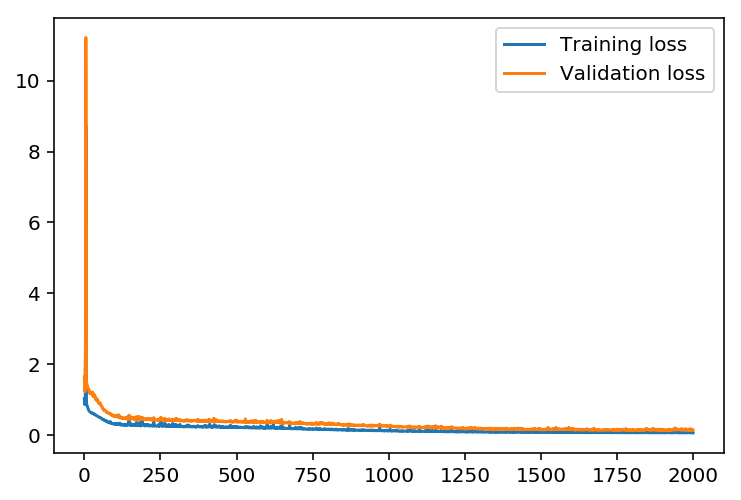

In [35]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

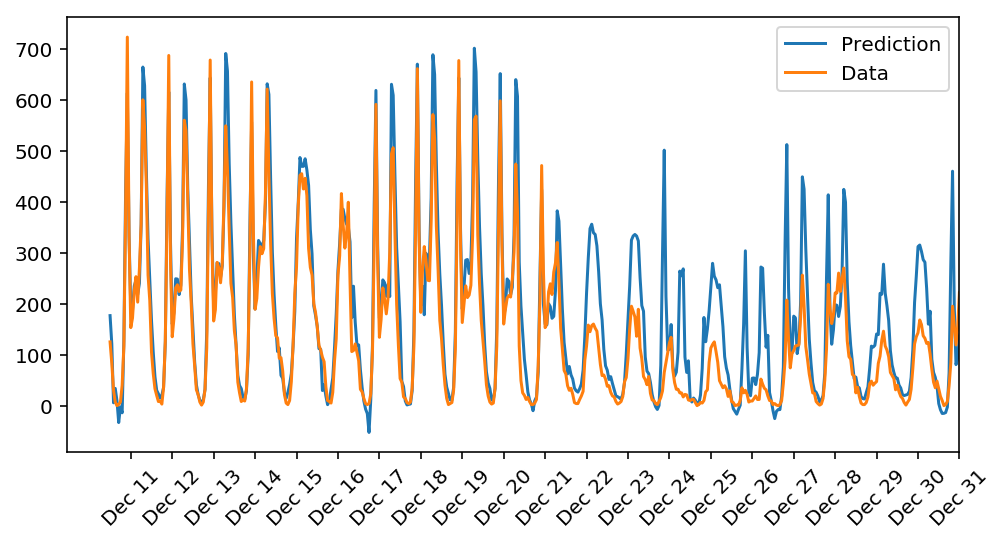

In [36]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## OPTIONAL: Thinking about your results(this question will not be evaluated in the rubric).
 
Answer these questions about your results. How well does the model predict the data? Where does it fail? Why does it fail where it does?

> **Note:** You can edit the text in this cell by double clicking on it. When you want to render the text, press control + enter

#### Your answer below

Prediction is not accurate around Christmas period. The data around these dates seems to be pretty low.

Do you think that the model can learn special features only by seeing an event one time ?
I don't think so. If more instances of these occur, I think prediction will get more accurate.